# Hoover Dam Seismology Project
## Authors: Luke Mazza, Justin Ball

Note About the Authors:
This notebook was written,formatted, and coded by Luke Mazza. The main source of oversight, data analysis, and bug-fixing on this project was Justin Ball. Dr. Ball was a crucial addition to this project and it would not have been possiblee without him. 

For View only, please visit https://nbviewer.org/github/LM2025/HooverDamProject/blob/main/HOVR_project.ipynb

# Introduction

### Hoover Dam consists of six different sensor groups, each one with a unique set of sensors 
### and dataloggers. The cables connecting these sensors and dataloggers have been suspected of altering the signal transmitted between the two devices. This can lead to inaccurate signals being recorded on the data logger. The electrical properties of these cables, which can lead to input signals from the sensors being misconstrude, can be evaluated from a series of signal processing methods. These methods follow the order of:
    - Waveform Amplitude Filtering
    - Waveform Alignment through Cross Correlation
    - Signal extraction from alingned waveforms
    - Implementation of Fourier Transforms on extracted signals
    - spectral ratio analysis of atlogger and atsensor fourier signals
    - polynomial regression modeling of spectral ratio plots

### Why use signal processing methods instead of physically measuring the electrical properties of the cables? By using signal processing, we can remotely evaluate these instead of having to visit HOVR dam for measuring. In addition, these cables are quite long. Getting information like resistance/impedence from them can be an arduous task. By implementing this code, we can achieve our goal from the comfort of our homes/offices without having to toil in the heat of southern Nevada. 

### This notebook will explore the listed methods and also serve as a resource for those who desire to analyze behavior of electrical systems that make up a seismic data system. 
### Towards the end of this notebook, there will be an additional exploration into seismic subspace detection, a method of extracting signals of interest based on a pre-built waveform template. 

# Note about the code: 
### All code lines followed by an ->EXP label were experimentally determined, and will most likely have to be altered/removed for applications outside of the HOVR dataset for optimal results

# The HOVR seismic Data format 

### All data collected from the HOVR dam is assorted in a directory tree format of HOOVERCALS -> Atlogger/Atsensorite -> {Station} -> {Channel} -> {location_code} -> {data}, where atlogger/atsensorsite are the two different sensor configurations.

### Atlogger is a setup consisting of a sensor-logger steup with only about 6ft of cable between them. This makes this setup a baseline. The atsensorsite setup is the actual sensor configruation for hoover, where the sensor and data logger are seperated by about 1,000 ft. of cable. 

### Obspy, a python third party module, is the main method we will be using to open these seismic files, which come in .sac format. Reading a file follows as:

In [1]:
#Import Neccessarry libraries
from obspy import read
import numpy as np
import matplotlib.pyplot as plt

A stream is the main data source extracted from these sac files. A stream is composed of 'traces' which explore different parts of the waveform. Traces can be simply extracted by simply indexing a stream. EX: st = [tr0,tr1]

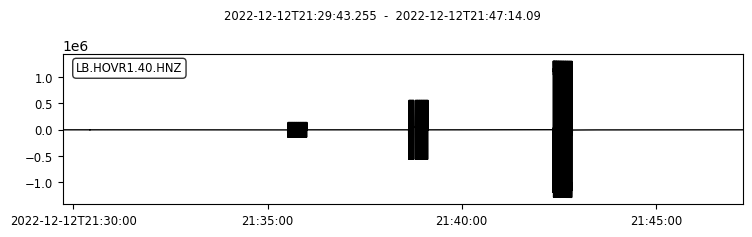

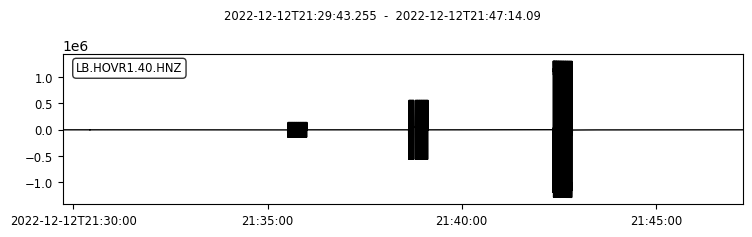

In [2]:
sac = read('Hoover_cals/HooverCals/Atsensorsite/HOVR1/HNZ.D/346/LB.HOVR1.40.HNZ.D.2022.346.21')
sac.plot()

### Let's investigate a trace contained with the above stream and use matplotlib to display it using tr.data

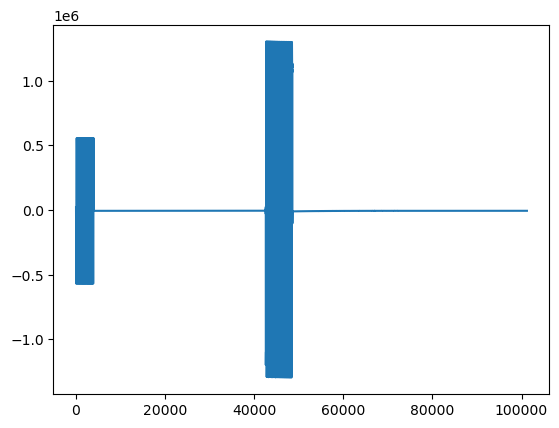

In [3]:
tr = sac[1]
info = tr.data
plt.plot(info)
plt.show()
#Rightmost part of the initial stream

In [4]:
tr.stats
#tr.stats contain useful info like dates and station/channel info

         network: LB
         station: HOVR1
        location: 40
         channel: HNZ
       starttime: 2022-12-12T21:38:48.000000Z
         endtime: 2022-12-12T21:47:14.090000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 101219
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 268, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 278528})

# Amplitude Filtering

### The waveforms we will be investigate are calibration signals generated by data loggers and observed by the sensors at hoover dam. The signals of interest we want to experiment with are the ones with the highest amplitude in a given trace. We are going to implement a basic amplitude filter, which zeros out all data points lower than the max value of the trace. A threshold of max(trace)-30000 is implemented to decrease the sensitivity of the Filter. 

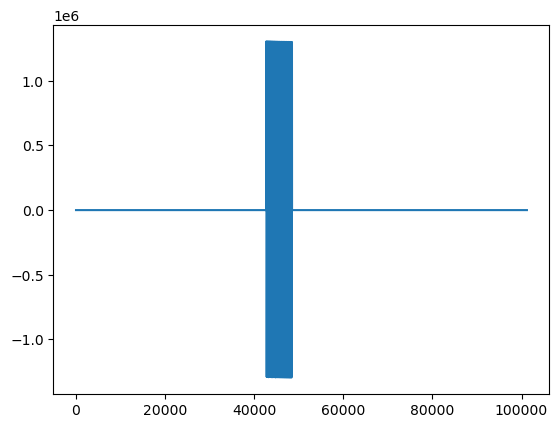

In [31]:
threshold = np.max(info) - 30000 # ->EXP
good_info = np.where(np.abs(info) >=threshold, info, info*0)
plt.plot(good_info)
plt.show()

# Atlogger and Atsensorsite Waveform cross correlation/alignment

### To properly take spectral ratios (dividing out) of the signals from our two systems, we need to align their recorded waveforms. This can be done through a process called cross-correlation. Cross Correlation is taking a part of a waveform, sliding it across another different whole waveform, and recording where they correlate the most. A parameter known as the shift is returned by this. The shift tells us how much distance one waveform needs to be shifted to be lined up with the input. 

### We will first run through the cross correlation for the atlogger system, where our correlation waveforms will be a few external sample calibration signals. Once the code is done running, it will return a dictionary filled with the atlogger correlation signals we will use on atsensor. More details of this process will be shown in the code.

In [6]:
#Import Neccessary Libraries
import obspy as ob
from scipy import signal
from obspy import read
from os import fsencode as fse
from os import fsdecode as fsd
from os import listdir as ld
from obspy.core import Trace,Stream
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import numpy as np
from cmath import exp
import math
from matplotlib.ticker import ScalarFormatter
#This is a function we will utilize during the fourier transform section later on
def abs2(x):
    return x.real**2 + x.imag**2
from numpy import float64
import pandas as pd
from numpy import mean, sqrt, square, arange
from obspy.signal.cross_correlation import correlate, xcorr_max
from obspy.signal.filter import envelope
from obspy.signal.util import smooth
import plotly
import plotly.express as px

In [7]:
!pip install plotly 

HOVR
1 Trace(s) in Stream:
LE.HOVR.30.EN1 | 2022-12-13T19:56:32.160000Z - 2022-12-13T20:00:00.465000Z | 200.0 Hz, 41662 samples
1 Trace(s) in Stream:
LE.HOVR.30.EN1 | 2022-12-13T20:00:00.470000Z - 2022-12-13T20:09:54.180000Z | 200.0 Hz, 118743 samples


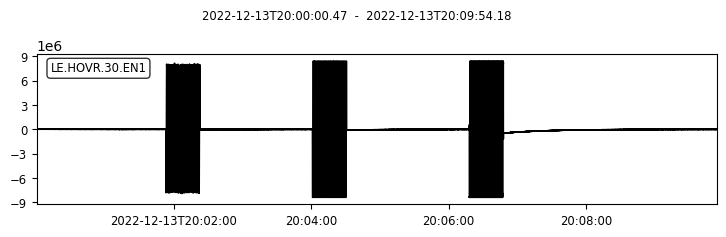

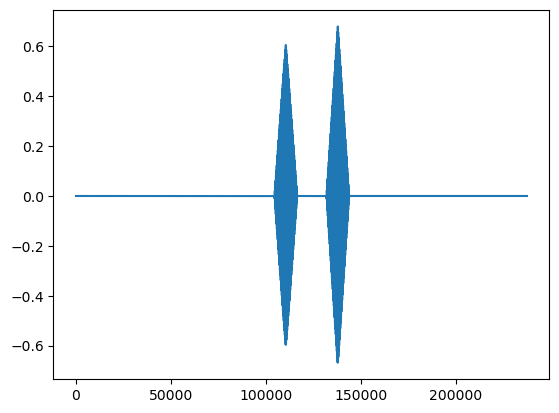

Shift and correlation values: 19135 0.6796494501744231


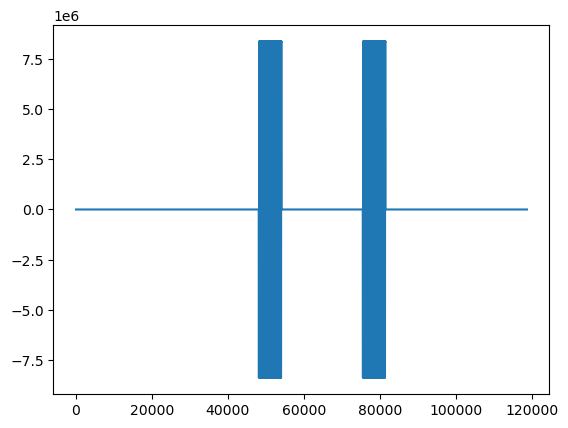

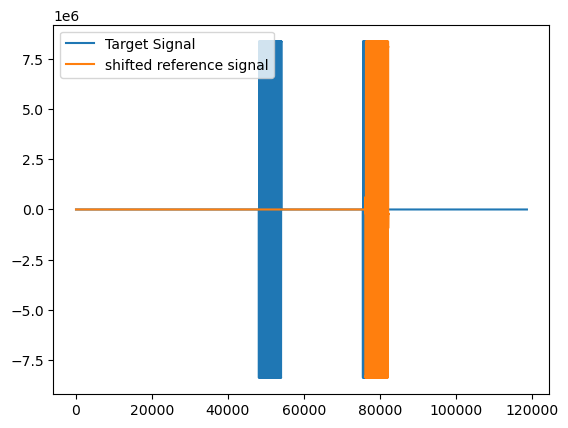

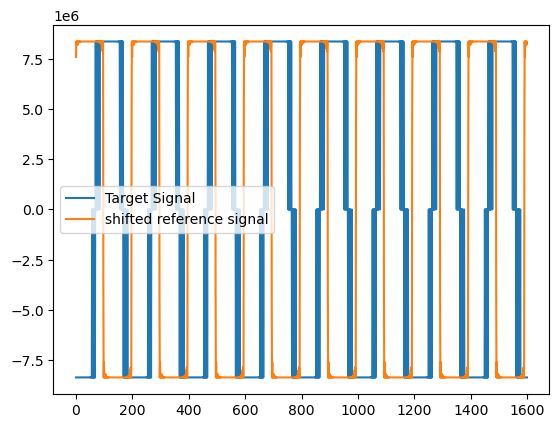

1 Trace(s) in Stream:
LE.HOVR.30.EN2 | 2022-12-13T19:56:32.350000Z - 2022-12-13T20:00:00.210000Z | 200.0 Hz, 41573 samples
1 Trace(s) in Stream:
LE.HOVR.30.EN2 | 2022-12-13T20:00:00.215000Z - 2022-12-13T20:09:54.260000Z | 200.0 Hz, 118810 samples


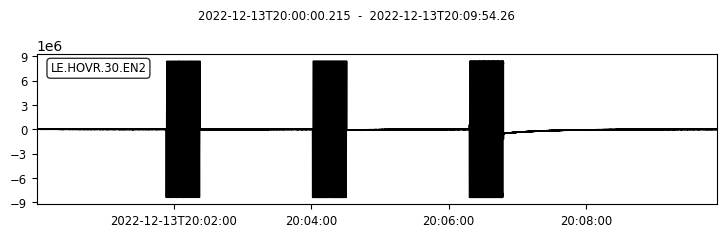

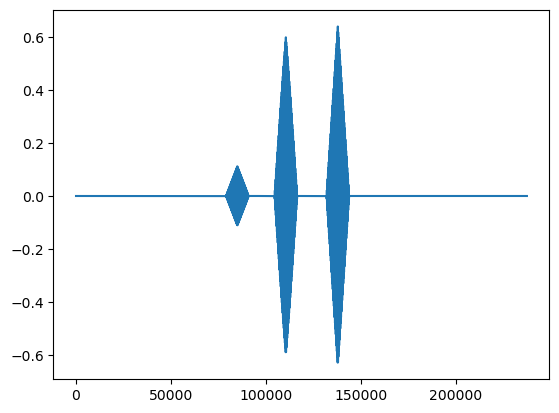

Shift and correlation values: 19152.5 0.6392614536566439


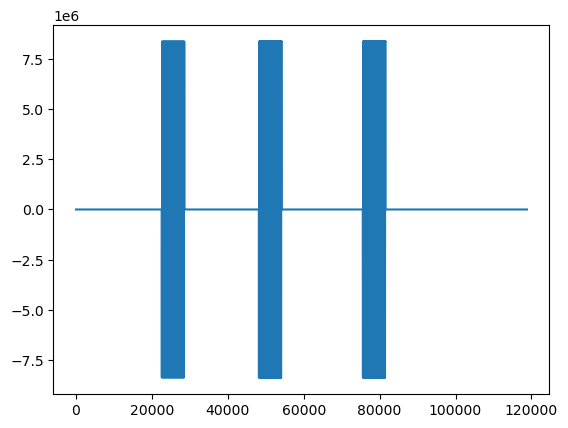

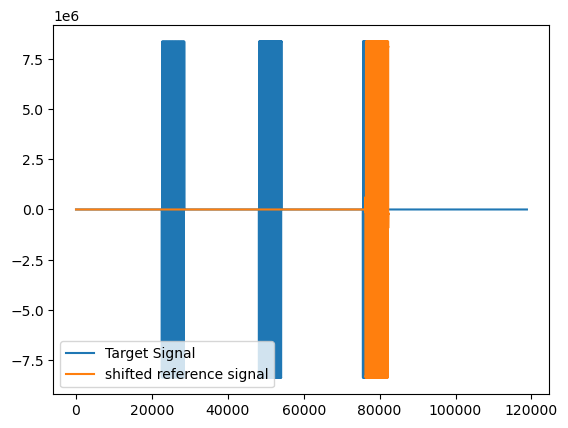

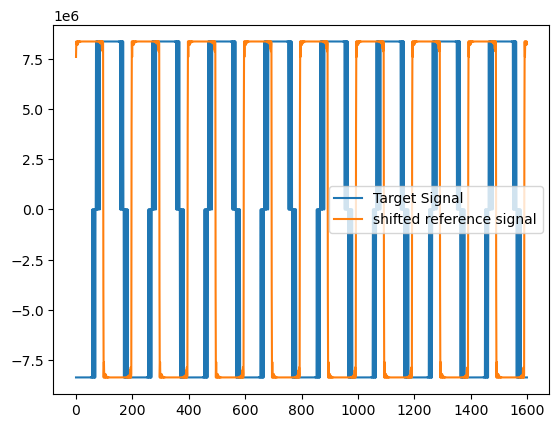

1 Trace(s) in Stream:
LE.HOVR.30.ENZ | 2022-12-13T19:56:32.105000Z - 2022-12-13T20:00:00.670000Z | 200.0 Hz, 41714 samples
1 Trace(s) in Stream:
LE.HOVR.30.ENZ | 2022-12-13T20:00:00.675000Z - 2022-12-13T20:09:53.840000Z | 200.0 Hz, 118634 samples


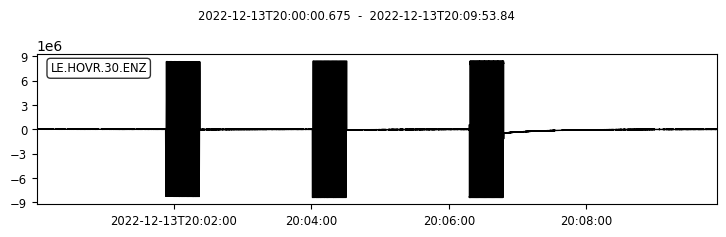

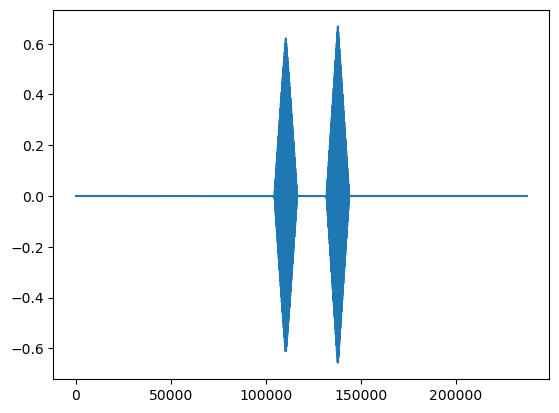

Shift and correlation values: 19148.5 0.6678242710545961


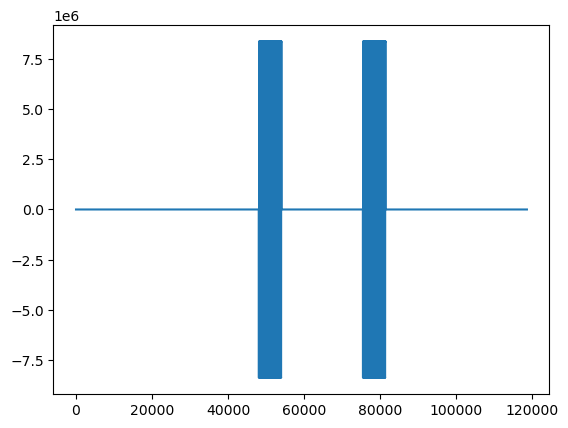

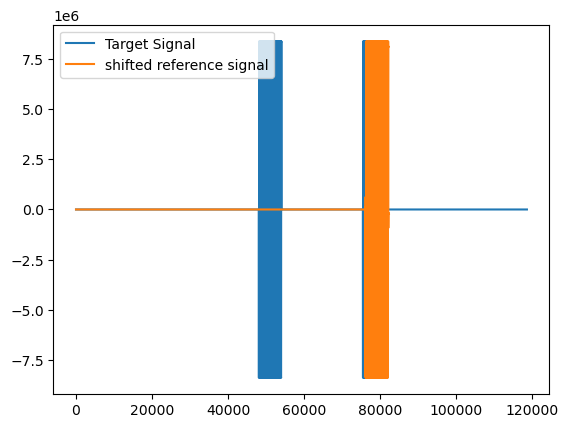

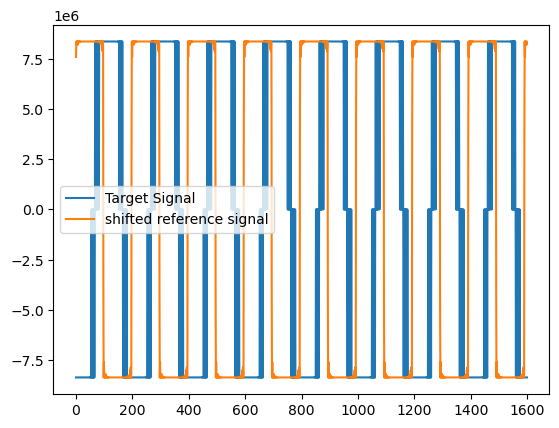

HOVR1
1 Trace(s) in Stream:
LE.HOVR1.40.EN1 | 2022-12-13T21:31:54.215000Z - 2022-12-13T21:43:43.075000Z | 200.0 Hz, 141773 samples


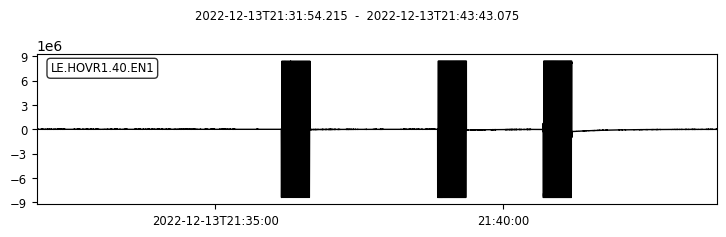

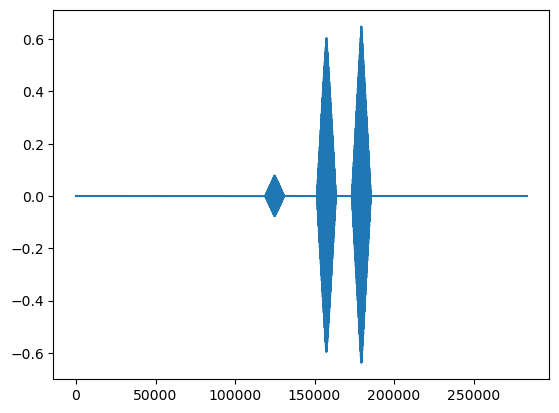

Shift and correlation values: 37671 0.6483909905187837


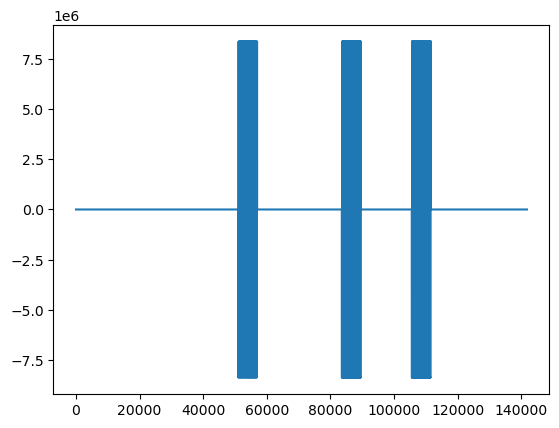

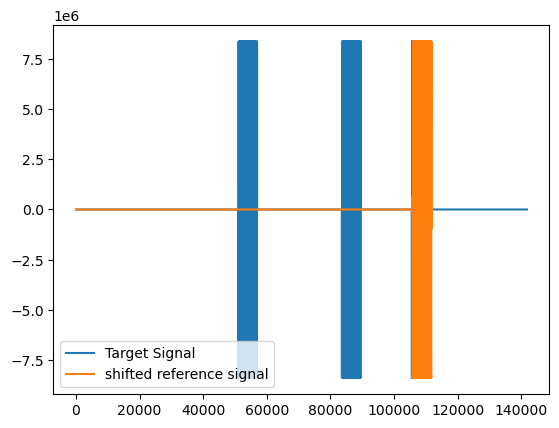

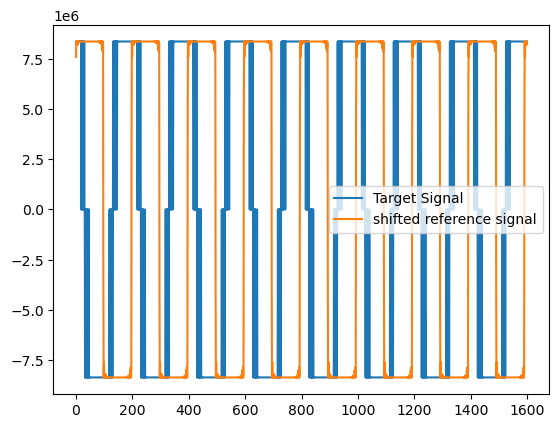

1 Trace(s) in Stream:
LE.HOVR1.40.EN2 | 2022-12-13T21:31:54.250000Z - 2022-12-13T21:43:43.050000Z | 200.0 Hz, 141761 samples


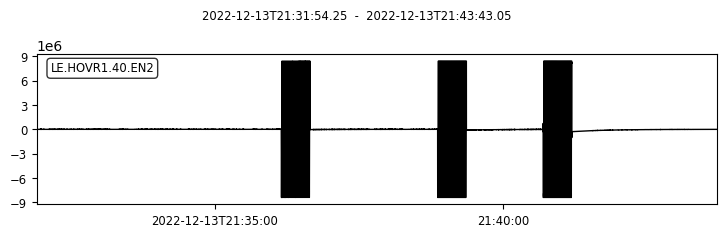

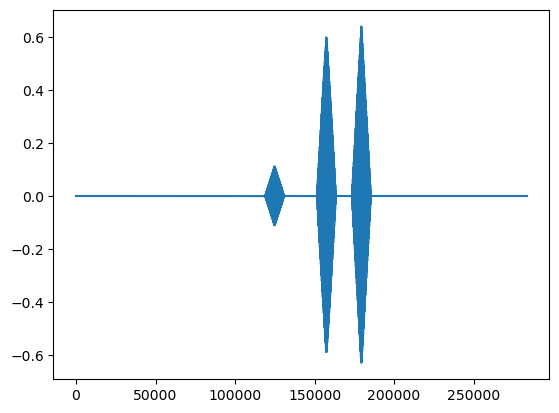

Shift and correlation values: 37670 0.6395353435446326


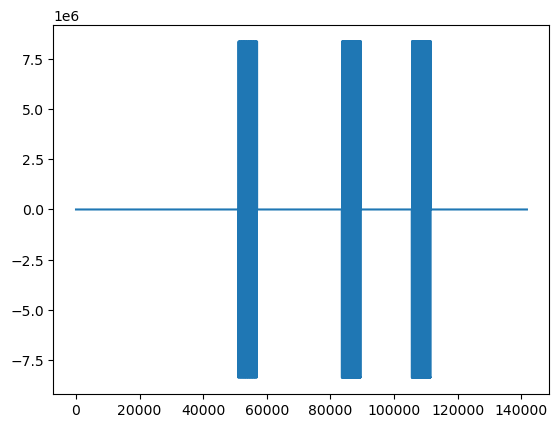

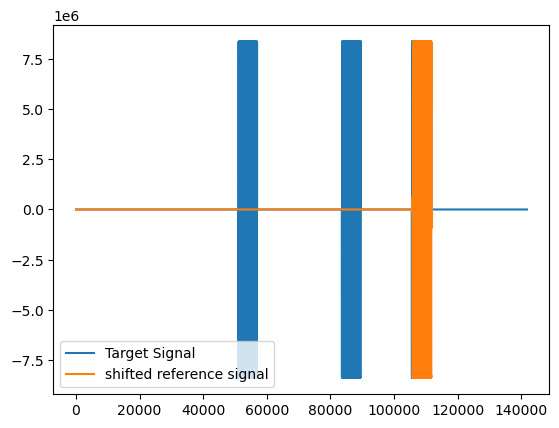

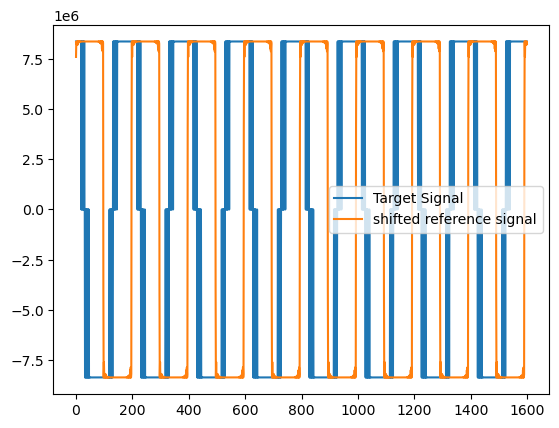

1 Trace(s) in Stream:
LE.HOVR1.40.ENZ | 2022-12-13T21:31:54.195000Z - 2022-12-13T21:43:43.255000Z | 200.0 Hz, 141813 samples


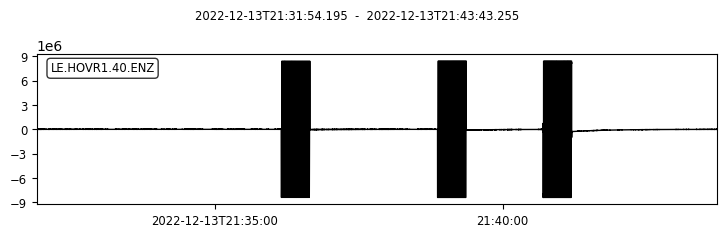

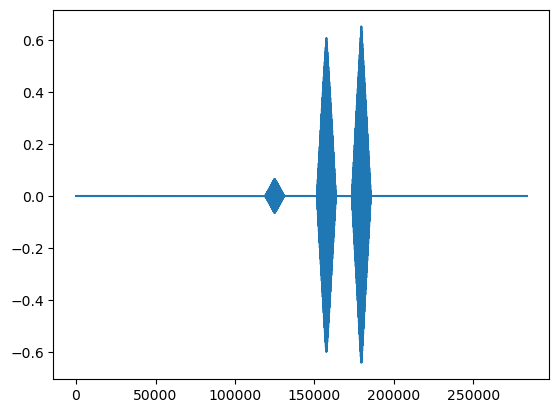

Shift and correlation values: 37655 0.6514122024366649


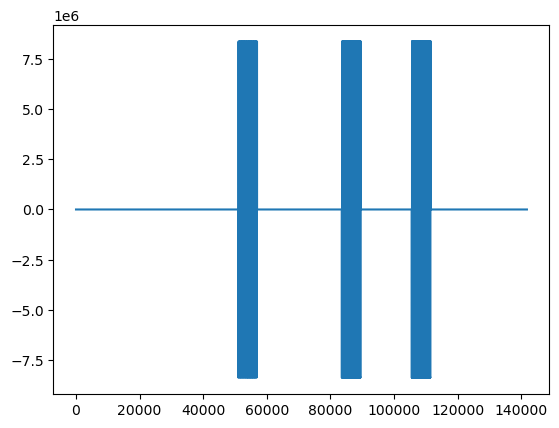

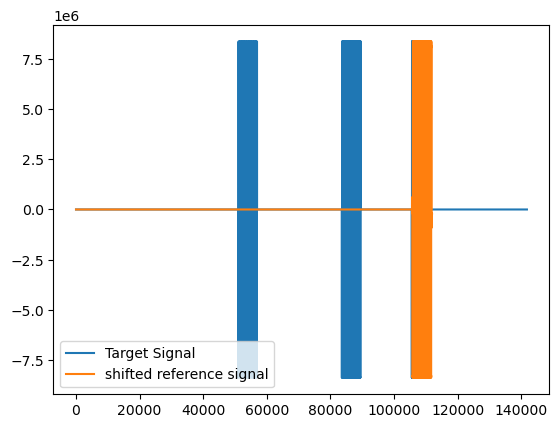

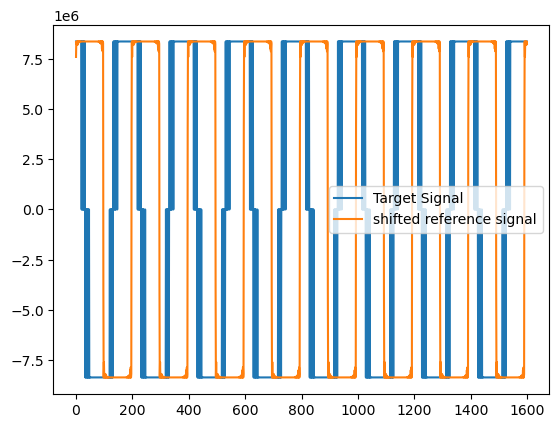

HOVR2
1 Trace(s) in Stream:
LE.HOVR2.11.EN1 | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.160000Z | 200.0 Hz, 117003 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN1 | 2022-12-13T22:00:00.165000Z - 2022-12-13T22:00:55.780000Z | 200.0 Hz, 11124 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN2 | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.030000Z | 200.0 Hz, 116977 samples
1 Trace(s) in Stream:
LE.HOVR2.11.EN2 | 2022-12-13T22:00:00.035000Z - 2022-12-13T22:00:55.650000Z | 200.0 Hz, 11124 samples
1 Trace(s) in Stream:
LE.HOVR2.11.ENZ | 2022-12-13T21:50:15.150000Z - 2022-12-13T22:00:00.960000Z | 200.0 Hz, 117163 samples
1 Trace(s) in Stream:
LE.HOVR2.11.ENZ | 2022-12-13T22:00:00.965000Z - 2022-12-13T22:00:55.550000Z | 200.0 Hz, 10918 samples
HOVR3
1 Trace(s) in Stream:
LE.HOVR3.32.EN1 | 2022-12-13T21:14:04.955000Z - 2022-12-13T21:25:20.615000Z | 200.0 Hz, 135133 samples
1 Trace(s) in Stream:
LE.HOVR3.32.EN2 | 2022-12-13T21:14:04.820000Z - 2022-12-13T21:25:20.715000Z | 200.0 Hz, 135180

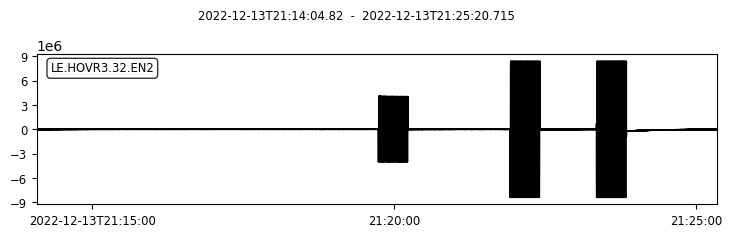

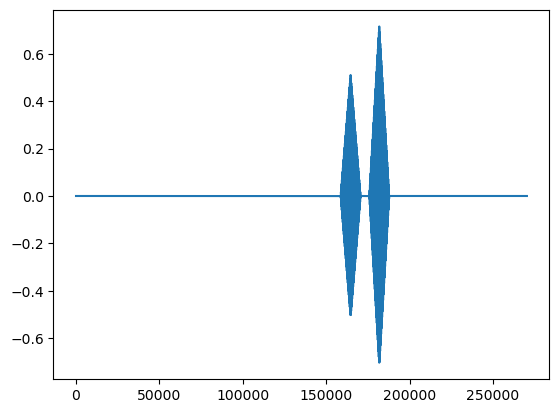

Shift and correlation values: 46646.5 0.7159777450768465


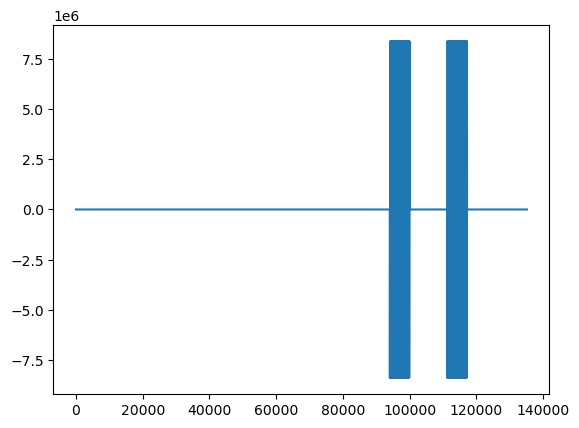

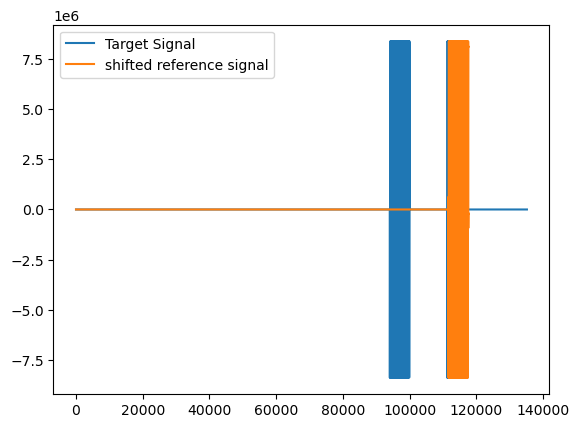

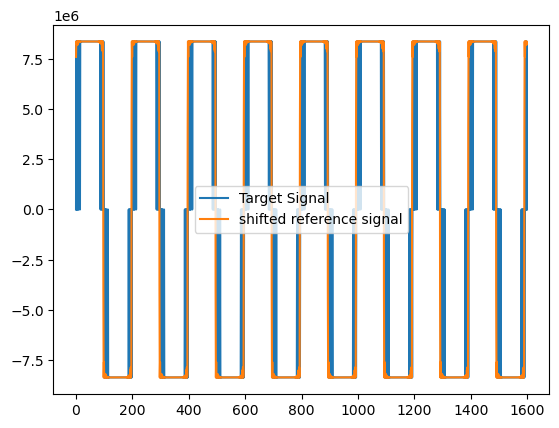

1 Trace(s) in Stream:
LE.HOVR3.32.ENZ | 2022-12-13T21:14:05.080000Z - 2022-12-13T21:25:20.130000Z | 200.0 Hz, 135011 samples


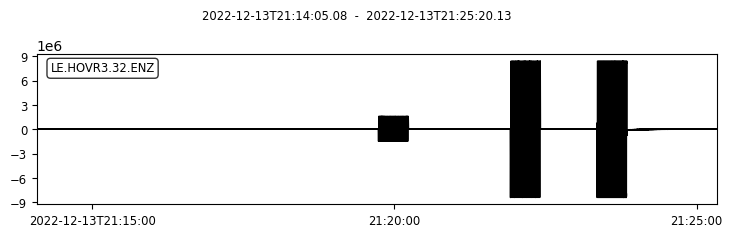

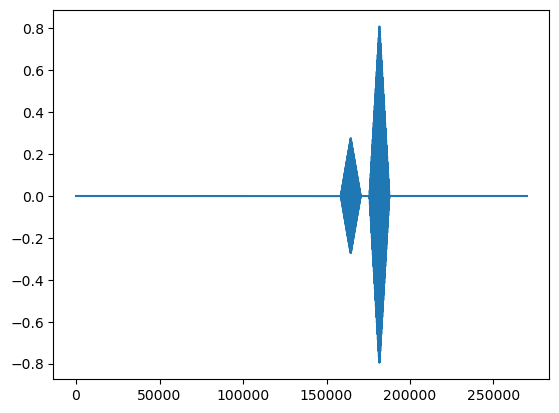

Shift and correlation values: 46679 0.8090582168755724


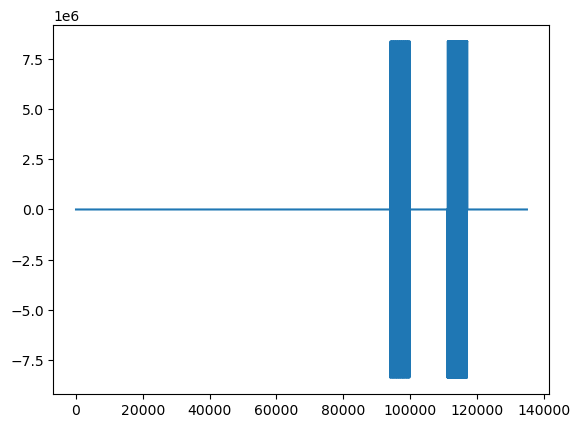

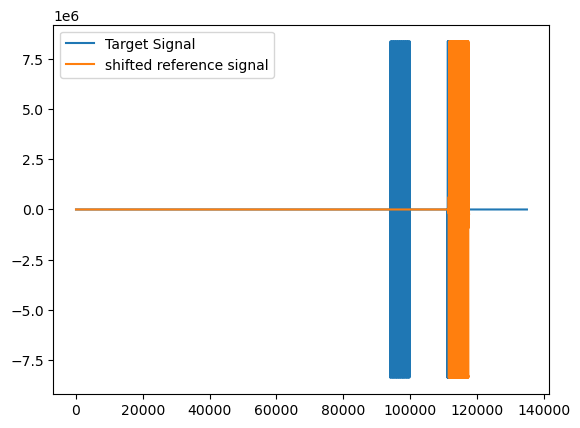

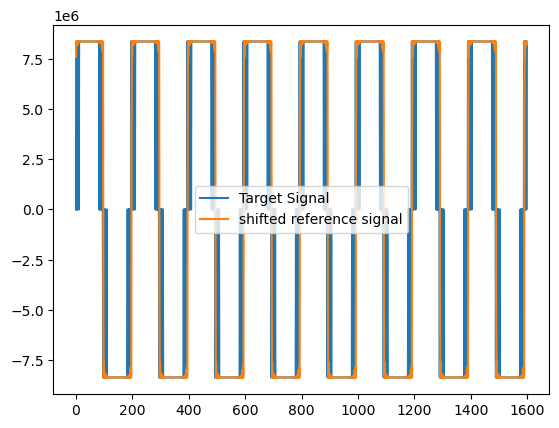

HOVR4
1 Trace(s) in Stream:
LE.HOVR4.42.EN1 | 2022-12-13T22:06:15.330000Z - 2022-12-13T22:24:29.925000Z | 200.0 Hz, 218920 samples


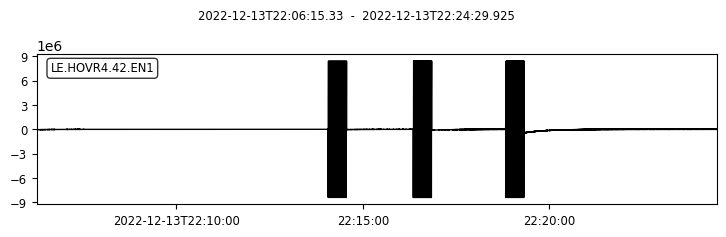

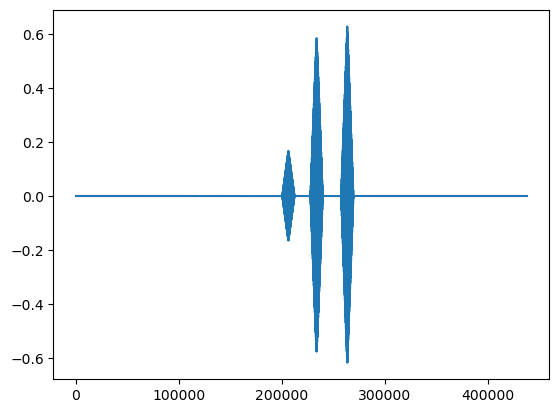

Shift and correlation values: 44474.5 0.6271053253036122


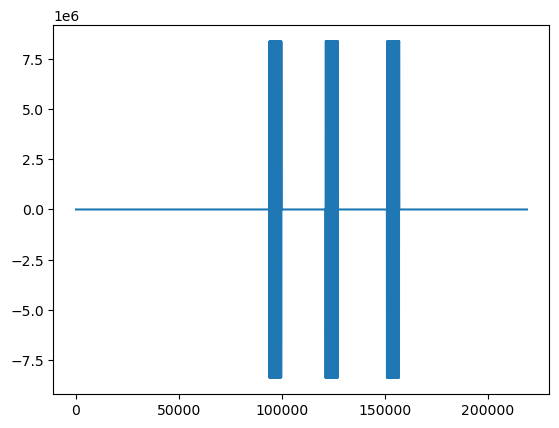

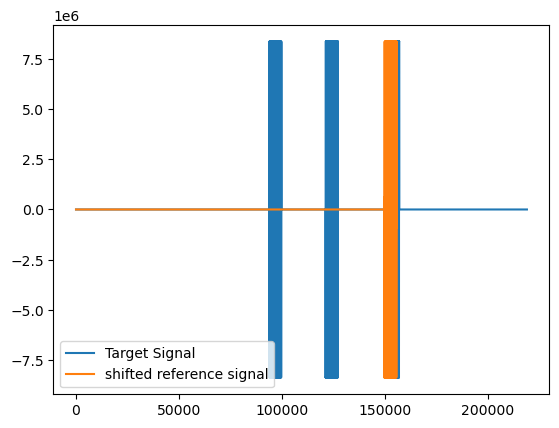

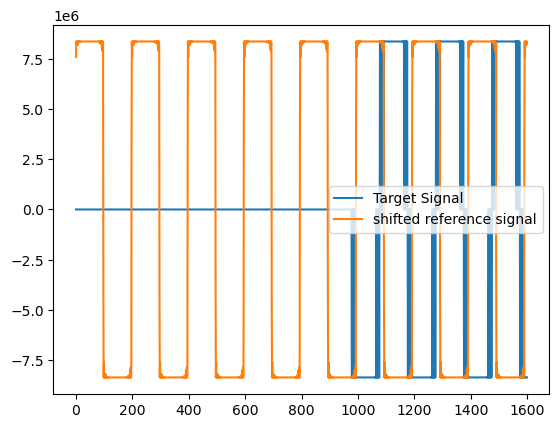

1 Trace(s) in Stream:
LE.HOVR4.42.EN2 | 2022-12-13T22:06:15.355000Z - 2022-12-13T22:24:29.995000Z | 200.0 Hz, 218929 samples


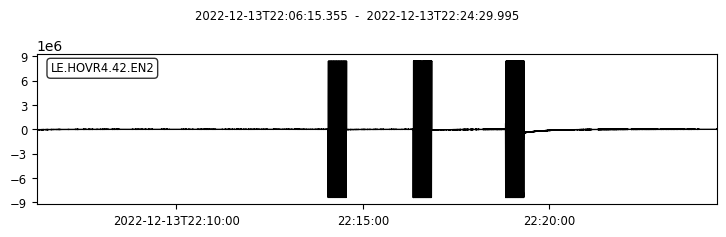

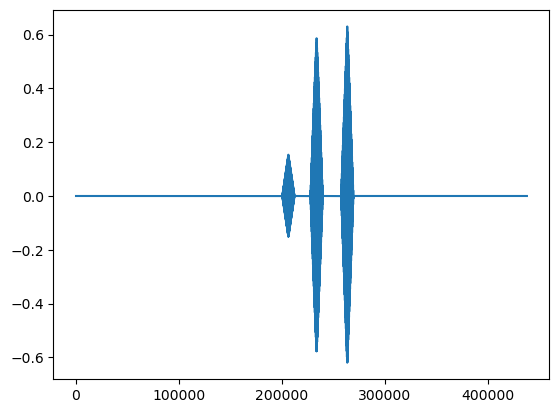

Shift and correlation values: 44465 0.6303089031426067


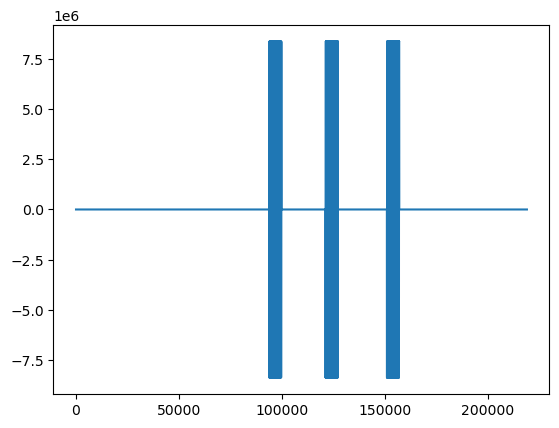

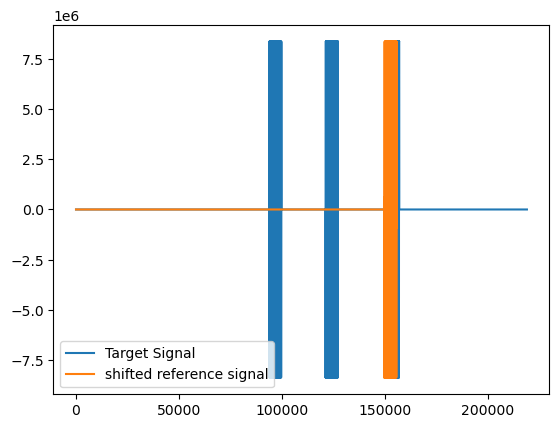

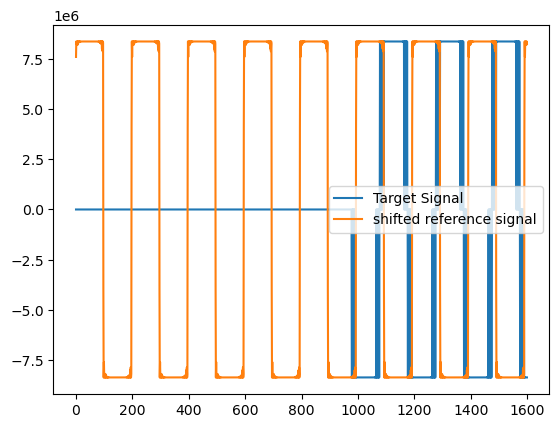

1 Trace(s) in Stream:
LE.HOVR4.42.ENZ | 2022-12-13T22:06:15.410000Z - 2022-12-13T22:24:29.720000Z | 200.0 Hz, 218863 samples


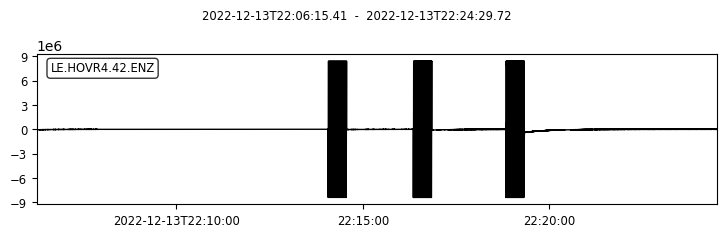

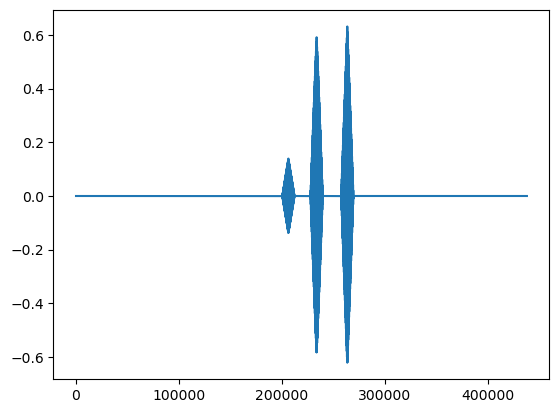

Shift and correlation values: 44487 0.6317262230291755


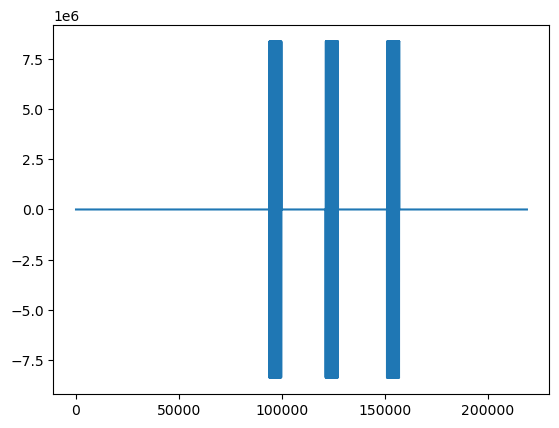

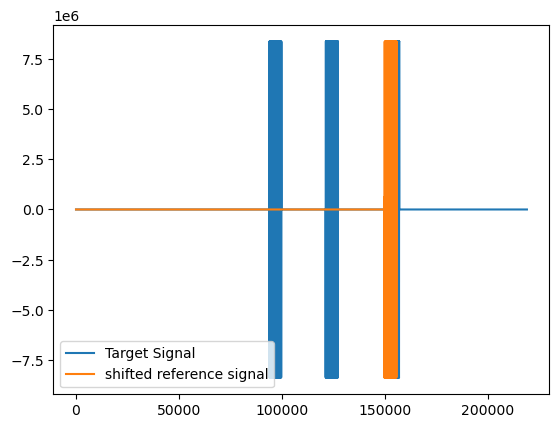

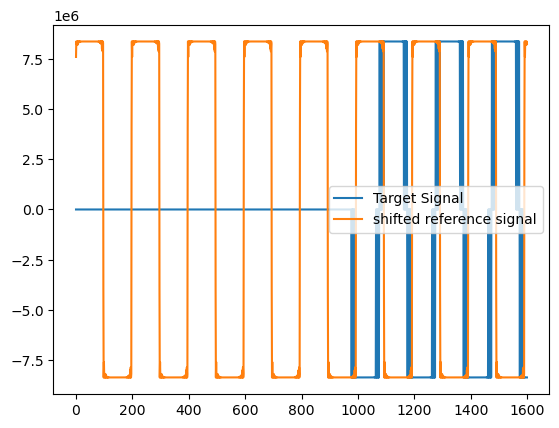

HOVR5
1 Trace(s) in Stream:
LE.HOVR5.50.EN1 | 2022-12-13T20:51:36.500000Z - 2022-12-13T21:00:00.730000Z | 200.0 Hz, 100847 samples


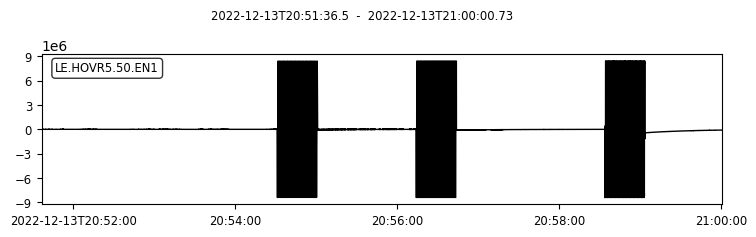

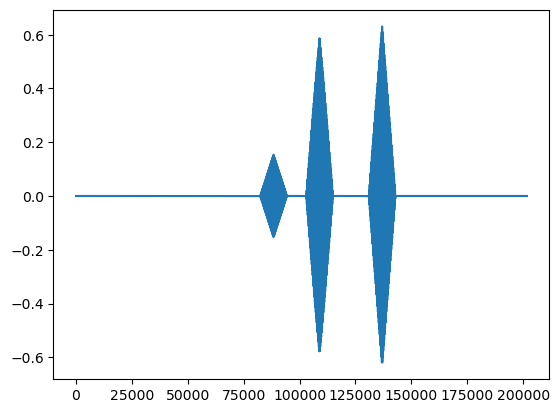

Shift and correlation values: 36077 0.6306579127853164


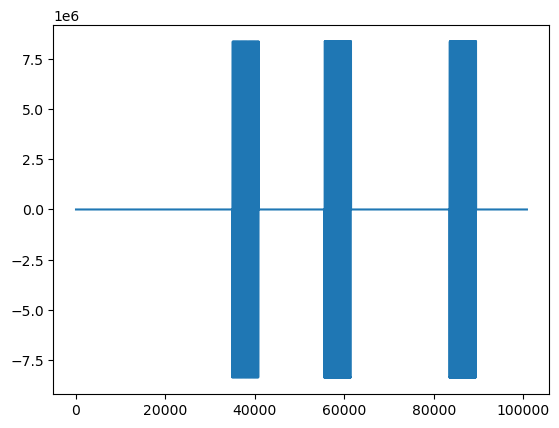

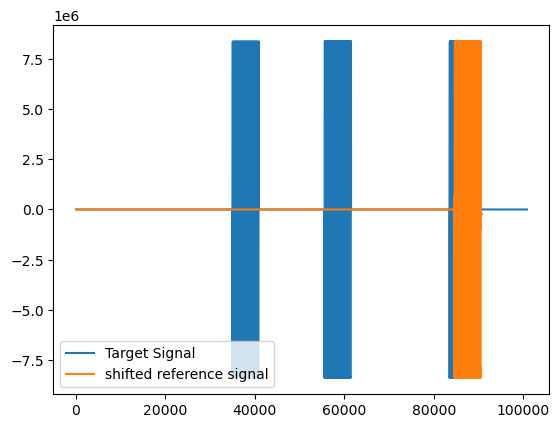

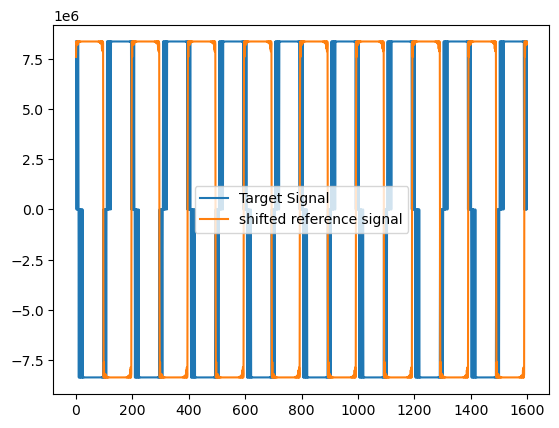

1 Trace(s) in Stream:
LE.HOVR5.50.EN1 | 2022-12-13T21:00:00.735000Z - 2022-12-13T21:01:39.620000Z | 200.0 Hz, 19778 samples
1 Trace(s) in Stream:
LE.HOVR5.50.EN2 | 2022-12-13T20:51:36.515000Z - 2022-12-13T21:00:00.140000Z | 200.0 Hz, 100726 samples


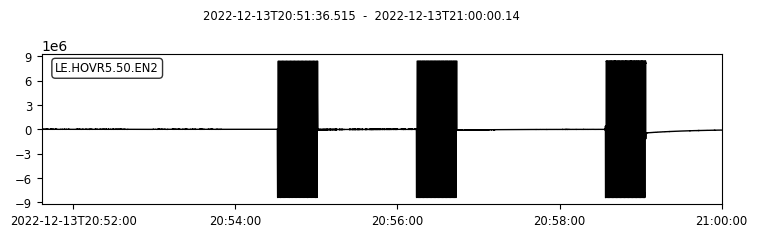

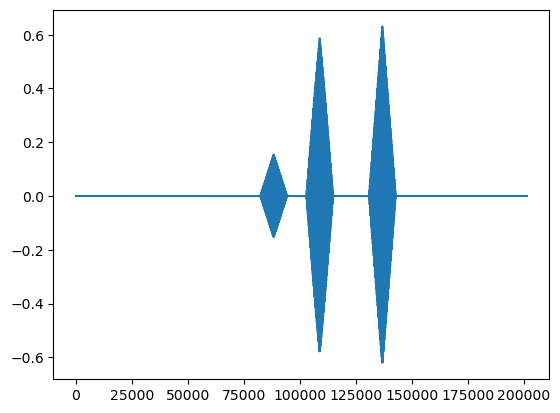

Shift and correlation values: 36134.5 0.6306007150749257


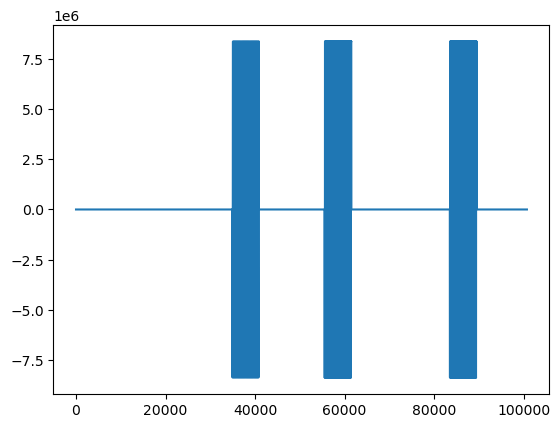

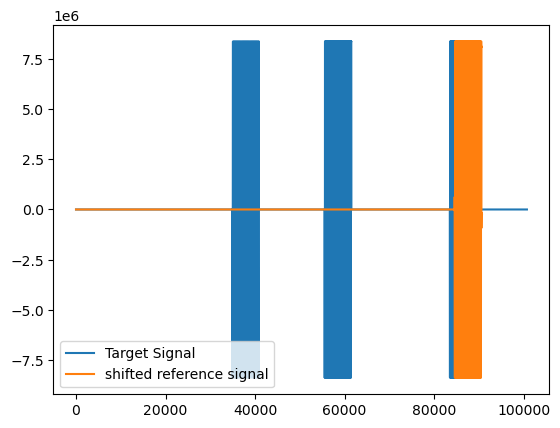

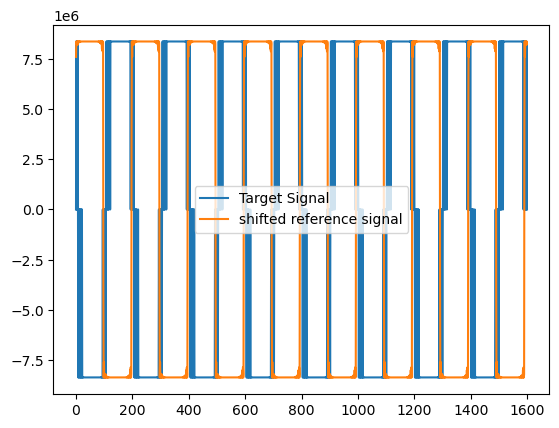

1 Trace(s) in Stream:
LE.HOVR5.50.EN2 | 2022-12-13T21:00:00.145000Z - 2022-12-13T21:01:40.305000Z | 200.0 Hz, 20033 samples
1 Trace(s) in Stream:
LE.HOVR5.50.ENZ | 2022-12-13T20:51:36.520000Z - 2022-12-13T21:00:00.350000Z | 200.0 Hz, 100767 samples


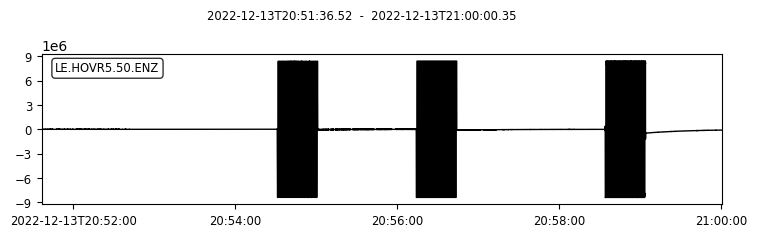

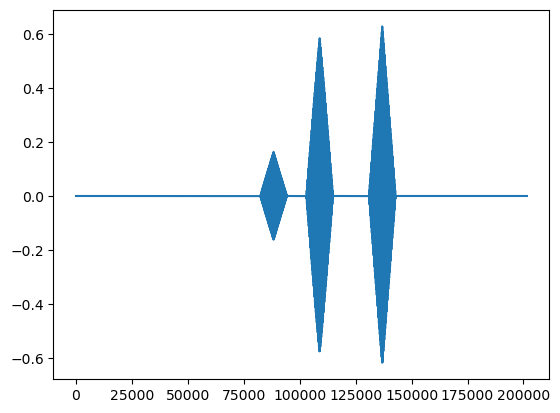

Shift and correlation values: 36113 0.6283879830298844


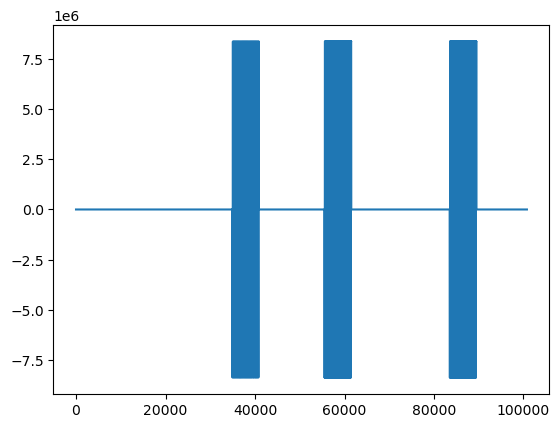

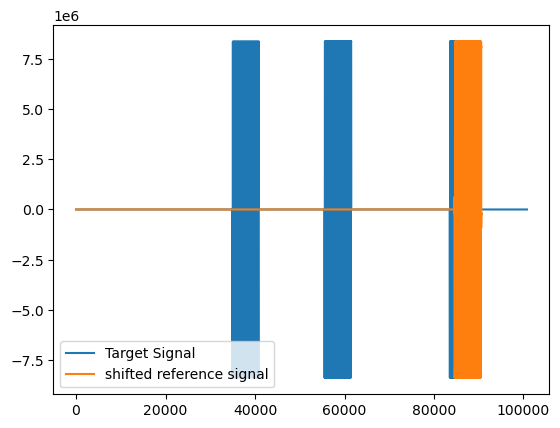

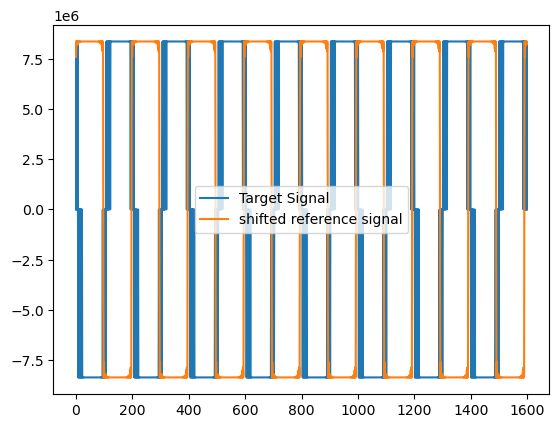

1 Trace(s) in Stream:
LE.HOVR5.50.ENZ | 2022-12-13T21:00:00.355000Z - 2022-12-13T21:01:40.505000Z | 200.0 Hz, 20031 samples
HOVR6
1 Trace(s) in Stream:
LE.HOVR6.52.EN1 | 2022-12-13T20:21:25.460000Z - 2022-12-13T20:35:57.040000Z | 200.0 Hz, 174317 samples


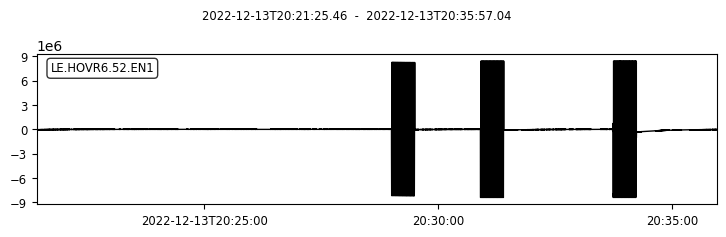

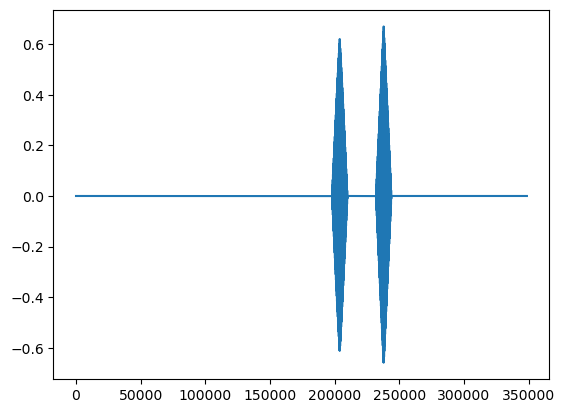

Shift and correlation values: 63550 0.6697844236279927


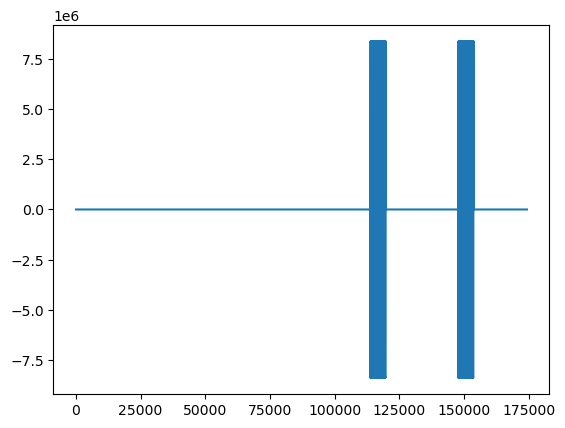

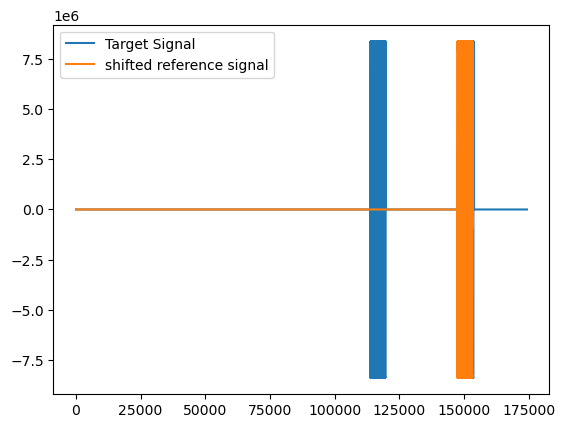

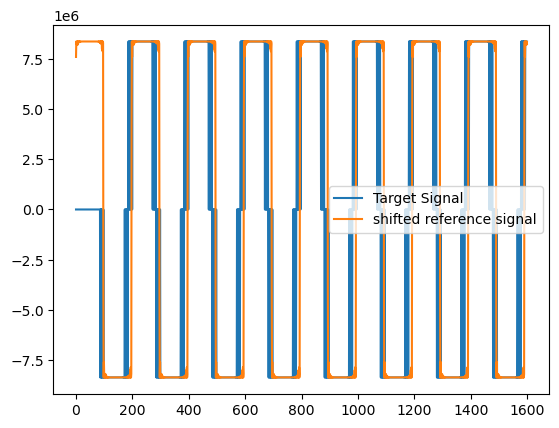

1 Trace(s) in Stream:
LE.HOVR6.52.EN2 | 2022-12-13T20:21:25.485000Z - 2022-12-13T20:35:57.475000Z | 200.0 Hz, 174399 samples


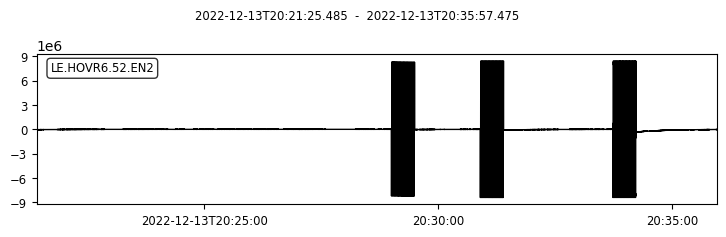

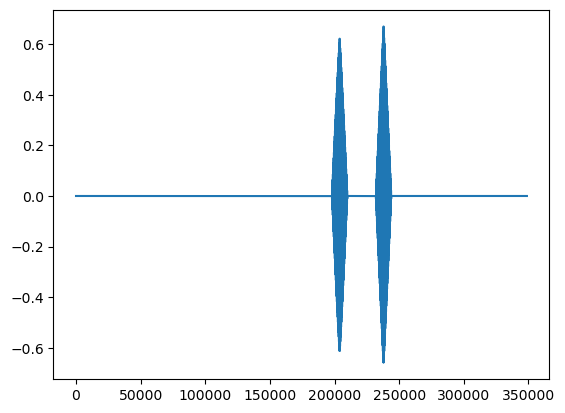

Shift and correlation values: 63504 0.6694515094164765


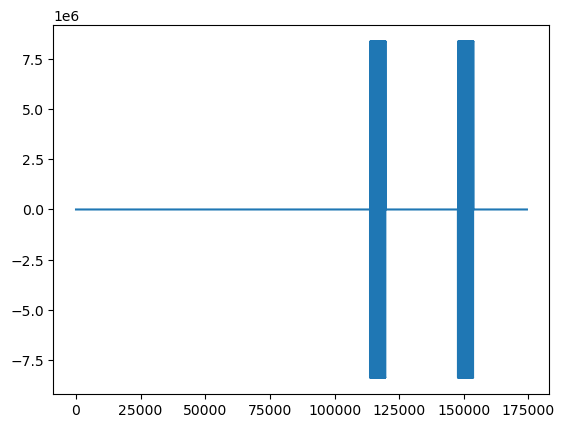

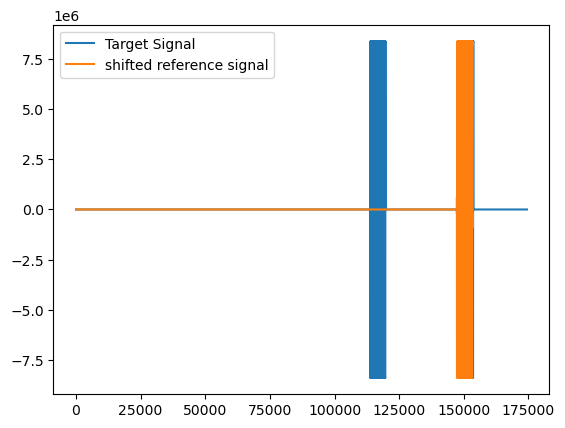

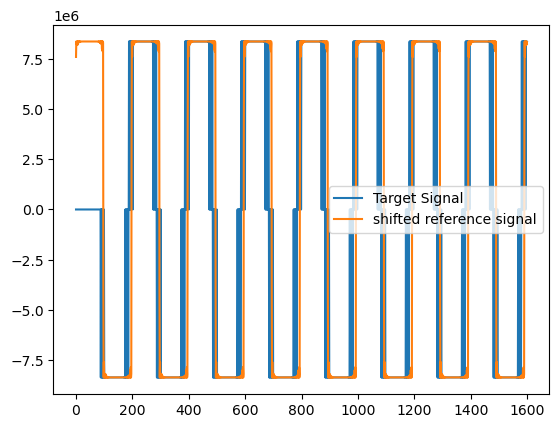

1 Trace(s) in Stream:
LE.HOVR6.52.ENZ | 2022-12-13T20:21:25.505000Z - 2022-12-13T20:35:57.695000Z | 200.0 Hz, 174439 samples


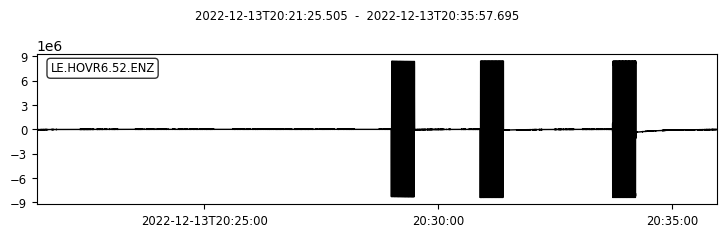

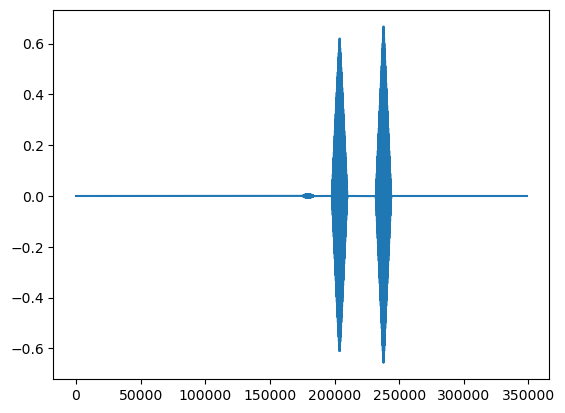

Shift and correlation values: 63480 0.6671661170306001


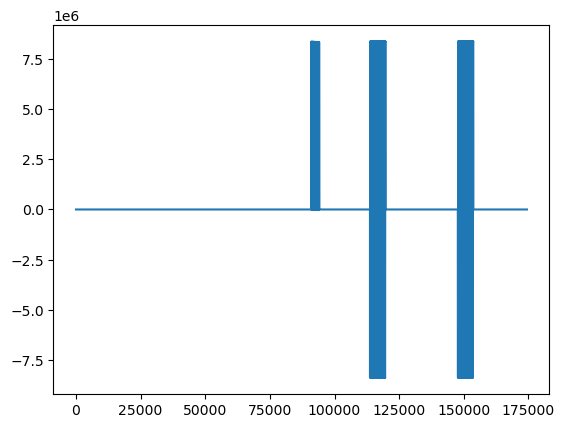

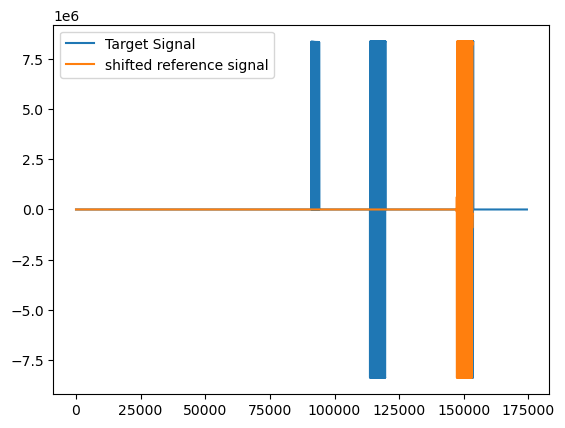

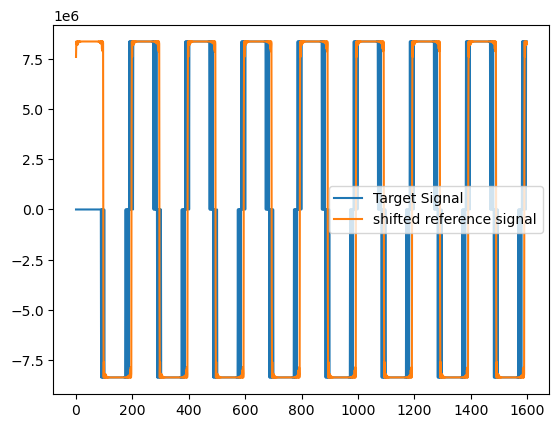

In [32]:
def get_atlogger_references():
    #Encode the top directory 
    directory = fse('Hoover_cals/HooverCals/Atlogger/')
    #Make three reference streams that will be used for cross correlation
    reference = read('calibration_waveforms/LB.HOVR.30.EN1.square.sac')
    reference2 = read('calibration_waveforms/LB.HOVR.30.EN2.square.sac')
    reference3 = read('calibration_waveforms/LB.HOVR.30.ENZ.square.sac')
    reference_correlate_list = [reference[0].data,reference2[0].data,reference3[0].data]
    #List the Files of the Encoded directory
    storage = ld(directory)
    #Make a dictionary that will contain all of the data.
    station_dict = {}
    #Loop through all the entries in the Encoded Directory
    for dir in storage:
        #Decode the directory and encode its contents  
        file = fsd(dir)
        #Print the filename, which in this case is the station ID
        print(file)
        new_dir = fse(f'Hoover_cals/HooverCals/Atlogger/{file}')
        # Create a new list of the directory's encoded sub-directories
        new_storage = ld(new_dir)
        #Create a list that will contain all the data for a given station
        channel_list = []
        i = -1
        #Loop through the encoded contents of the most recently decoded directory
        for dir2 in new_storage:
            #Decode the most recently encoded directory. A pattern is Emerging here. Essentially, we follow this 
            #convention of encoding and decoding the filesystem until we reach all the sac files at the bottom 
            #of the Directory Tree. 
            file2 = fsd(dir2)
            #For this project, we are only concerned with all the EN* stations on Hoover, so all HN* stations will be ingored. 
            if file2[0] != 'E':
                continue
            new_dir2 = fse(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}')
            new_storage2 = ld(new_dir2)
            i+=1
            #Loop through the encoded contents of the recently decoded directory. 
            for dir3 in new_storage2:
                file3 = fsd(dir3)
                new_dir3 = fse(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}/{file3}')
                new_storage3 = ld(new_dir3)
                #We have finally reached the sac files we want to work with. Let's perform some operations 
                for sac_file in new_storage3:
                    #Read in the data stream from the sac file using Obspy 
                    sac_obs = fsd(sac_file)
                    st = read(f'Hoover_cals/HooverCals/Atlogger/{file}/{file2}/{file3}/{sac_obs}')
                    #print the stream information, and loop through it if it contains more than one trace
                    print(st)
                    if len(st) != 1:
                        dominant_trace = st[0]
                        #Compare the Root-Mean_squared values of the traces. We do this to extract the trace with the 'most' 
                        #data in it to make our results accurate
                        for tr in st[1:]:
                            if sqrt(mean(square(tr.data))) > sqrt(mean(square(dominant_trace.data))):
                                dominant_trace = tr
                        #Retrieve the data of the dominant trace, establish a threshold, and perform amplitude filtering. 
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        #Cross correlate a reference signal reference waveform. This will make an array with correlation constants.
                        cc = correlate(good_info,reference_correlate_list[i],len(good_info))
                    else:
                        #Same process, but no need to loop through a single-trace stream. 
                        dominant_trace = st[0]
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        cc = correlate(good_info,reference_correlate_list[i],len(good_info))
                    #We only want to move forward if the correlation is at least a little strong. Any stations/channels 
                    #that do not make the correlation threshold wont't be included. 
                    if np.max(cc) > 0.1: # ->EXP
                        #Plot the dominant trace to display station and channel ID. 
                        dominant_trace.plot()
                        #Plot the correlation coefficients. 
                        plt.plot(np.arange(0,len(cc)),cc)
                        plt.show()
                        #Find the shift value and max correlation value of the waveforms, and print them out. 
                        shift,correlation_value = xcorr_max(cc)
                        print('Shift and correlation values:',shift,correlation_value)
                        # We found emperically that the shift alone is not enough to align a lot of the waveforms. 
                        # So we will have to make an add on 
                        # Based on the length of the original data array and the correlation array. 
                        if len(info) < 1e5: # ->EXP
                            add_on = len(cc)*0.2153 # ->EXP
                        else:
                            add_on = len(cc)*0.24 # ->EXP
                        #Make an alignment waveform based on the add_on parameter
                        check = np.concatenate((np.zeros(np.abs(int(shift+add_on))),reference_correlate_list[i])) # ->EXP
                        #Plot the data array by itself, and then along with the alignment waveform. 
                        plt.plot(good_info)
                        plt.show()
                        plt.plot(good_info)
                        plt.plot(check)
                        plt.legend(['Target Signal','shifted reference signal'])
                        plt.show()
                        #Based on the shift value, plot a zoomed in version of the data array and alingment waveform. 
                        if shift > 0:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+200:midpoint+1800]) # ->EXP
                            plt.plot(check[midpoint+200:midpoint+1800]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        else:
                            midpoint = check.argmax()
                            plt.plot(good_info[:midpoint]) # ->EXP
                            plt.plot(check[:midpoint]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        #Save the atlogger waveform to the channel list 
                        channel_list.append(good_info[midpoint+1300:midpoint+4800]) # ->EXP
        #Save all the channel lists from a given station to the dictionary. 
        station_dict[f'{file}'] = channel_list
    return(station_dict)
    
station_dict= get_atlogger_references()
          

If you look at the returned dictionary, no data was extracted for HOVR2. HOVR2 turned out to have the longest cable conneected between the data logger and main sensor. We deduced the lack of returned data was due to the HOVR2 cable changing the signals to the point that there was not enough correlation between the waveforms. Let's delete this part of the dictionary. 

Our waveform alignment scheme performed better for some waveforms compared to others. Although some of the signals might not be completely matched up, the general position of the atlogger signals has been effectively oriented with that of the external calibration signals. These reults are sufficient for use with the astensor waveforms.

In [33]:
#Uncomment the below line to delete HOVR2 from the dictionary
del station_dict['HOVR2'] # ->EXP
station_dict

{'HOVR': [array([ 8388606,  8388606,  8388606, ..., -8386326, -8386326, -8386326]),
  array([ 8388606,  8388606,  8388606, ..., -8386326, -8386326, -8386326]),
  array([ 8388606,  8388606,  8388606, ..., -8386326, -8386326, -8386326])],
 'HOVR1': [array([-8386381, -8385154, -8384508, ...,  8388607,        0,  8388607]),
  array([-8386381, -8385154, -8384508, ...,  8388607,        0,  8388607]),
  array([-8386348, -8386382, -8385156, ...,        0,  8388607,        0])],
 'HOVR3': [array([-8388608,        0, -8388608, ...,  8388607,  8384892,  8387838]),
  array([-8388608, -8382595,        0, ...,  8386712,  8388407,  8388607])],
 'HOVR4': [array([ 8387827,  8386711,  8388406, ..., -8386326, -8386326, -8386326]),
  array([ 8387826,  8386712,  8388407, ..., -8386326, -8386326, -8386326]),
  array([ 8386711,  8388406,  8388607, ..., -8386326, -8386326, -8386326])],
 'HOVR5': [array([-8388608,        0, -8388608, ...,        0,        0,        0]),
  array([-8388608,        0,        0, .

### So now we have our atlogger correlation waveforms. Let's repeat this process by cross correlating our atlogger signals with the atsensor signals. This code block is almost identical to the above one, with the exception of the addition of an atlogger dictionary we will store data in for the spectral ratios. 

2 Trace(s) in Stream:
LB.HOVR.30.EN1 | 2022-12-09T20:52:28.400000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50720 samples
LB.HOVR.30.EN1 | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.360000Z | 200.0 Hz, 34073 samples
0.05737709165956857
5 Trace(s) in Stream:
LB.HOVR.30.EN1 | 2022-12-09T21:00:00.365000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33327 samples
LB.HOVR.30.EN1 | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.EN1 | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.EN1 | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.EN1 | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:00.530000Z | 200.0 Hz, 69307 samples
0.03711582364587417
1 Trace(s) in Stream:
LB.HOVR.32.EN1 | 2022-12-12T20:22:50.795000Z - 2022-12-12T20:41:12.595000Z | 200.0 Hz, 220361 samples
0.547962314241332


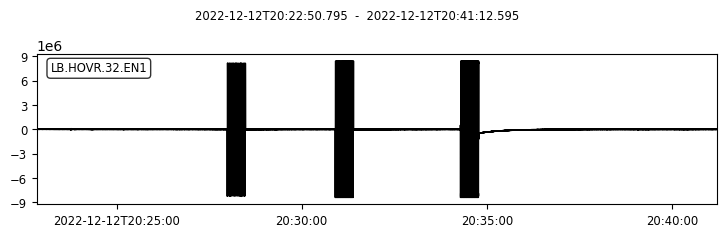

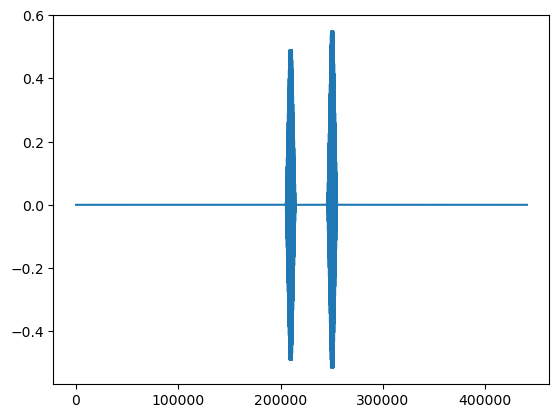

28948.5 0.547962314241332


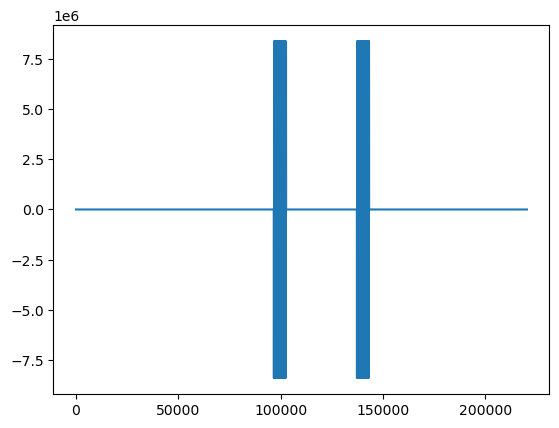

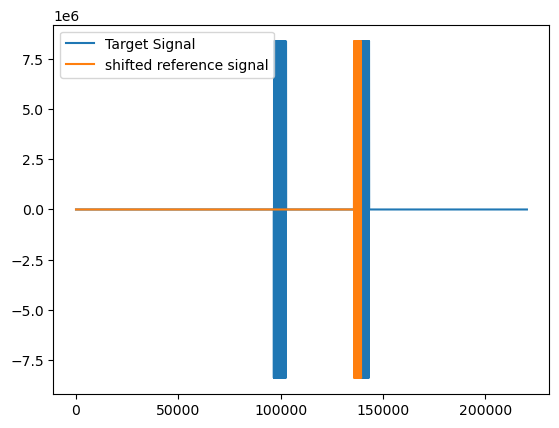

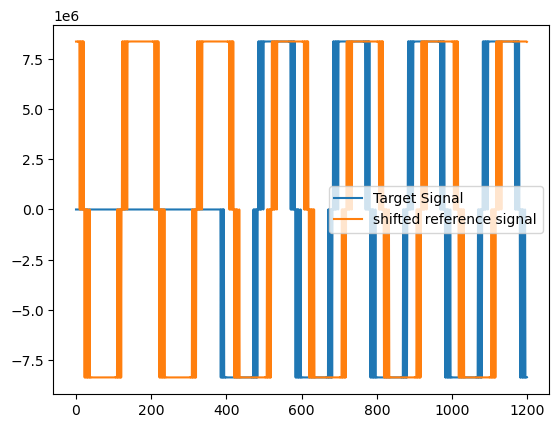

2 Trace(s) in Stream:
LB.HOVR.30.EN2 | 2022-12-09T20:52:28.055000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50789 samples
LB.HOVR.30.EN2 | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.660000Z | 200.0 Hz, 34133 samples
0.05717909144097155
5 Trace(s) in Stream:
LB.HOVR.30.EN2 | 2022-12-09T21:00:00.665000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33267 samples
LB.HOVR.30.EN2 | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.EN2 | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.EN2 | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.EN2 | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:00.400000Z | 200.0 Hz, 69281 samples
0.710624407102004


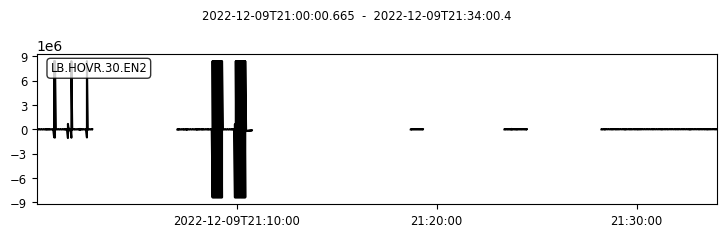

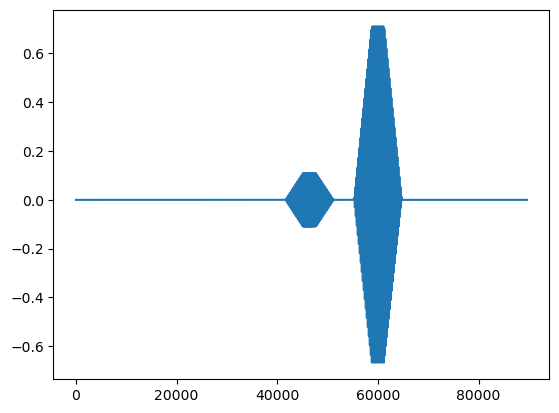

14485 0.710624407102004


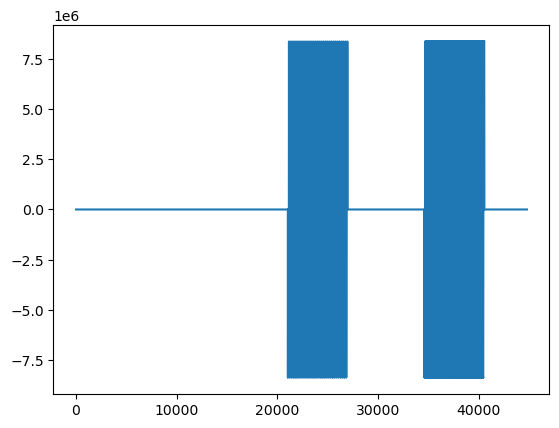

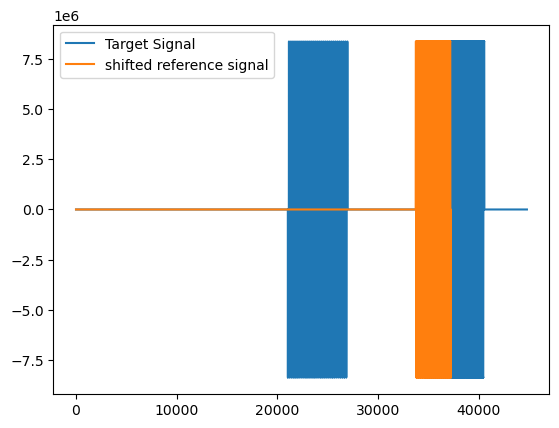

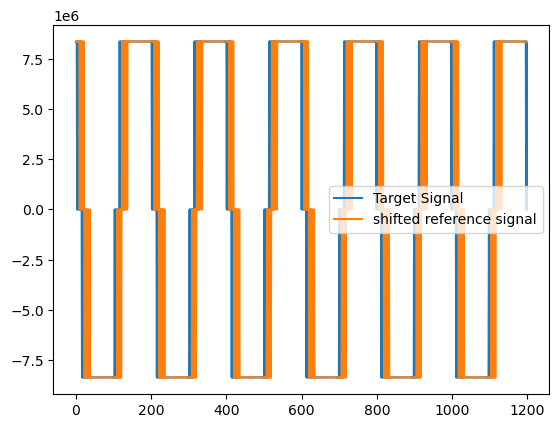

1 Trace(s) in Stream:
LB.HOVR.32.EN2 | 2022-12-12T20:22:50.995000Z - 2022-12-12T20:41:12.860000Z | 200.0 Hz, 220374 samples
0.5176833612865875


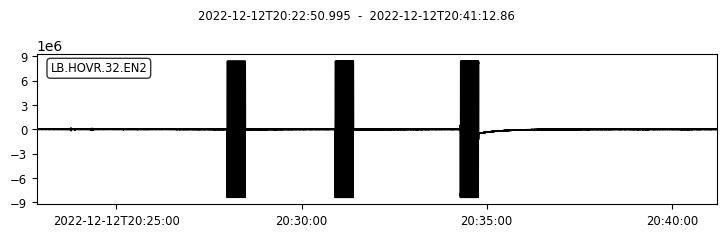

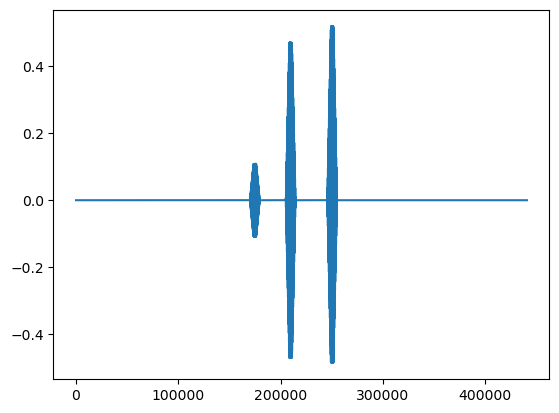

30891 0.5176833612865875


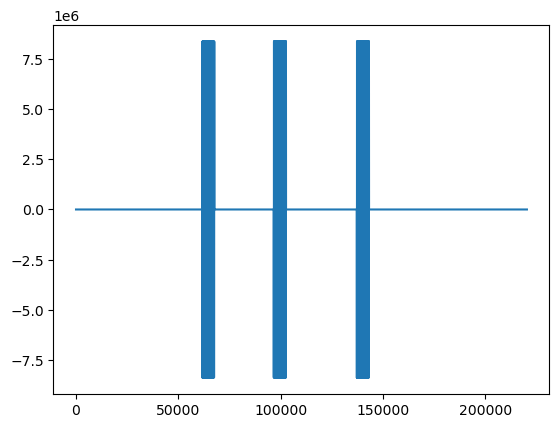

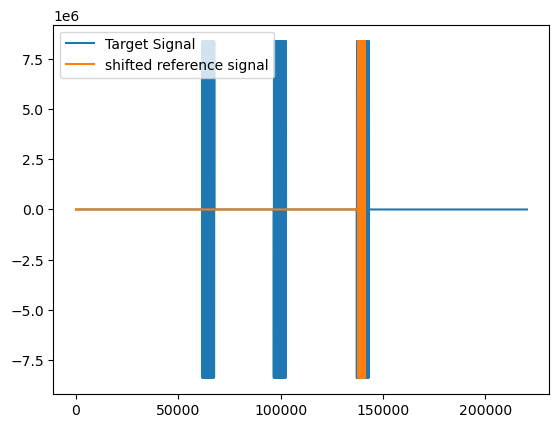

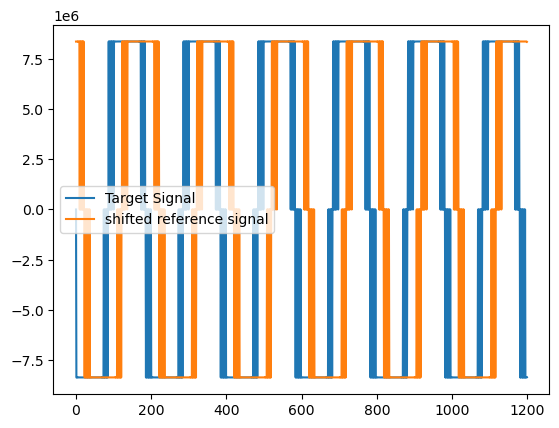

2 Trace(s) in Stream:
LB.HOVR.30.ENZ | 2022-12-09T20:52:28.450000Z - 2022-12-09T20:56:41.995000Z | 200.0 Hz, 50710 samples
LB.HOVR.30.ENZ | 2022-12-09T20:57:10.000000Z - 2022-12-09T21:00:00.225000Z | 200.0 Hz, 34046 samples
0.057354486991582534
5 Trace(s) in Stream:
LB.HOVR.30.ENZ | 2022-12-09T21:00:00.230000Z - 2022-12-09T21:02:46.995000Z | 200.0 Hz, 33354 samples
LB.HOVR.30.ENZ | 2022-12-09T21:07:02.000000Z - 2022-12-09T21:10:45.995000Z | 200.0 Hz, 44800 samples
LB.HOVR.30.ENZ | 2022-12-09T21:18:42.000000Z - 2022-12-09T21:19:18.995000Z | 200.0 Hz, 7400 samples
LB.HOVR.30.ENZ | 2022-12-09T21:23:23.000000Z - 2022-12-09T21:24:29.995000Z | 200.0 Hz, 13400 samples
LB.HOVR.30.ENZ | 2022-12-09T21:28:14.000000Z - 2022-12-09T21:34:01.080000Z | 200.0 Hz, 69417 samples
0.013070009530636785
1 Trace(s) in Stream:
LB.HOVR.32.ENZ | 2022-12-12T20:22:50.545000Z - 2022-12-12T20:41:12.820000Z | 200.0 Hz, 220456 samples
0.5342575260263531


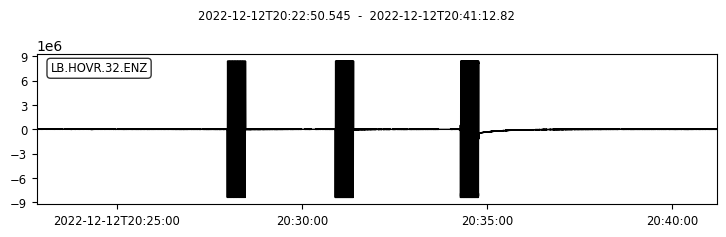

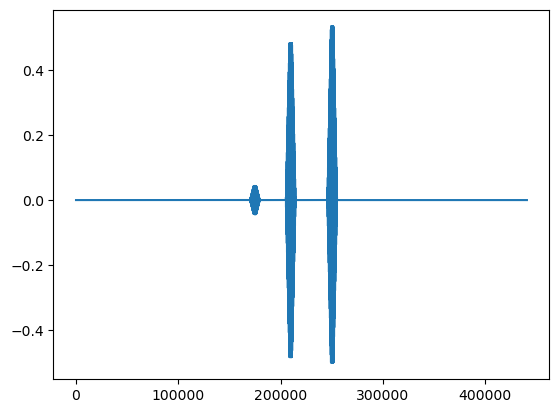

30545 0.5342575260263531


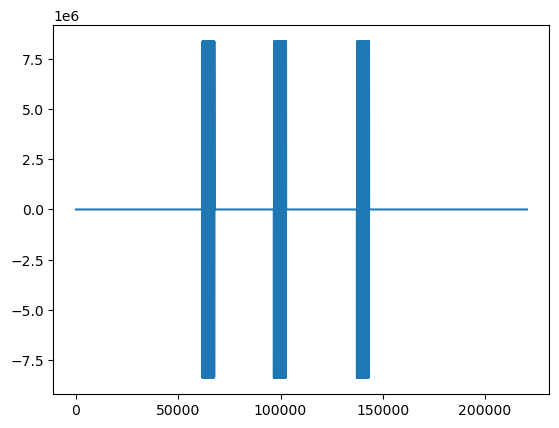

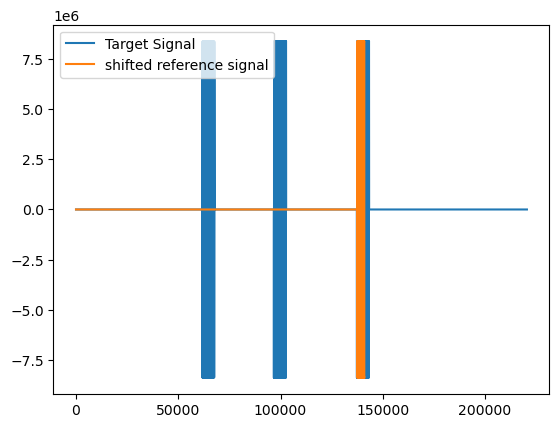

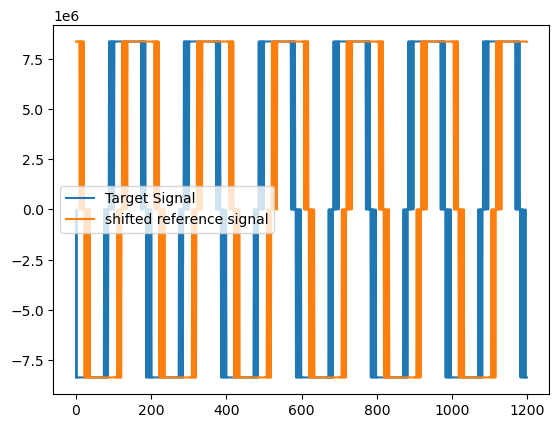

2 Trace(s) in Stream:
LB.HOVR1.40.EN1 | 2022-12-12T21:29:44.185000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108563 samples
LB.HOVR1.40.EN1 | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:14.650000Z | 200.0 Hz, 101331 samples
0.5954795319268156


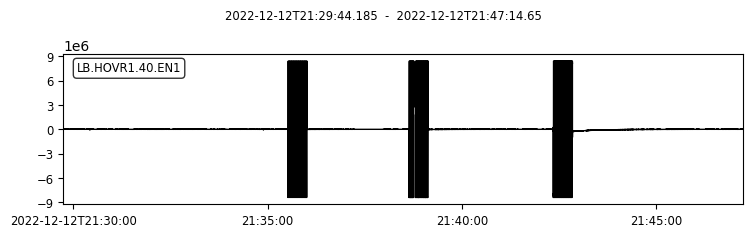

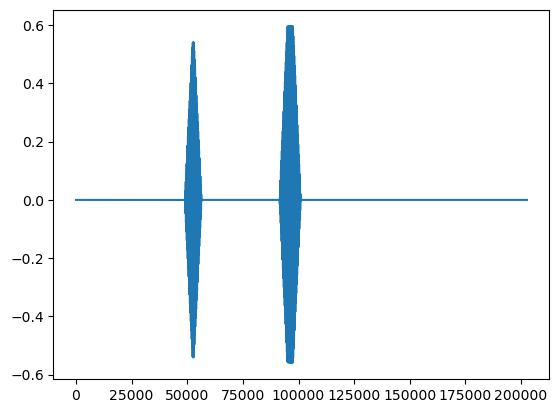

-3851.5 0.5954795319268156


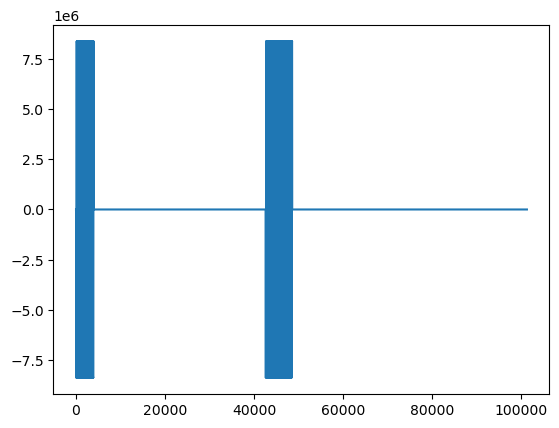

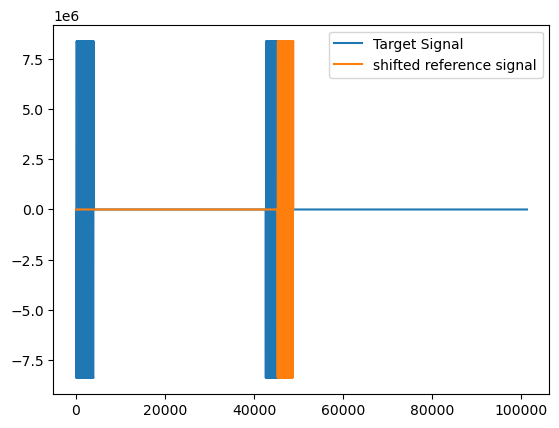

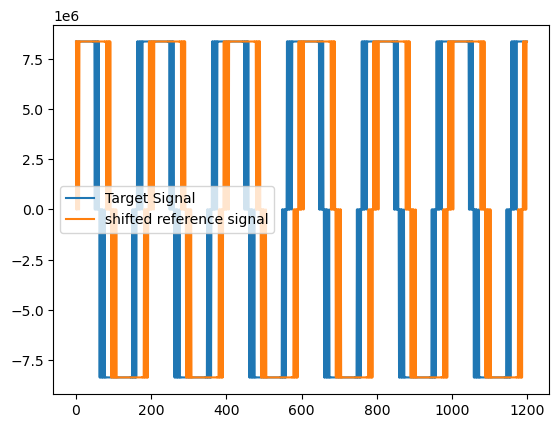

2 Trace(s) in Stream:
LB.HOVR1.40.EN2 | 2022-12-12T21:29:44.205000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108559 samples
LB.HOVR1.40.EN2 | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:14.270000Z | 200.0 Hz, 101255 samples
0.5961403854098539


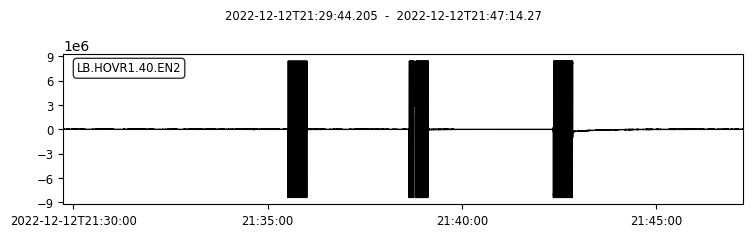

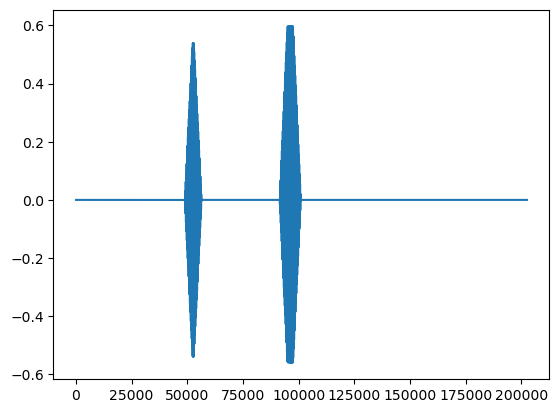

-3813.5 0.5961403854098539


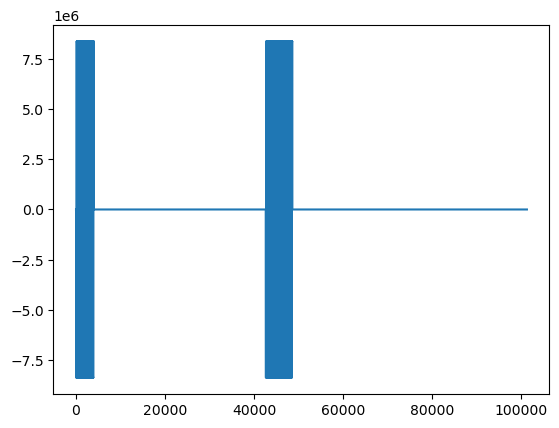

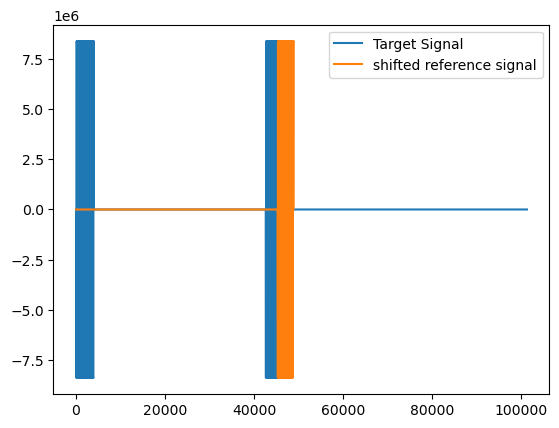

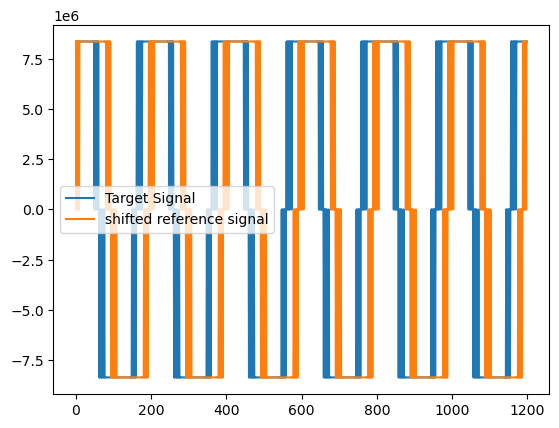

2 Trace(s) in Stream:
LB.HOVR1.40.ENZ | 2022-12-12T21:29:44.160000Z - 2022-12-12T21:38:46.995000Z | 200.0 Hz, 108568 samples
LB.HOVR1.40.ENZ | 2022-12-12T21:38:48.000000Z - 2022-12-12T21:47:13.865000Z | 200.0 Hz, 101174 samples
0.5959422137815023


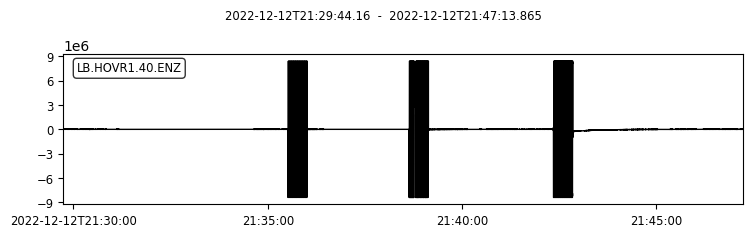

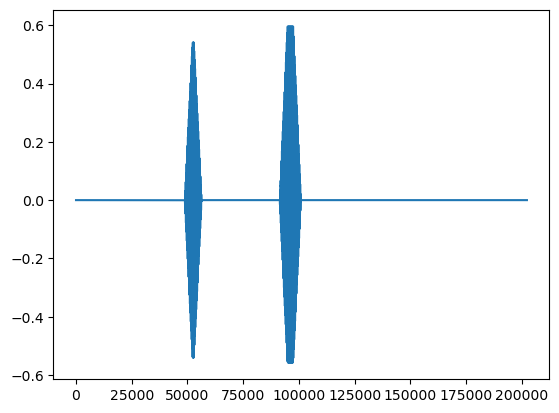

-3774 0.5959422137815023


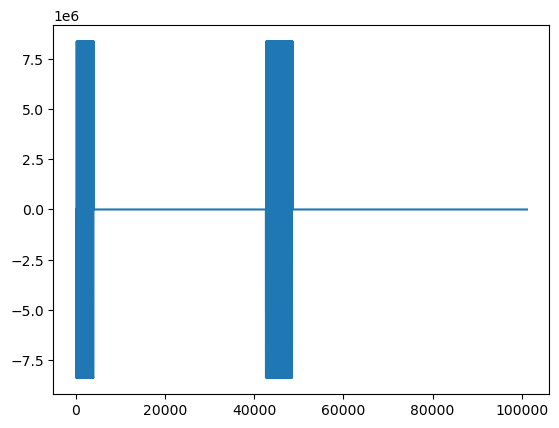

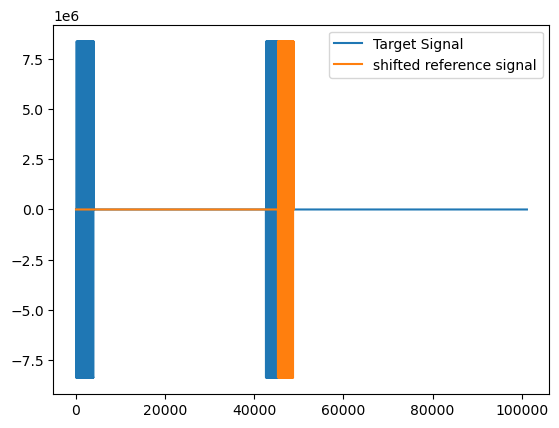

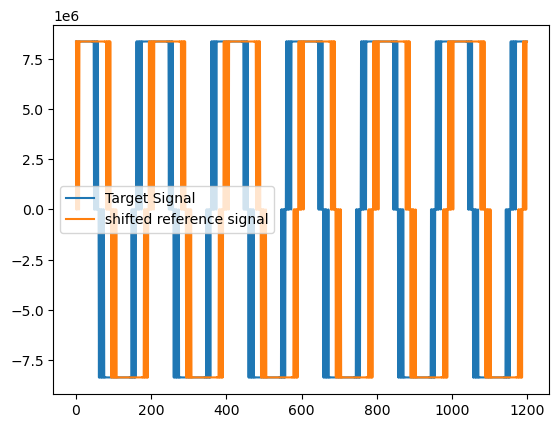

2 Trace(s) in Stream:
LB.HOVR3.32.EN1 | 2022-12-12T19:31:11.300000Z - 2022-12-12T19:36:14.995000Z | 200.0 Hz, 60740 samples
LB.HOVR3.32.EN1 | 2022-12-12T19:38:29.000000Z - 2022-12-12T19:50:17.505000Z | 200.0 Hz, 141702 samples
0.018548390262135846
2 Trace(s) in Stream:
LB.HOVR3.32.EN2 | 2022-12-12T19:31:11.905000Z - 2022-12-12T19:36:14.995000Z | 200.0 Hz, 60619 samples
LB.HOVR3.32.EN2 | 2022-12-12T19:38:29.000000Z - 2022-12-12T19:50:18.055000Z | 200.0 Hz, 141812 samples
0.539762443405096


C:\Users\lmazza\AppData\Local\Temp\3\ipykernel_18824\1590243472.py:45: RuntimeWarning:

invalid value encountered in sqrt



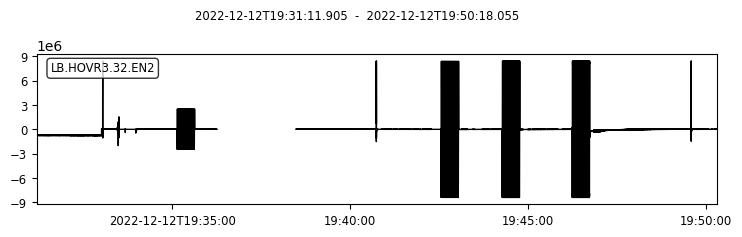

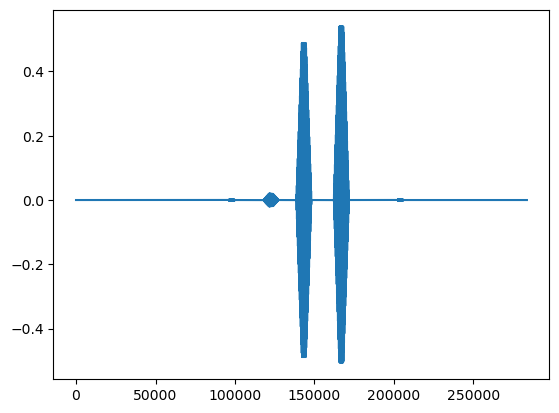

25647 0.539762443405096


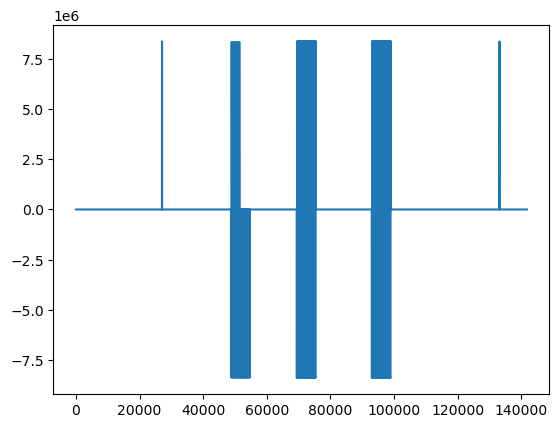

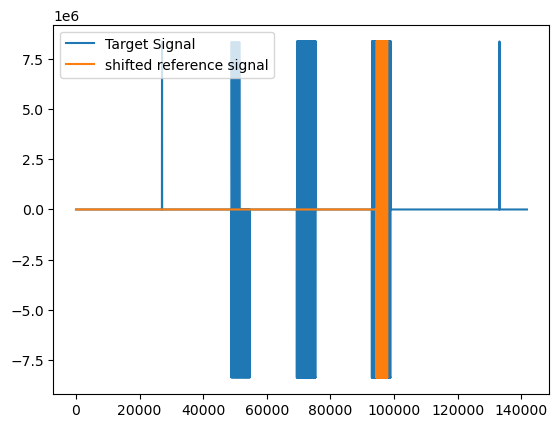

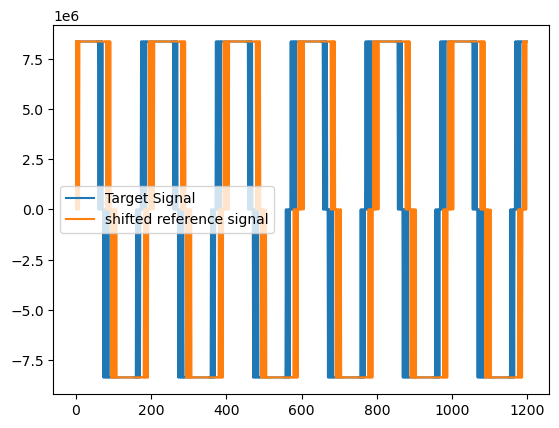

1 Trace(s) in Stream:
LB.HOVR4.42.EN1 | 2022-12-12T22:10:27.375000Z - 2022-12-12T22:25:40.535000Z | 200.0 Hz, 182633 samples
0.5103148082184948


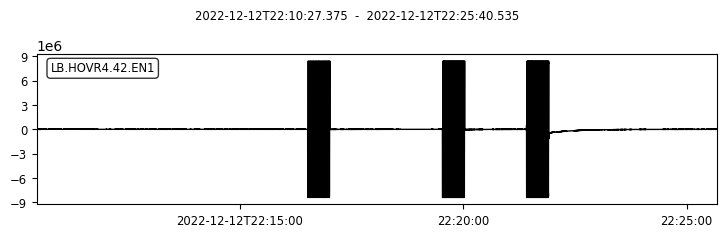

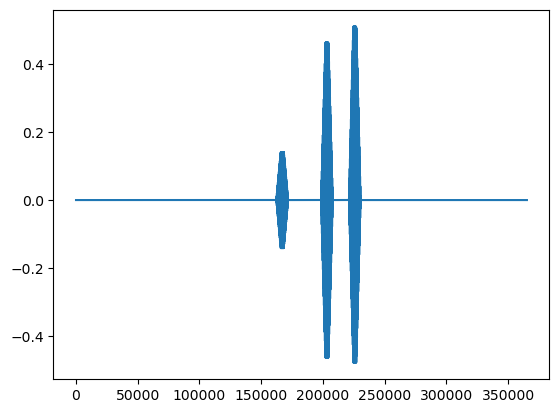

42083.5 0.5103148082184948


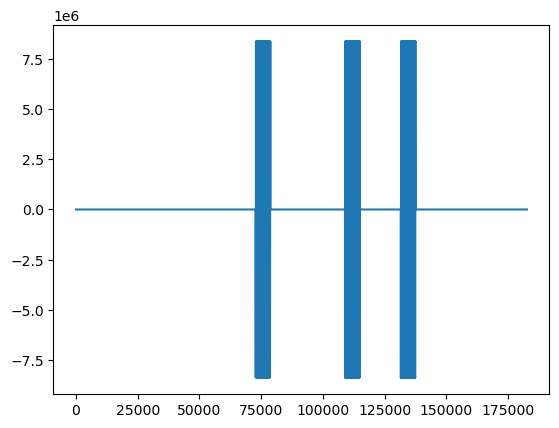

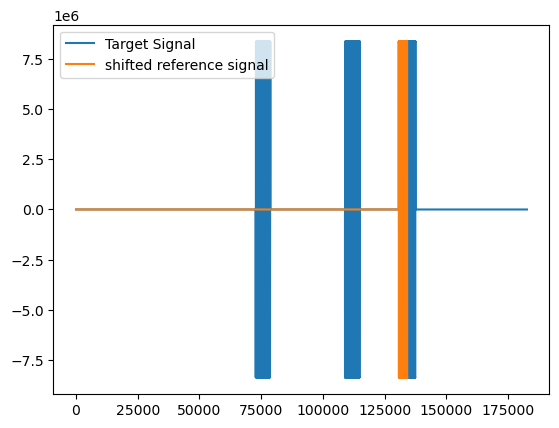

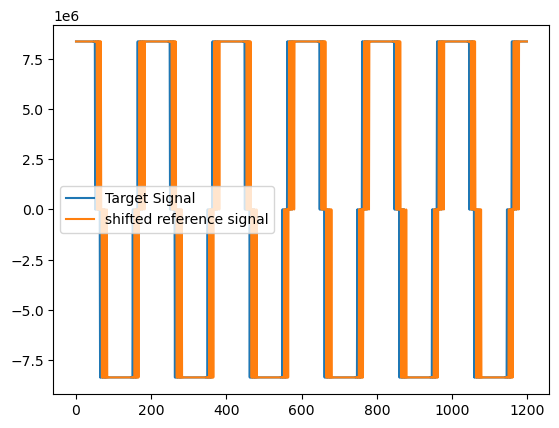

1 Trace(s) in Stream:
LB.HOVR4.42.EN2 | 2022-12-12T22:10:26.365000Z - 2022-12-12T22:25:40.330000Z | 200.0 Hz, 182794 samples
0.5124739429223661


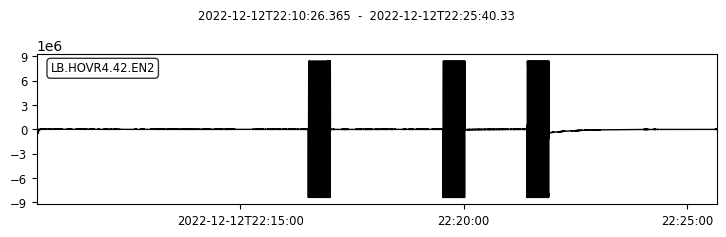

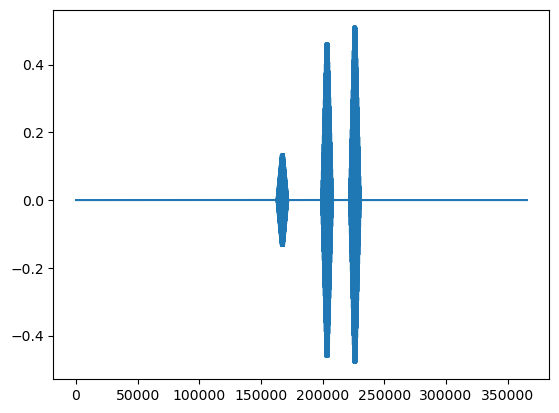

42603 0.5124739429223661


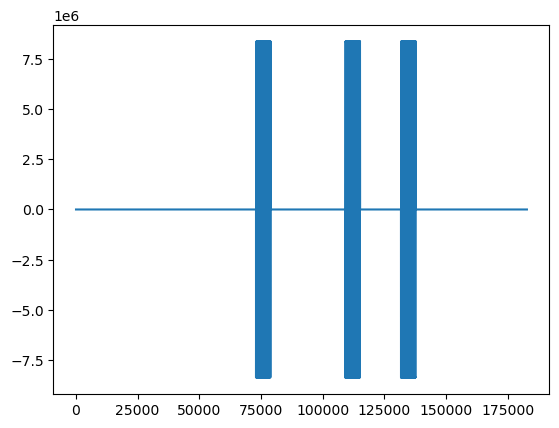

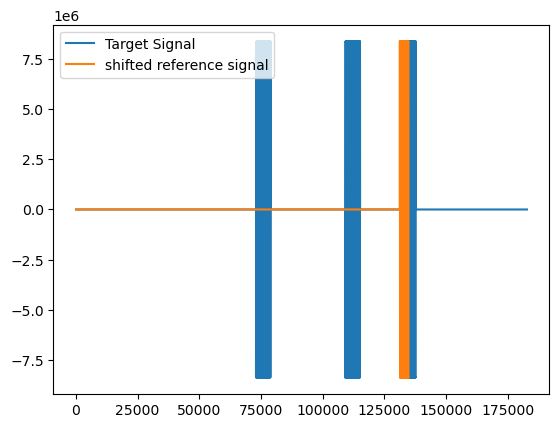

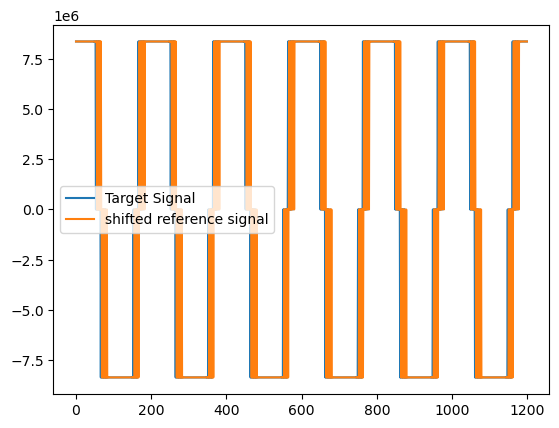

1 Trace(s) in Stream:
LB.HOVR4.42.ENZ | 2022-12-12T22:10:26.080000Z - 2022-12-12T22:25:40.095000Z | 200.0 Hz, 182804 samples
0.5142888259398617


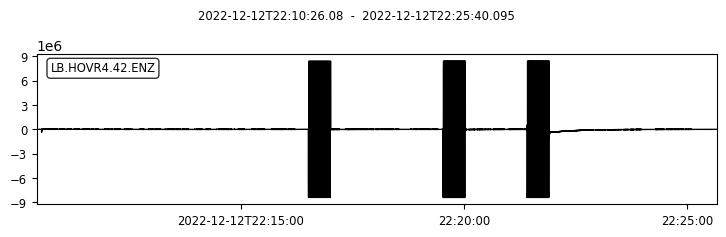

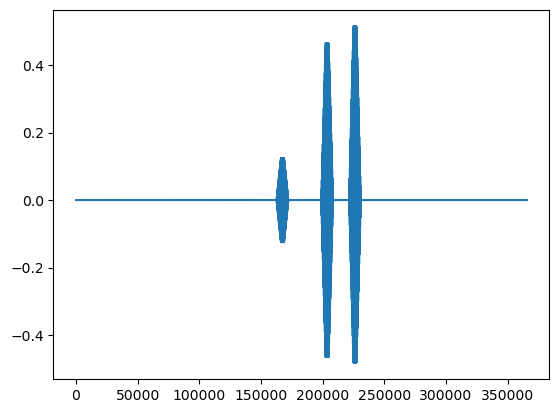

42656 0.5142888259398617


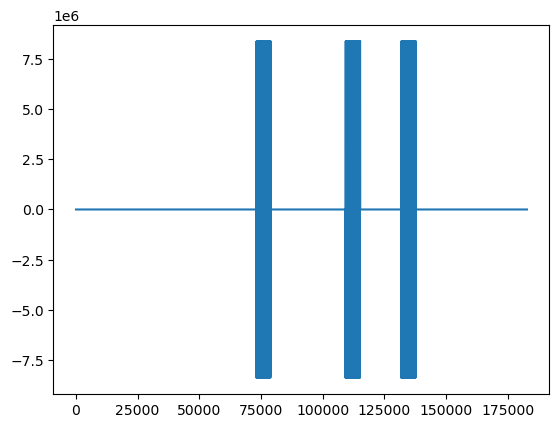

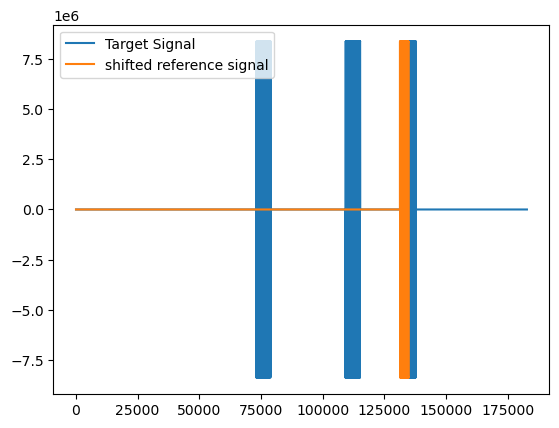

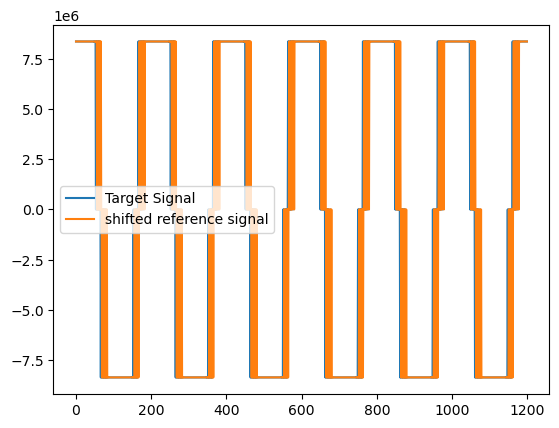

2 Trace(s) in Stream:
LB.HOVR5.50.EN1 | 2022-12-13T17:11:54.385000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58323 samples
LB.HOVR5.50.EN1 | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.615000Z | 200.0 Hz, 120324 samples
0.4833995807369546


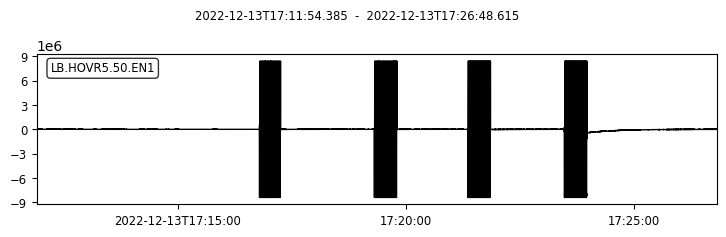

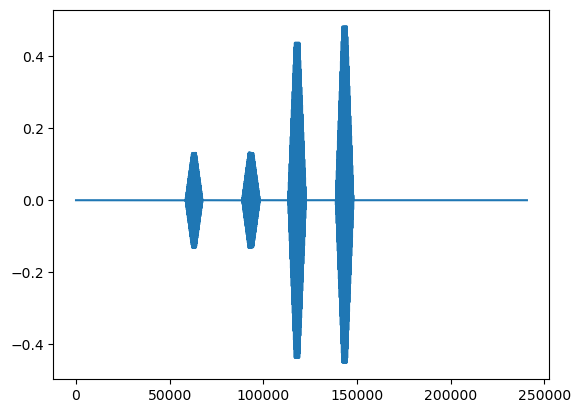

23080 0.4833995807369546


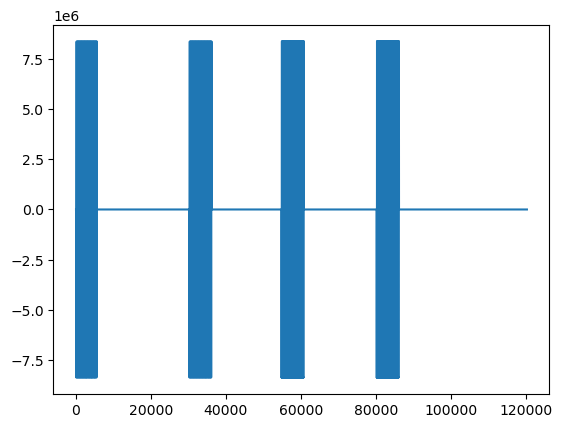

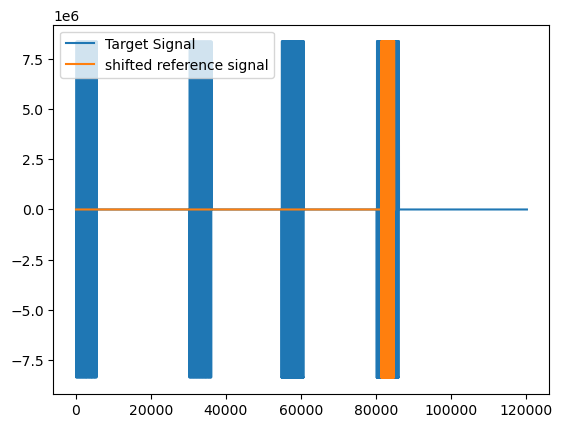

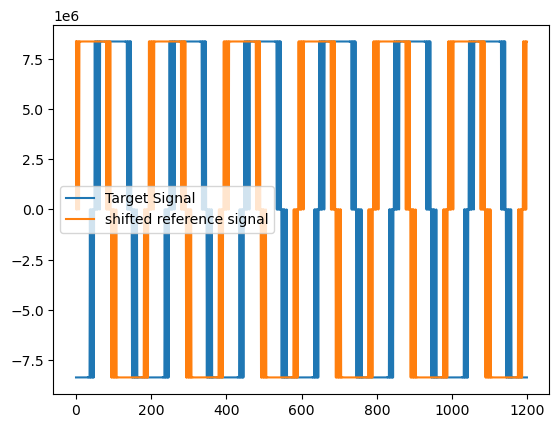

2 Trace(s) in Stream:
LB.HOVR5.50.EN2 | 2022-12-13T17:11:54.360000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58328 samples
LB.HOVR5.50.EN2 | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.295000Z | 200.0 Hz, 120260 samples
0.4828242966228857


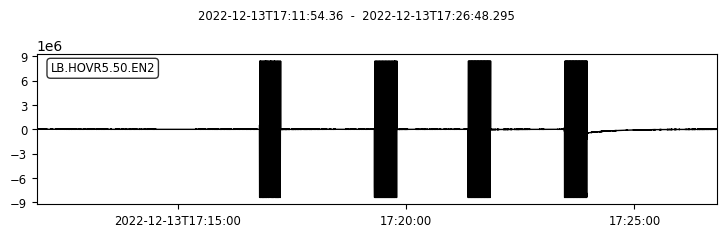

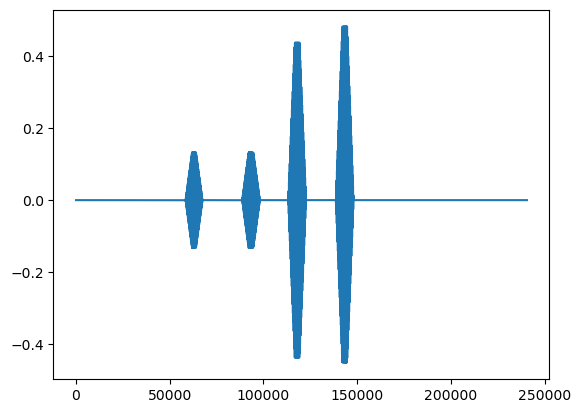

23512 0.4828242966228857


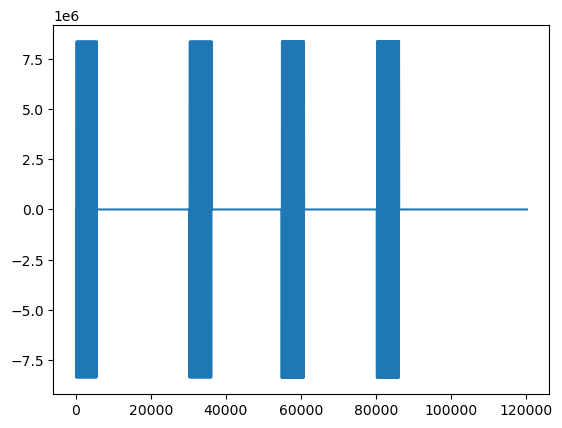

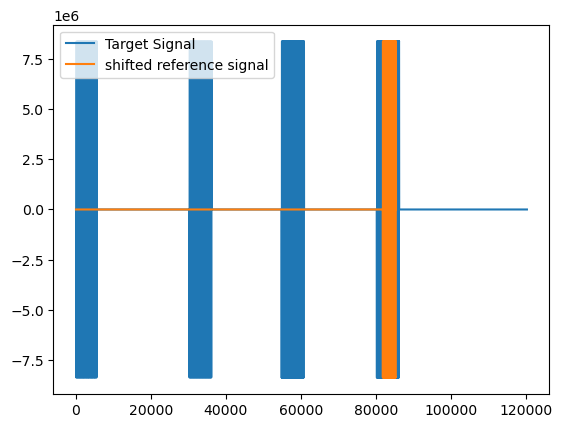

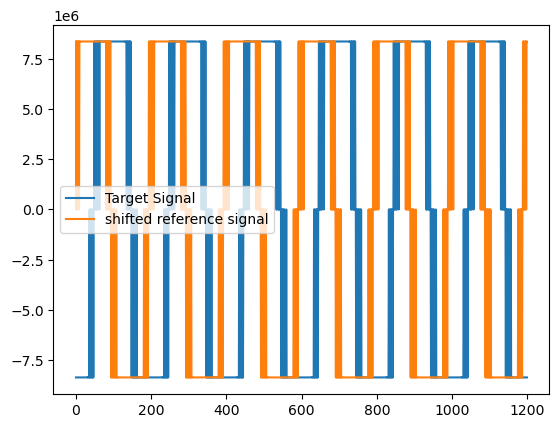

2 Trace(s) in Stream:
LB.HOVR5.50.ENZ | 2022-12-13T17:11:54.345000Z - 2022-12-13T17:16:45.995000Z | 200.0 Hz, 58331 samples
LB.HOVR5.50.ENZ | 2022-12-13T17:16:47.000000Z - 2022-12-13T17:26:48.540000Z | 200.0 Hz, 120309 samples
0.4816723232704213


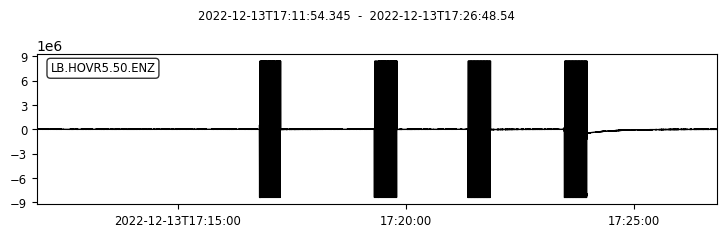

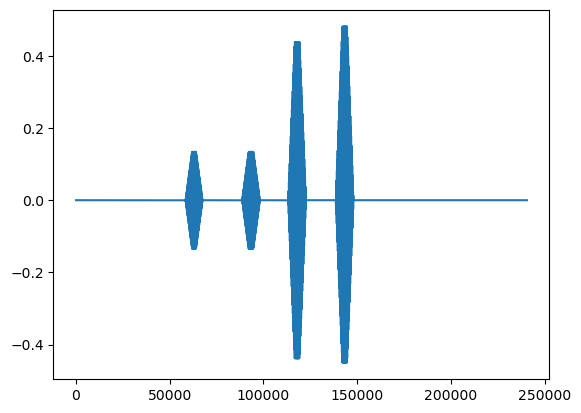

23089.5 0.4816723232704213


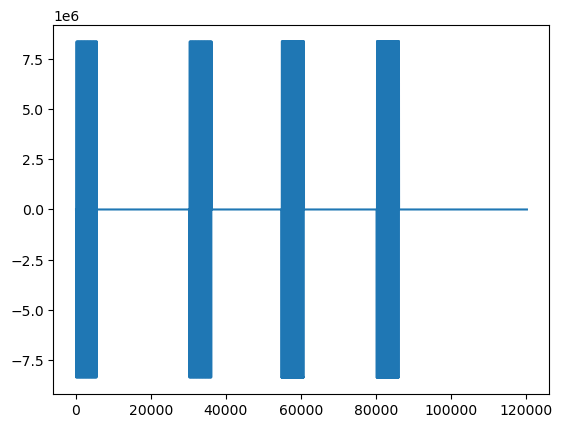

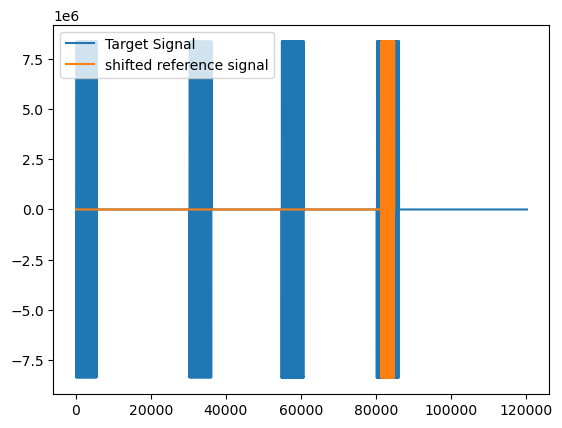

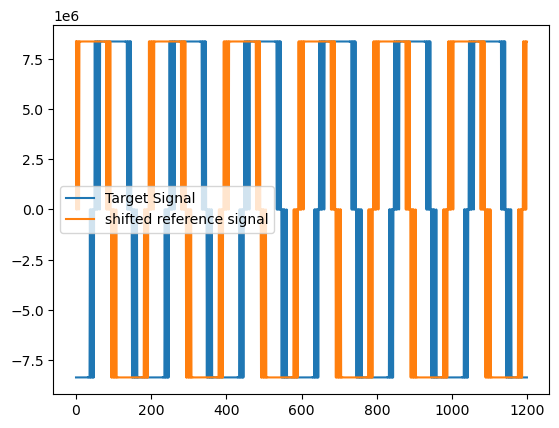

1 Trace(s) in Stream:
LB.HOVR6.52.EN1 | 2022-12-13T16:22:31.250000Z - 2022-12-13T16:40:59.320000Z | 200.0 Hz, 221615 samples
0.5461911862104435


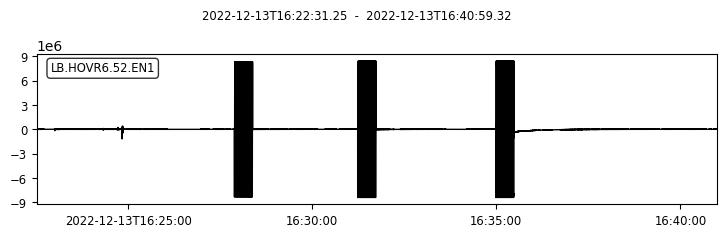

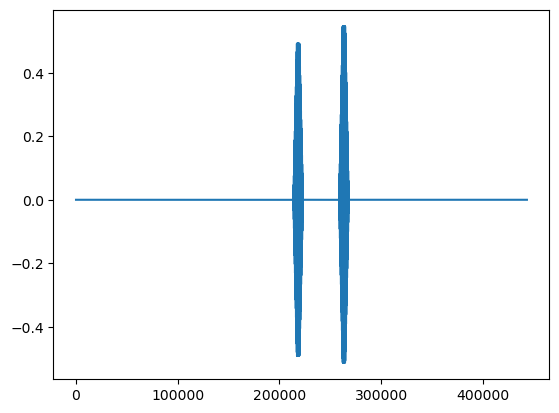

41111.5 0.5461911862104435


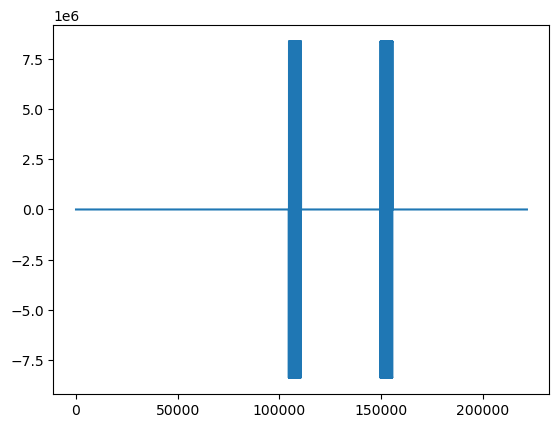

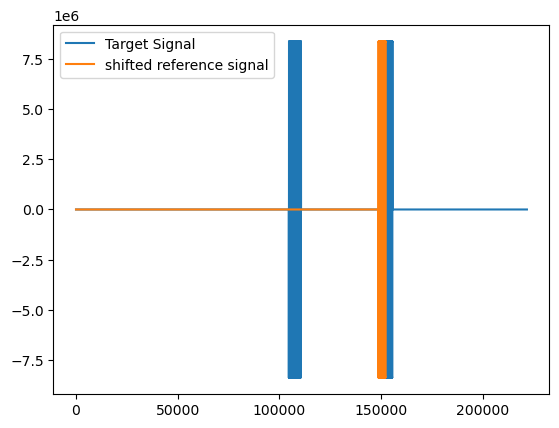

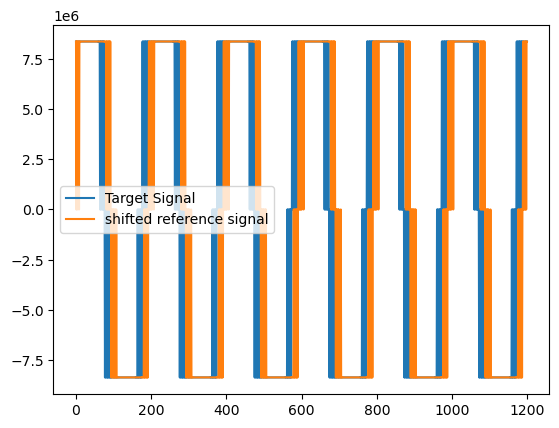

1 Trace(s) in Stream:
LB.HOVR6.52.EN2 | 2022-12-13T16:22:31.280000Z - 2022-12-13T16:40:59.125000Z | 200.0 Hz, 221570 samples
0.5427051411642255


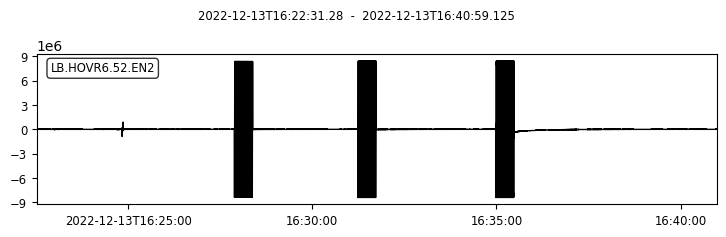

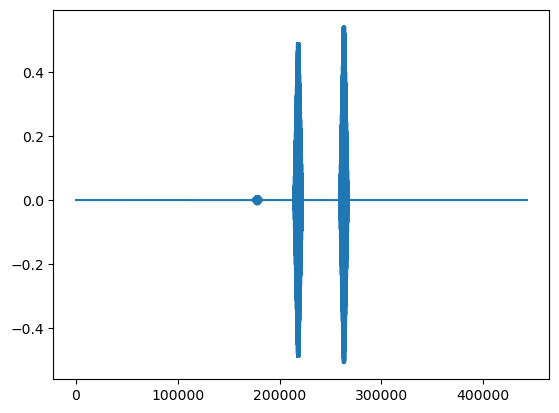

41126 0.5427051411642255


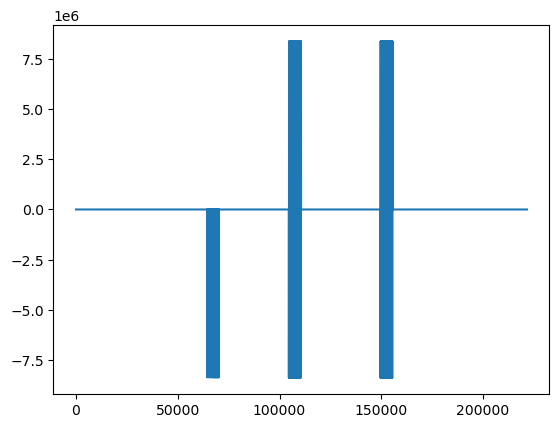

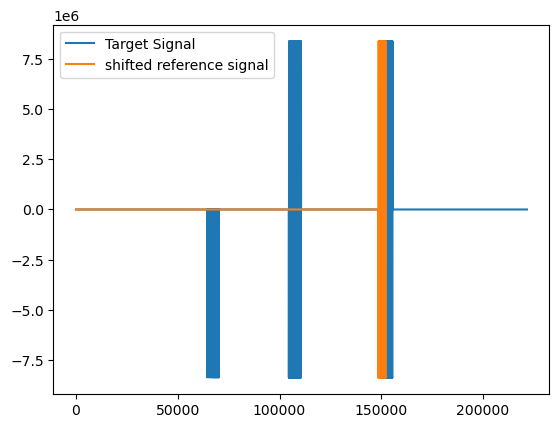

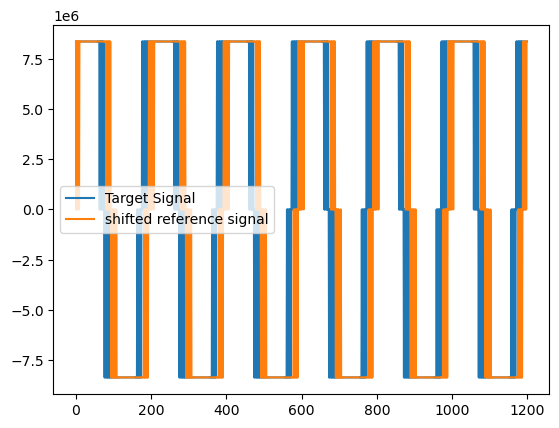

1 Trace(s) in Stream:
LB.HOVR6.52.ENZ | 2022-12-13T16:22:31.280000Z - 2022-12-13T16:40:58.950000Z | 200.0 Hz, 221535 samples
0.5317085778831822


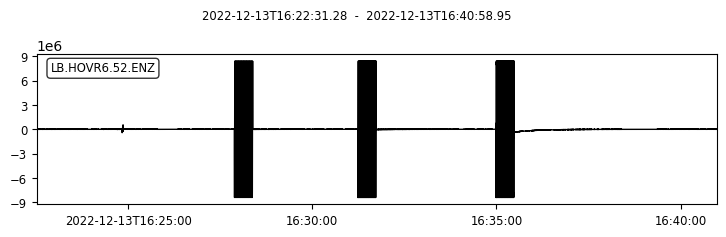

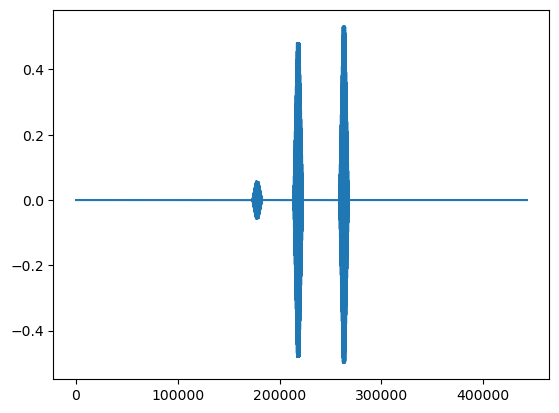

41142.5 0.5317085778831822


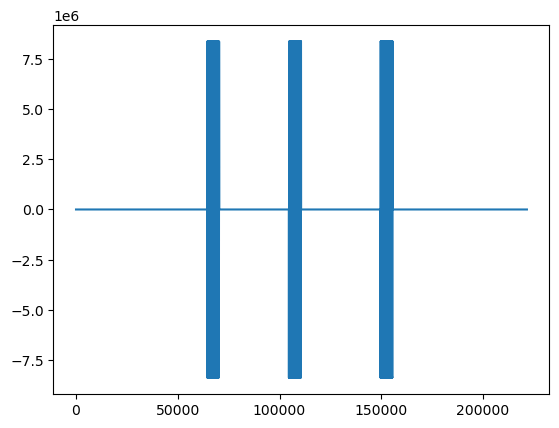

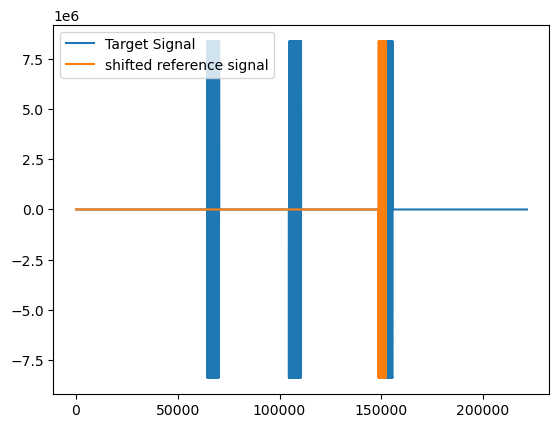

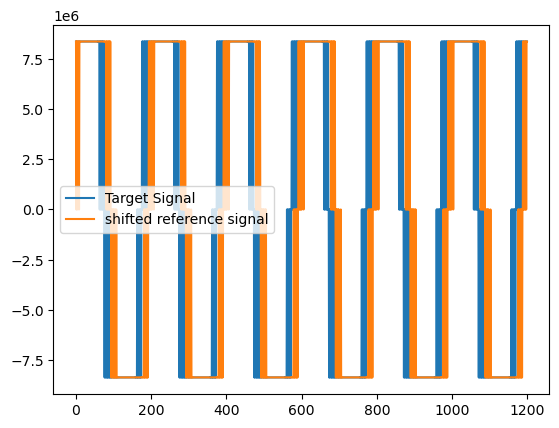

In [34]:
def get_atsensor_signals(station_dict):
    #Encode the top directory 
    directory = fse('Hoover_cals/HooverCals/Atsensorsite/')
    #List the Files of the Encoded directory
    storage = ld(directory)
    #Loop through all the entries in the Encoded Directory
    station_dict_atsens = {}
    station_dict_atlog = {}
    for dir in storage:
        #Decode the directory and encode its contents
        sig_list_log = []
        sig_list_sens = []
        file = fsd(dir)
        #Failsafe for if the user forgets to delete HOVR2 from the atlogger dictionary
        if file == 'HOVR2':
            continue
        new_dir = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}')
        # Create a new list of the directory's encoded sub-directories
        new_storage = ld(new_dir)
        i = -1
        #Loop through the encoded contents of the most recently decoded directory
        for dir2 in new_storage:
            #Decode the most recently encoded directory. A pattern is Emerging here. Essentially, 
            #we follow this convention of encoding and decoding the filesystem until we reach all the sac files at the bottom 
            #of the Directory Tree. 
            file2 = fsd(dir2)
            if file2[0] != 'E' or (file == 'HOVR3' and i == 1): # ->EXP
                continue
            new_dir2 = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}')
            new_storage2 = ld(new_dir2)
            i+=1
            for dir3 in new_storage2:
                file3 = fsd(dir3)
                new_dir3 = fse(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}/{file3}')
                new_storage3 = ld(new_dir3)
                #We have finally reached the sac files we want to work with. Let's perform some operations 
                for sac_file in new_storage3: 
                    #Read in the data from the sac file using Obspy 
                    sac_obs = fsd(sac_file)
                    st = read(f'Hoover_cals/HooverCals/Atsensorsite/{file}/{file2}/{file3}/{sac_obs}')
                    print(st)
                    if len(st) != 1:
                        dominant_trace = st[0]
                        for tr in st[1:]:
                            if sqrt(mean(square(tr.data))) > sqrt(mean(square(dominant_trace.data))):
                                dominant_trace = tr
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        #Different process for accessing the correlation waveforms with atlogger. 
                        cc = correlate(good_info,station_dict[f'{file}'][i],len(good_info))
                    else:
                        dominant_trace = st[0]
                        info = dominant_trace.data
                        threshold = np.max(info) - 30000 # ->EXP
                        good_info = np.where(np.abs(info) >= threshold, info, info*0)
                        x = np.arange(0,len(info))
                        cc = correlate(good_info,station_dict[f'{file}'][i],len(good_info))
                    print(np.max(cc))
                    if np.max(cc) > 0.1:
                        st.plot()
                        plt.plot(cc)
                        plt.show()
                        shift,correlation_value = xcorr_max(cc)
                        print(shift,correlation_value)
                        #Slightly different routine for the add_on derivation
                        if len(info) < 1e5:
                            add_on = len(cc)*0.215
                        else:
                            add_on = len(cc)*0.2425
                        check = np.concatenate((np.zeros(np.abs(int(shift+add_on))),station_dict[f'{file}'][i])) # ->EXP
                        plt.plot(good_info)
                        plt.show()
                        plt.plot(good_info)
                        plt.plot(check)
                        plt.legend(['Target Signal','shifted reference signal'])
                        plt.show()
                        #Different indexing routine for plotting and saving the aligned waveforms. 
                        if shift > 0:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.plot(check[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        else:
                            midpoint = check.argmax()
                            plt.plot(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.plot(check[midpoint+1000:midpoint+2200]) # ->EXP
                            plt.legend(['Target Signal','shifted reference signal'])
                            plt.show()
                        sig_list_sens.append(good_info[midpoint+1000:midpoint+2200]) # ->EXP
                        sig_list_log.append(check[midpoint+1000:midpoint+2200]) # ->EXP
        station_dict_atsens[f'{file}'] = sig_list_sens
        station_dict_atlog[f'{file}'] = sig_list_log
    return(station_dict_atsens,station_dict_atlog)
station_dict_atsens,station_dict_atlog = get_atsensor_signals(station_dict)

HOVR produced an additional, uneccessary data array for one of its channels. Let's remove it

In [35]:
del station_dict_atlog['HOVR'][2] # ->EXP
del station_dict_atsens['HOVR'][2] # ->EXP
station_dict_atlog

{'HOVR': [array([8384894., 8388607., 8387350., ..., 8382639., 8388607., 8370614.]),
  array([8384906., 8388607., 8387401., ..., 8382582., 8388607., 8370650.]),
  array([8384901., 8388607., 8387379., ..., 8382606., 8388607., 8370634.])],
 'HOVR1': [array([8388607.,       0., 8388607., ...,       0., 8388607., 8383132.]),
  array([8388607.,       0., 8388607., ...,       0., 8388607., 8383132.]),
  array([8388607.,       0., 8388607., ...,       0., 8388607., 8383325.])],
 'HOVR3': [array([8388607.,       0., 8388607., ...,       0., 8388607., 8382072.])],
 'HOVR4': [array([8388606., 8388606., 8388606., ..., 8388606., 8388606., 8388606.]),
  array([8388606., 8388606., 8388606., ..., 8388606., 8388606., 8388606.]),
  array([8388606., 8388606., 8388606., ..., 8388606., 8388606., 8388606.])],
 'HOVR5': [array([8388607.,       0., 8388607., ...,       0., 8388607., 8383325.]),
  array([8388607.,       0., 8388607., ...,       0., 8388607., 8383325.]),
  array([8388607.,       0., 8388607., .

# Manual Ratio modeling

### Now we're onto the good stuff! There will be two different conventions we follow with finding these spectral ratios. Some of these waveforms have interfering frequencies that make the spectral ratios innacurate and not able to be modeled. These include HOVR3 and HOVR4. Due to this, we will have to manually select points of a given waveform's fourier transform where a given frequency is the strongest. This will greatly simplify the signal while taking the least amount of important data out

In [12]:
#Extract two channel arrays from the dictinoaries and convert them to obspy traces. 
atlog_tr = Trace(station_dict_atsens['HOVR4'][1])
atsens_tr = Trace(station_dict_atlog['HOVR4'][1])
#Make a list containing all the traces and conver their sampling rates. 
tr_list = [atlog_tr,atsens_tr]
atlog_tr.stats.sampling_rate = 200
atsens_tr.stats.sampling_rate = 200

In [13]:
#Make a dictionary that will contain the coefficients from all the different stations we make our polynomial regression models with
ratio_dic_coefs = {}

In [14]:
#Make a list containing the polynomial regression coefficients for a given channel
coef_list = []

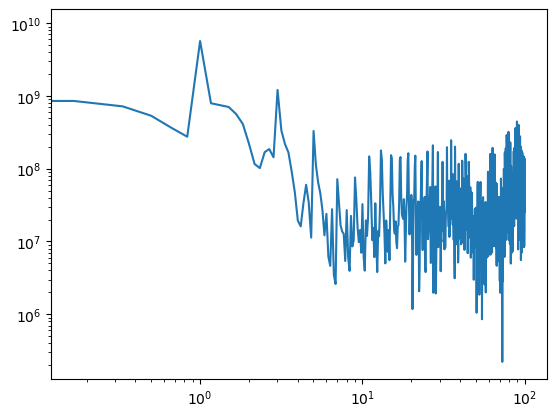

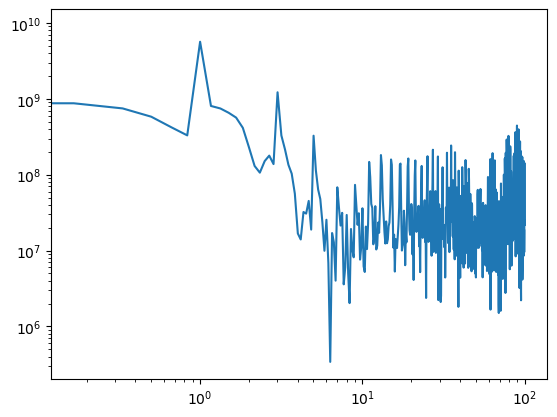

In [36]:
#The psd list will contain the data we will take the spectral ratios with
psd_list = []
#Loop through the trace list and take the irfourier transforms. Plot these using matplotlib and plotly 
for tr in tr_list:
    tr.detrend('demean') # ->EXP
    tr.detrend('simple') # ->EXP
    tr.taper(type='cosine',max_percentage=0.1,side='both') # ->EXP
    tr_fft = np.fft.fft(tr.data)
    fft00= len(tr_fft)
    if fft00 % 2 == 0:
        fftn2 = int(fft00/2)
    else:
        fftn2 = int((fft00-1)/2)
    df = tr.stats.sampling_rate
    df2 = int(df/2)
    tr_fft = tr_fft[0:fftn2]
    freq_axis = np.linspace(0,df2,fftn2)
    scale = 2.0/((fft00-1)*(fft00-1))
    tr_psd = scale*abs2(tr_fft)
    freq_axis = float64(freq_axis)
    tr_psd = float64(tr_psd)
    plt.loglog(freq_axis,np.abs(tr_fft))
    plt.show()
    fig = px.line(np.abs(tr_fft),log_x=True,log_y=True)
    fig.update_xaxes(range = [0.1,2.0])
    fig.show()
    #This line here must be adjusted based on the waveforms you are dealing with. Choose the first five highest peaks you see on your fourier transform.
    #You can use the plotly graph to decipher the indeces of the peaks. 
    psd_list.append([tr_fft[6],tr_fft[18],tr_fft[30],tr_fft[42],tr_fft[54]]) # ->EXP

## Now that we have truncated our signals and taken their fourier transforms, we are ready to take some spectral ratios! First, let's plot the ratio of atsensor/atlogger. Secondly, we will utilize numpy's 2nd degree polynomial regression to model the ratio. 

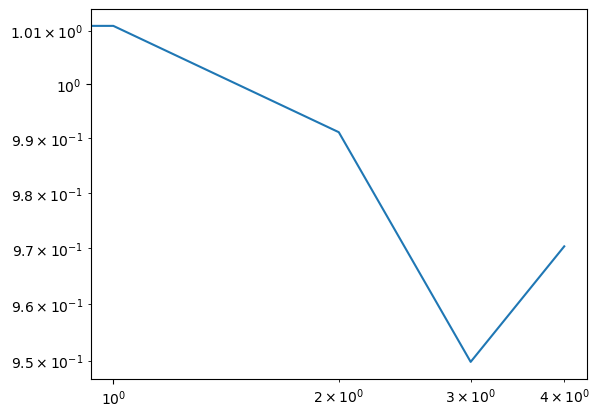

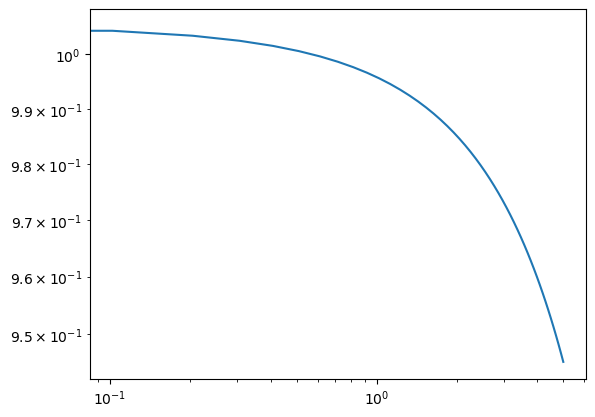

In [37]:
#Take the spectral ratio of the atsesnor/atlogger absolute value fourier transforms and plot them on a log-scale graph. 
ratio = np.abs(np.array(psd_list[1]))/np.abs(np.array(psd_list[0]))
plt.loglog(ratio)
plt.show()
#Perform 2nd degree polynmial regression on the ratio. Plot it out. 
x = np.arange(0,len(ratio))
model = np.poly1d(np.polyfit(x,ratio,2)) # ->EXP
myline = np.linspace(0,len(ratio))
plt.loglog(myline, model(myline))
plt.show()

### Alright that looks pretty good! A sign of a good model in this case is a characteristic exponential drop-off towards the end of the plot. Let's wrap up by adding our list to the dictionary. This process can be repeated by running through the loop again and not updating the dictionaries/lists. 

In [17]:
coef_list.append(model.coefficients)

In [18]:
coef_list

[array([-0.00248324, -0.00527158,  1.00289225])]

In [19]:
ratio_dic_coefs['HOVR'] = coef_list

In [20]:
ratio_dic_coefs

{'HOVR': [array([-0.00248324, -0.00527158,  1.00289225])]}

# Automated Ratio Modeling

### The rest of the waveforms from HOVR, HOVR1, HOVR5, and HOVR6 will be easier to model compared to the previous few. We can apply an automated method for these spectral ratios and models similar to our alignment code. Let's walk through the spectral ratio finder function, which takes the atlogger and atsensor waveform dictionaries in as inputs. The output of a given station will be its coherence plot, which is a physical measurement of the similarity of the input signals. If the coherence hovers around 1 for a certain corresponding frequency for the ratios, the measurements have high physical validity. The next outputs will consist of an interactive spectral ratio plot as well as the modeled polynomial representing the ratio.

HOVR


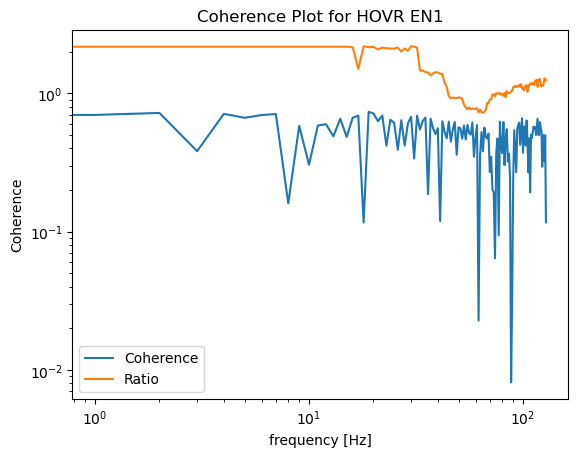

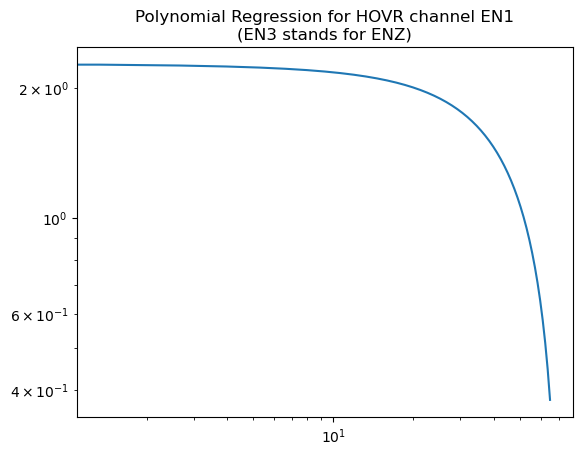

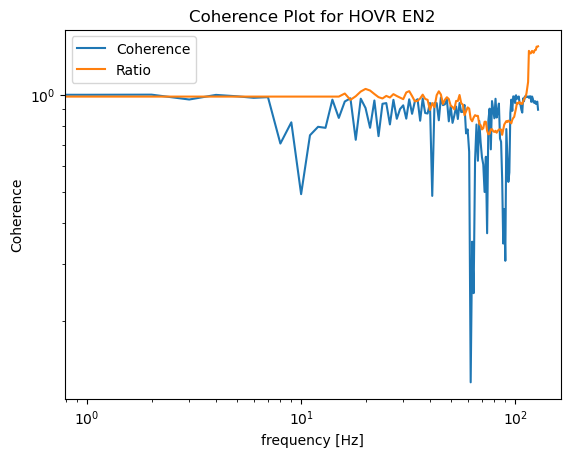

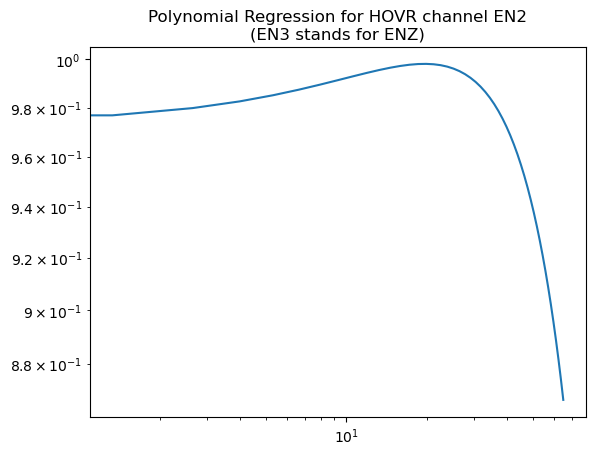

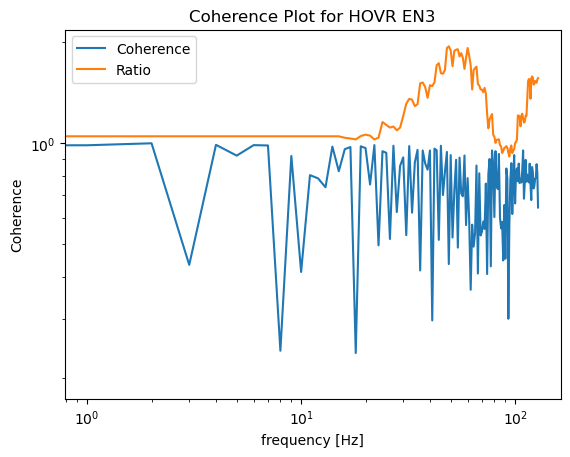

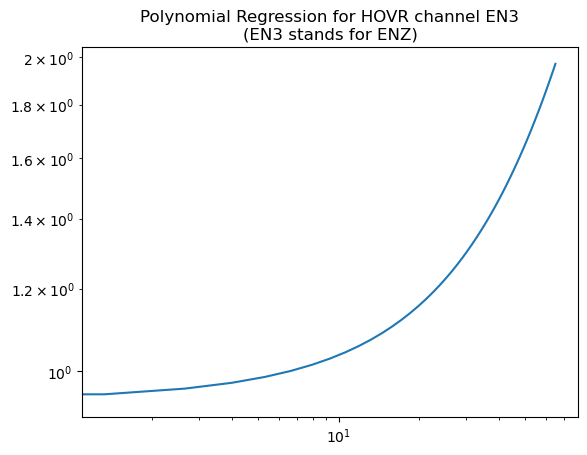

HOVR1


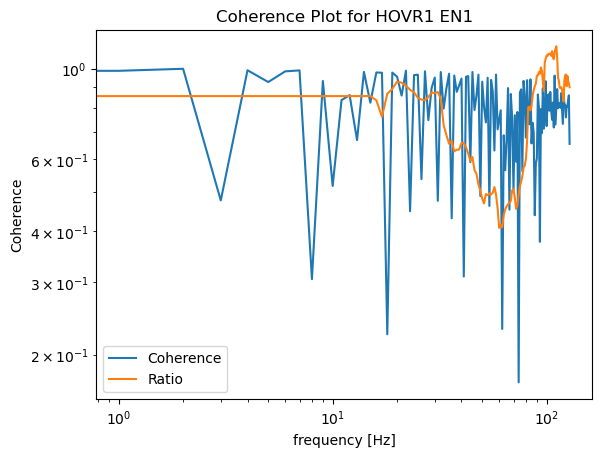

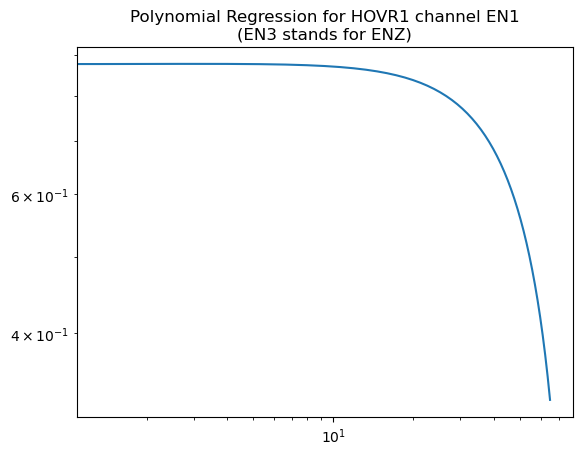

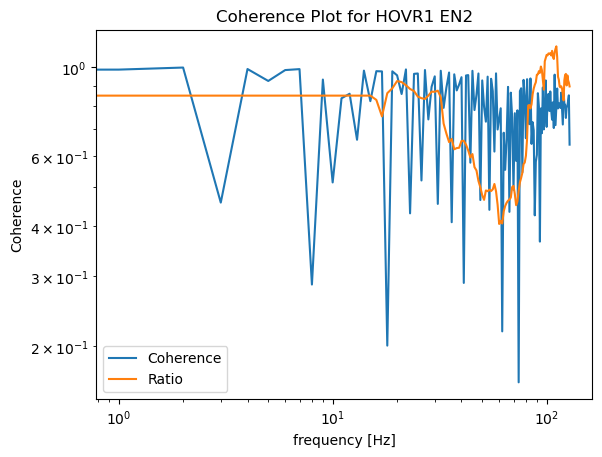

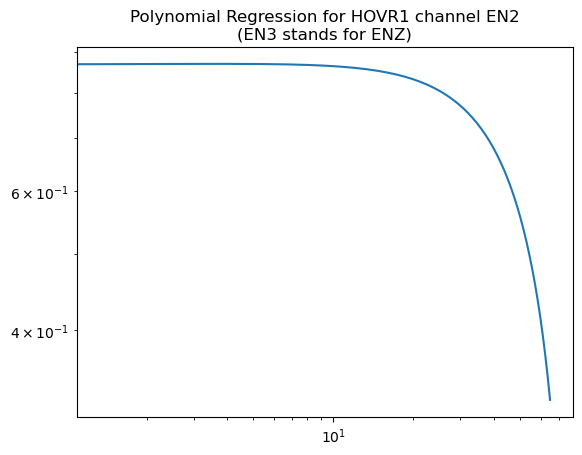

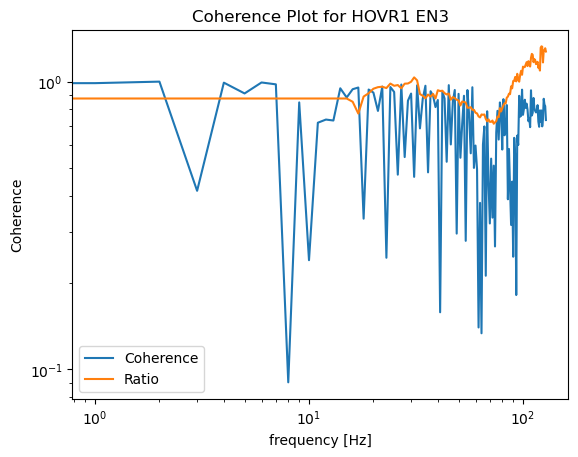

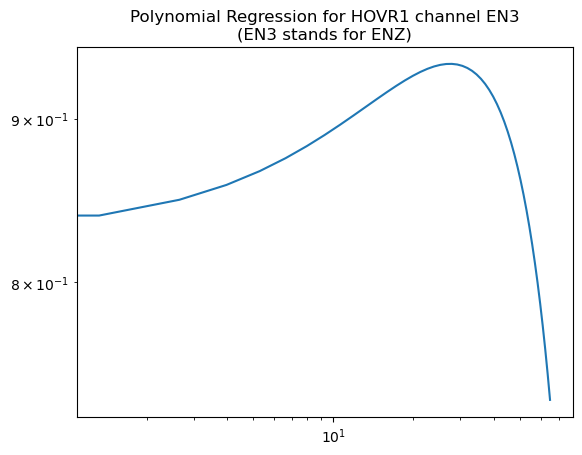

HOVR3


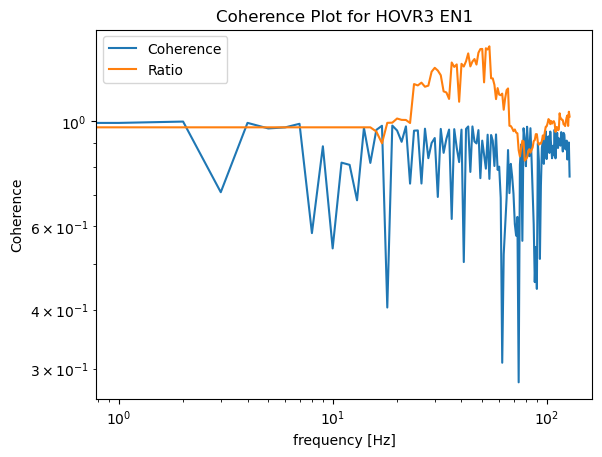

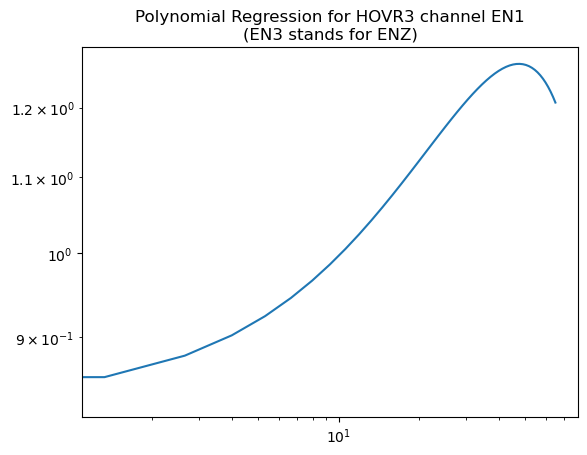

HOVR4


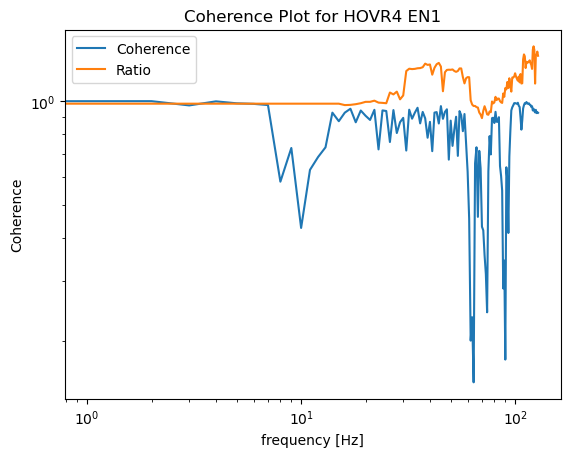

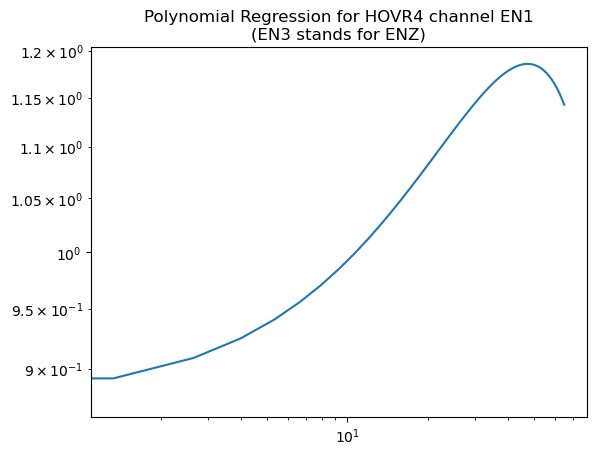

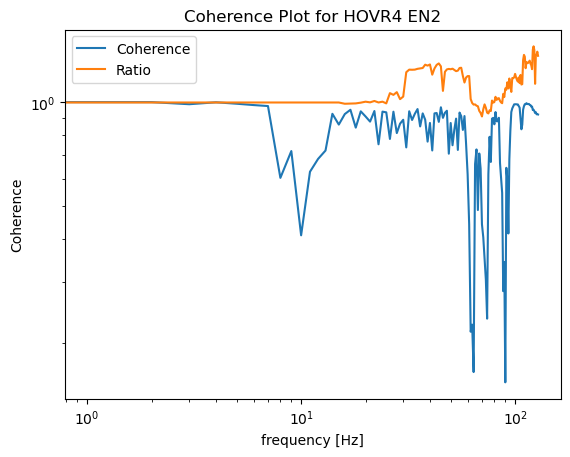

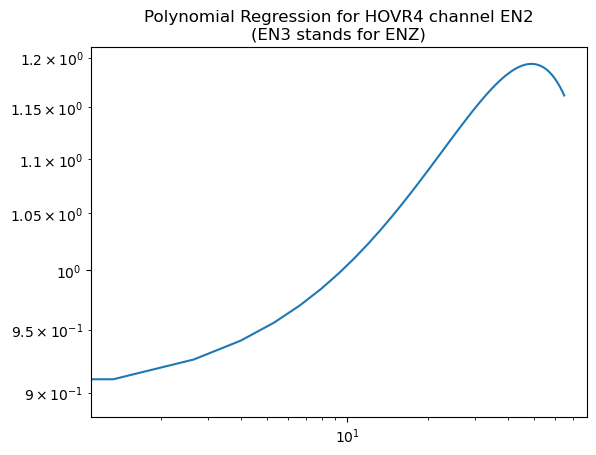

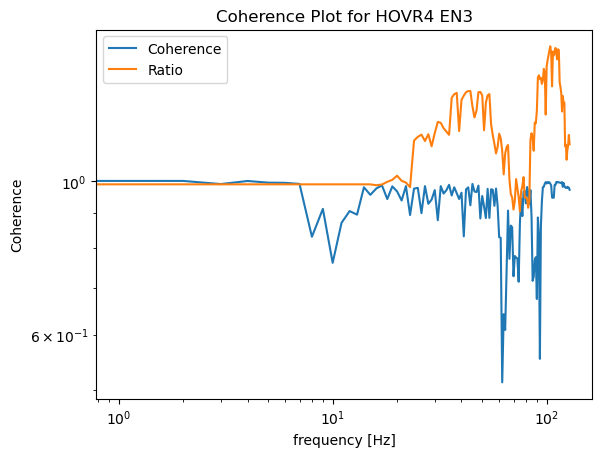

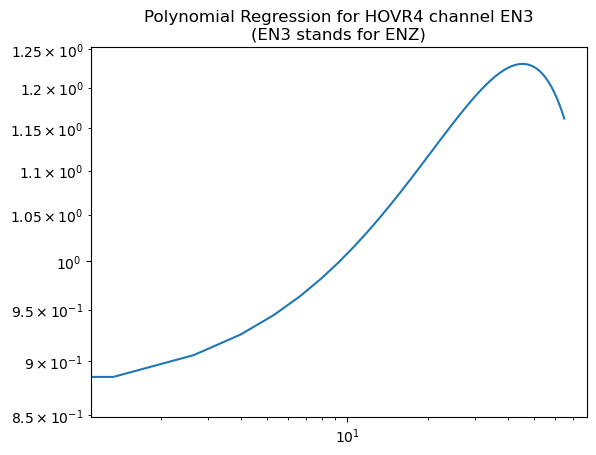

HOVR5


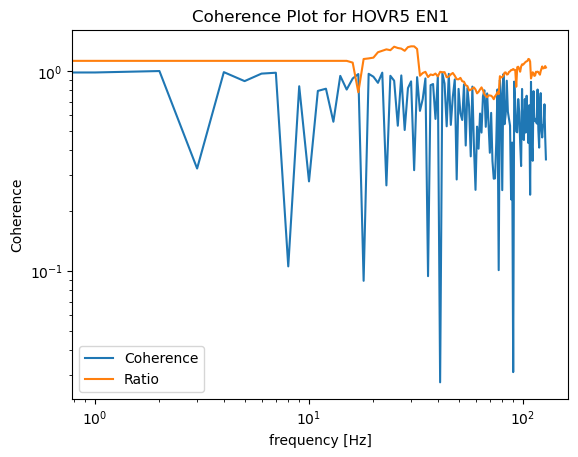

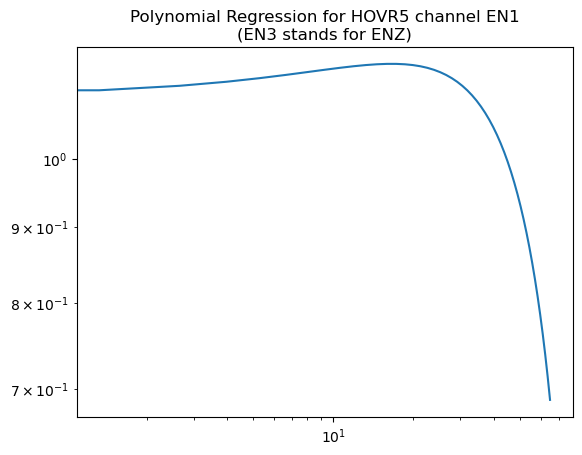

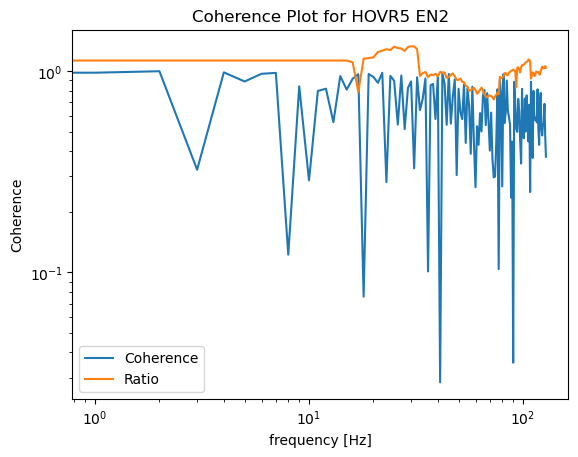

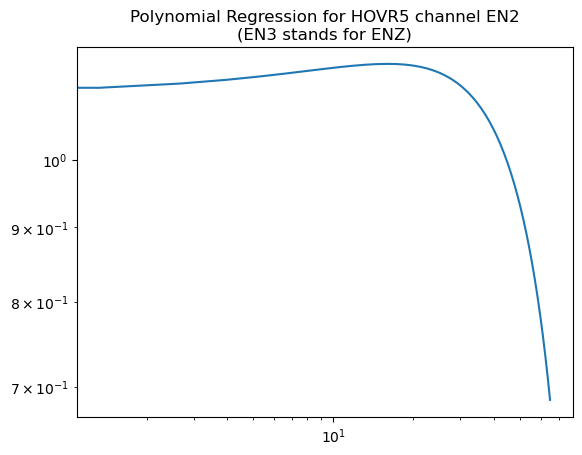

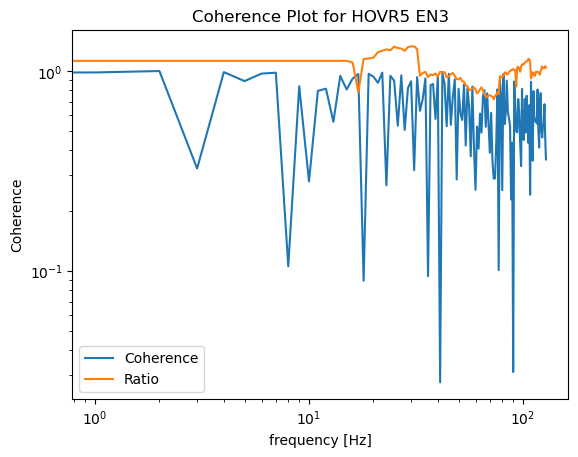

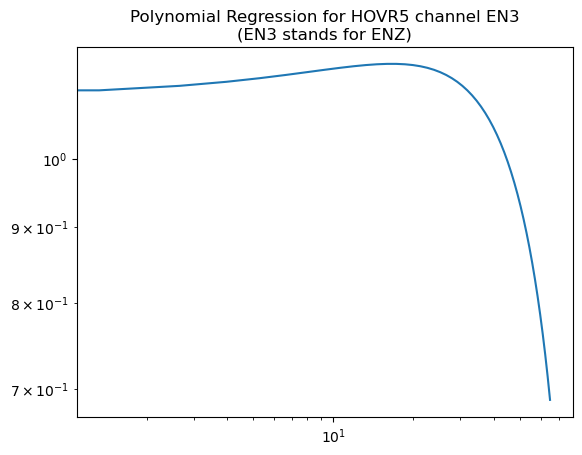

HOVR6


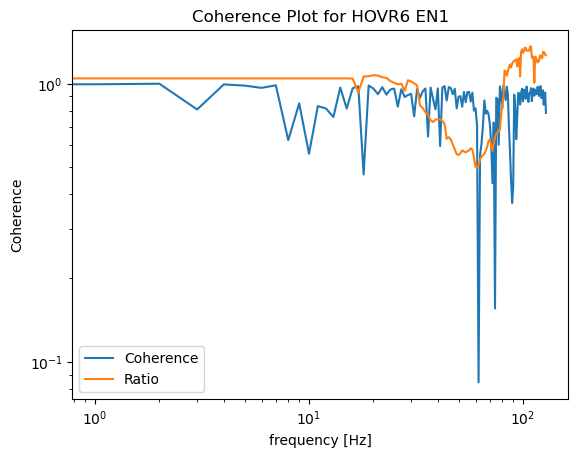

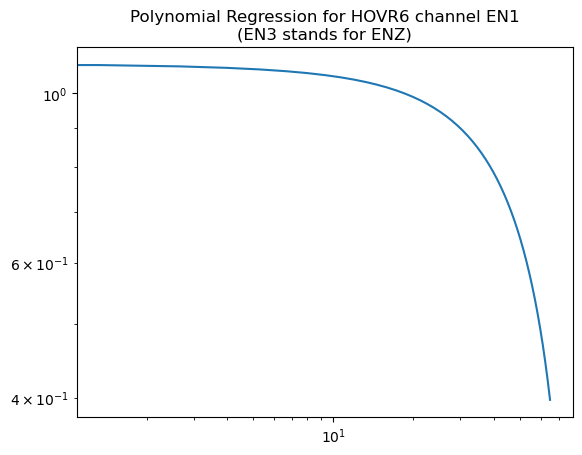

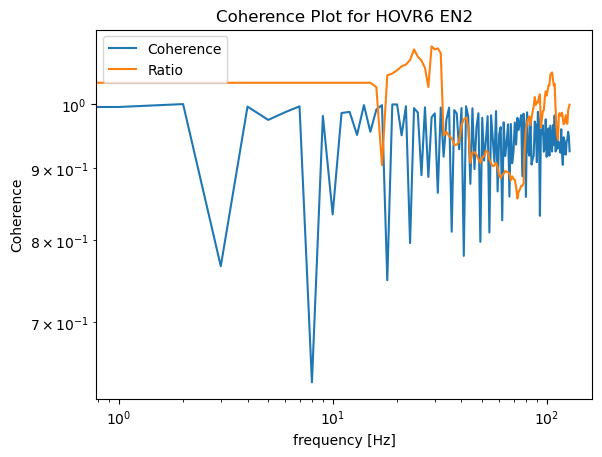

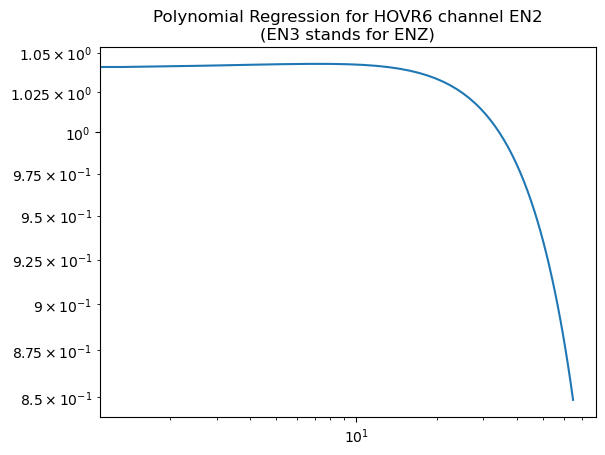

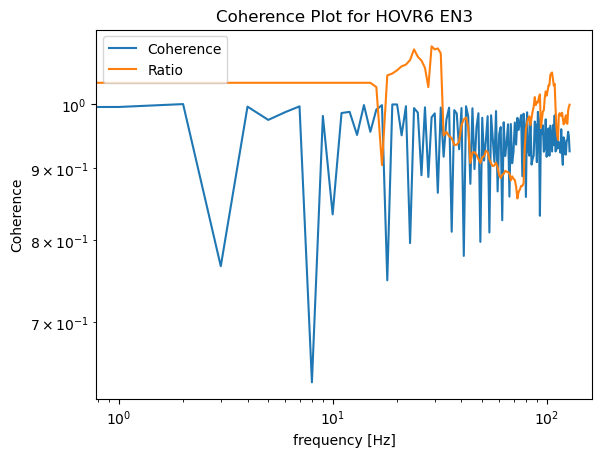

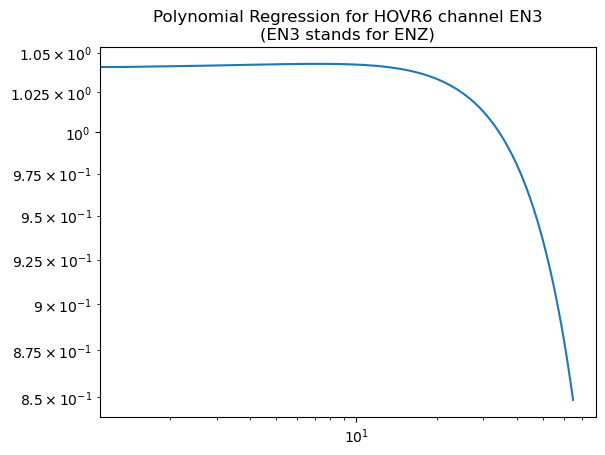

In [38]:
def spectral_ratio_finder_fft(station_dict_log,station_dict_sens):
    import numpy as np
    #Make two new dictionaries for the spectral ratios and model coefficients. 
    coeff_dict = {}
    ratio_dict = {}
    #Loop through the stations of atlogger
    for station in (station_dict_log):
        #Print the station Id and make two new lists for the ratios and coefficients
        print(station)
        channel_coef_ls = []
        ratio_list = []
        #Loop through the channels of a given atlogger stations
        for i, channel in enumerate(station_dict_log[station]):
            #Get the waveforms from the atlogger/sensor
            powerarrlog = channel
            powerarrsens = station_dict_sens[station][i]
            #Convert the atlogger/atsensor data into traces and concatenate them into a list. 
            atlog_tr = Trace(powerarrlog)
            atsens_tr = Trace(powerarrsens)
            tr_list = [atlog_tr,atsens_tr]
            #Adjust the trace sampling rates and create two new lists for the ffts and amplitude maxes. 
            atlog_tr.stats.sampling_rate = 200
            atsens_tr.stats.sampling_rate = 200
            fft_list = []
            amp_max_list = []
            #Take the fourier transforms of the two traces. 
            for tr in tr_list:
                tr.detrend('demean') # ->EXP
                tr.detrend('simple') # ->EXP
                tr.taper(type='cosine',max_percentage=0.1,side='both') # ->EXP
                max = tr.max()
                #Add the maximum amplitude of the waveform to the trace. 
                amp_max_list.append(max)
                tr_fft = np.fft.fft(tr.data)
                fft00= len(tr_fft)
                if fft00 % 2 == 0:
                    fftn2 = int(fft00/2)
                else:
                    fftn2 = int((fft00-1)/2)
                df = tr.stats.sampling_rate
                df2 = int(df/2)
                tr_fft = tr_fft[0:fftn2]
                freq_axis = np.linspace(0,df2,fftn2)
                scale = 2.0/((fft00-1)*(fft00-1))
                tr_psd = scale*abs2(tr_fft)
                freq_axis = float64(freq_axis)
                tr_psd = float64(tr_psd)
                #Add the fourier transform of the waveform to the list
                fft_list.append(tr_fft)
            #Take the ratios of the ffts and amplitude maxes of the two traces
            ratio = np.abs(fft_list[1])/np.abs(fft_list[0])
            amp_ratio = amp_max_list[1]/amp_max_list[0]
            #Use obspys smoothing function to simplify the output ratio
            smoothed_ratio = smooth(ratio,15) # ->EXP
            #Use plotly to graph the smoothed ratio
            fig = px.line(smoothed_ratio,log_x=True,log_y=True,title=f'Spectral ratios for {station} channel EN{i+1}')
            fig.update_xaxes(range = [0.1,2.2])
            fig.show()
            #Perform a coherence measurement on the waveforms 
            f,cxy = signal.coherence(powerarrsens,powerarrlog,fs=200,nperseg=256)
            #Plot the Coherence
            plt.loglog(cxy)
            plt.loglog(smoothed_ratio[:len(f)])
            plt.title(f'Coherence Plot for {station} EN{i+1}')
            plt.xlabel('frequency [Hz]')
            plt.ylabel('Coherence')
            plt.legend(['Coherence','Ratio'])
            plt.show()
            #Let's create the model based on the first 65 data point of the ratio. This is the region we 
            #are particularly interested in invesigating with the model. 
            x = np.arange(0,len(ratio[0:65])) # ->EXP
            model = np.poly1d(np.polyfit(x,smoothed_ratio[0:65],2)) # ->EXP
            #Add the coefficients of the model to the list. Add the amplitude ratio to the other list
            channel_coef_ls.append(model.coefficients)
            ratio_list.append(amp_ratio)
            #Plot the polynomial regression model. 
            myline = np.linspace(0,len(smoothed_ratio[0:65]))
            plt.loglog(myline, model(myline))
            plt.title(f"""Polynomial Regression for {station} channel EN{i+1}
(EN3 stands for ENZ)""")
            plt.show()
        #Add the station lists to the dictionary. 
        coeff_dict[f'{station}'] = channel_coef_ls
        ratio_dict[f'{station}'] = ratio_list
    return(coeff_dict,ratio_dict)
coeff_dict,ratio_dict = spectral_ratio_finder_fft(station_dict_atlog,station_dict_atsens)
#NOTE: EN1 on HOVR3 is actually EN2

## So the modeling and ratio process we followed worked decently well! You can notice with the HOVR4 plots how manual ratio plotting/modeling was neccessary for some of the stations. The two returns we receive from this function is all the model coefficients composed within a dictionary. We also get a dictionary with all of the maximum amplitude ratios for our atsensor/atlogger waveforms. 

In [22]:
print(coeff_dict,ratio_dict)

{'HOVR': [array([-3.48046032e-04, -6.55488019e-03,  2.27513966e+00]), array([-6.38039829e-05,  2.50370069e-03,  9.73594117e-01]), array([1.11702407e-04, 8.61419206e-03, 9.39102272e-01])], 'HOVR1': [array([-1.43091657e-04,  8.81020769e-04,  8.76400615e-01]), array([-1.44580010e-04,  1.07005423e-03,  8.67929053e-01]), array([-1.42345647e-04,  7.80357245e-03,  8.29171947e-01])], 'HOVR3': [array([-1.94005166e-04,  1.83932337e-02,  8.31826482e-01])], 'HOVR4': [array([-1.38494256e-04,  1.31207029e-02,  8.74966417e-01]), array([-1.24771188e-04,  1.22235843e-02,  8.94486071e-01]), array([-1.78416826e-04,  1.61809116e-02,  8.64005402e-01])], 'HOVR5': [array([-2.00991217e-04,  6.65925549e-03,  1.10422315e+00]), array([-1.98733935e-04,  6.36410995e-03,  1.11199637e+00]), array([-2.00999119e-04,  6.66422235e-03,  1.10391825e+00])], 'HOVR6': [array([-1.22083120e-04, -2.76625167e-03,  1.09291040e+00]), array([-5.81260240e-05,  8.37672966e-04,  1.03986031e+00]), array([-5.81200109e-05,  8.37470381e-0

## The below function is almost identical to our fft ratio function. The only difference now is that the ratios are being taken using the Power spectral densities (PSD'S) of the signals instead of the fourier transforms. 

HOVR


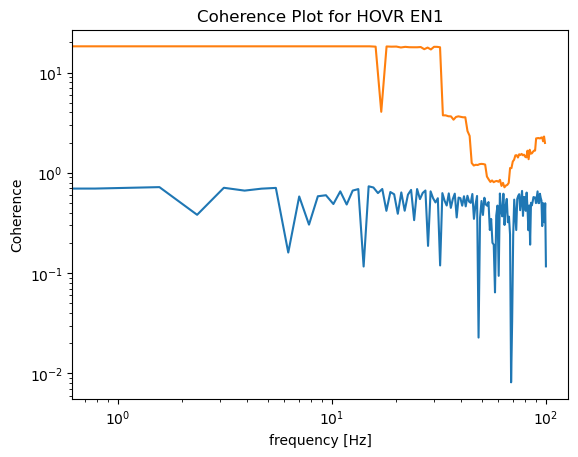

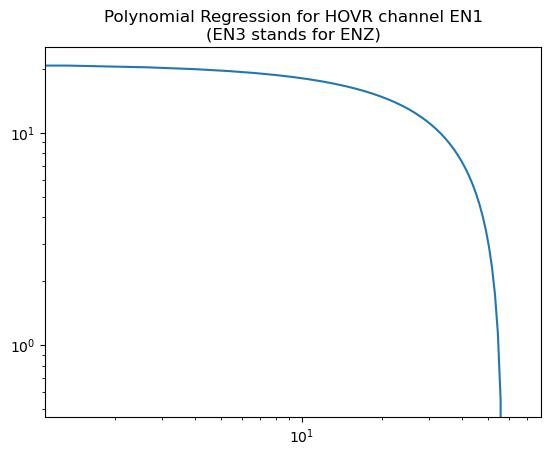

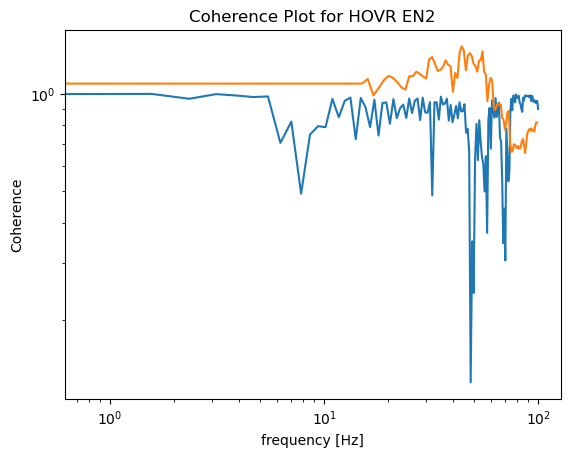

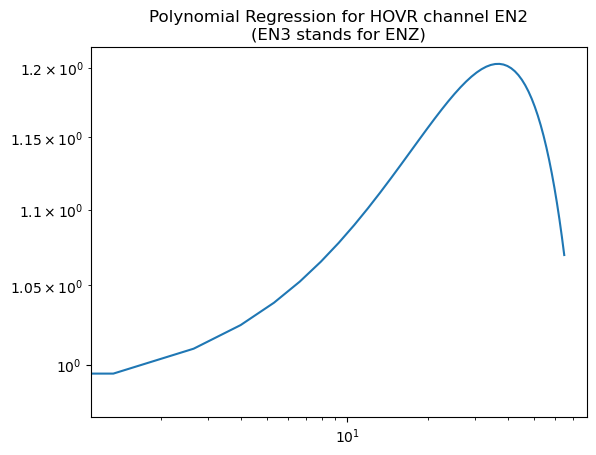

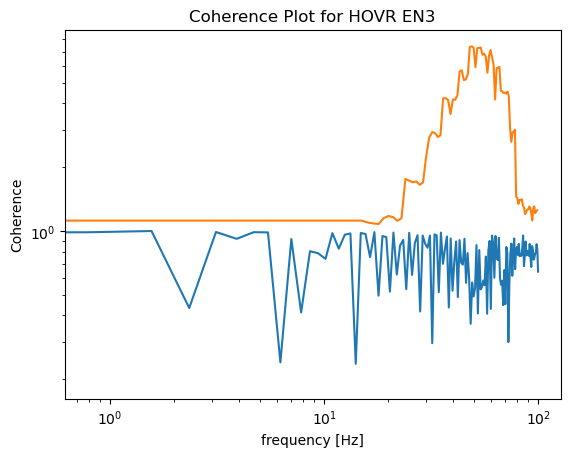

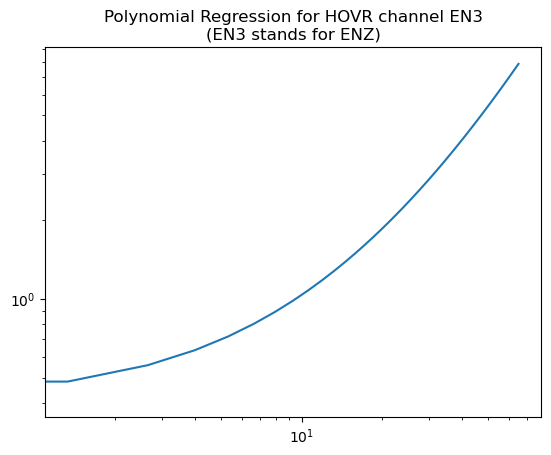

HOVR1


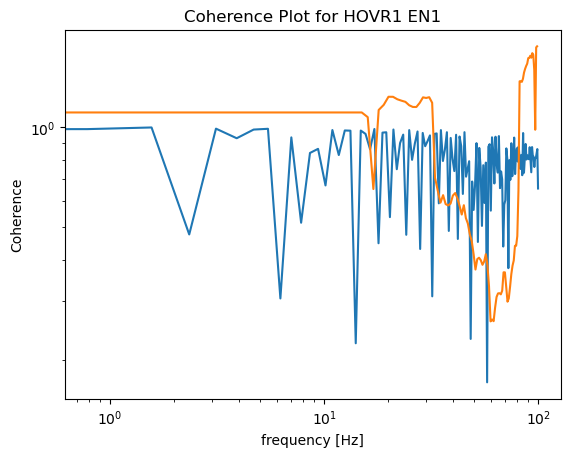

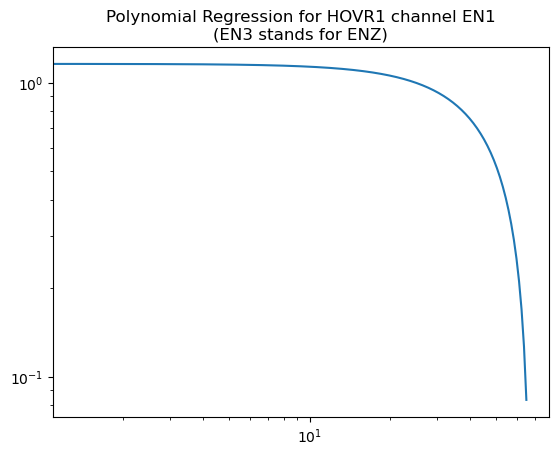

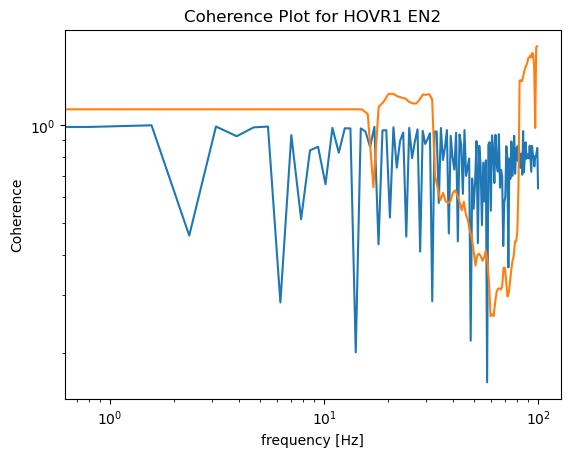

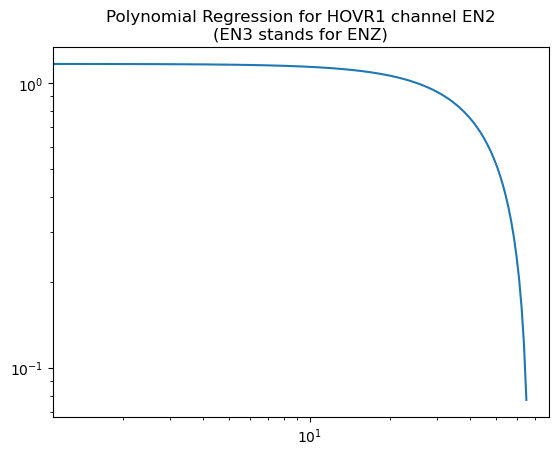

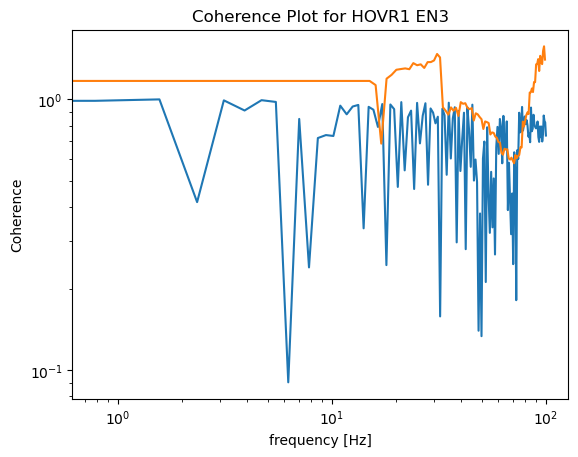

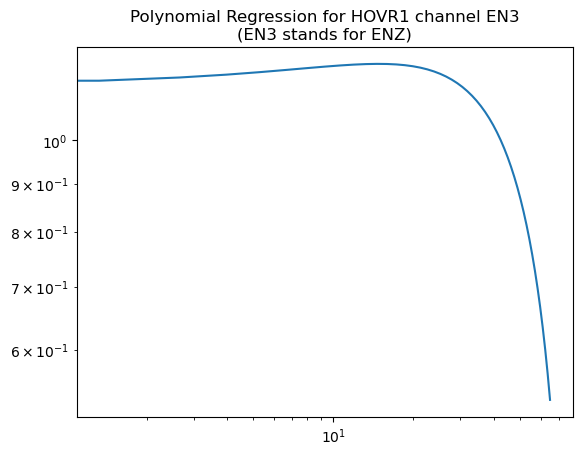

HOVR3


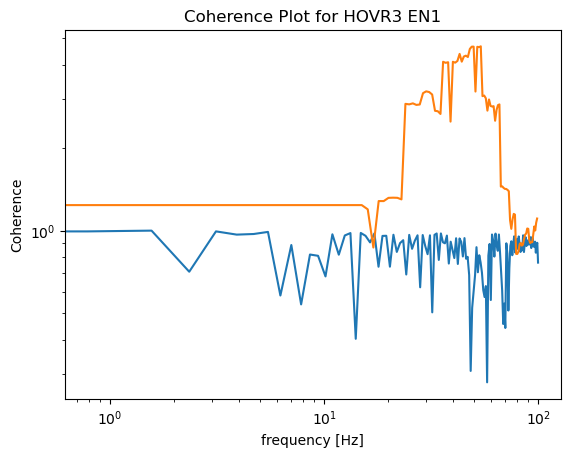

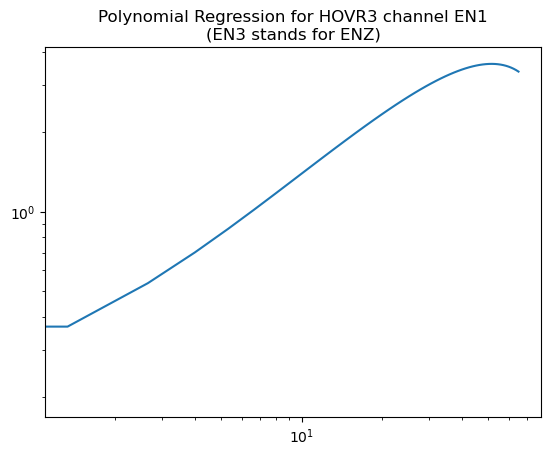

HOVR4


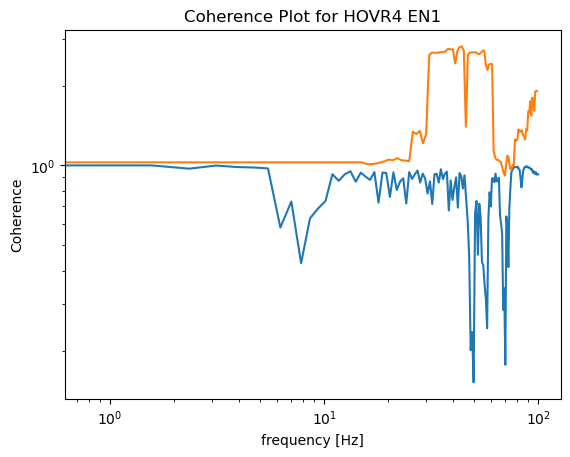

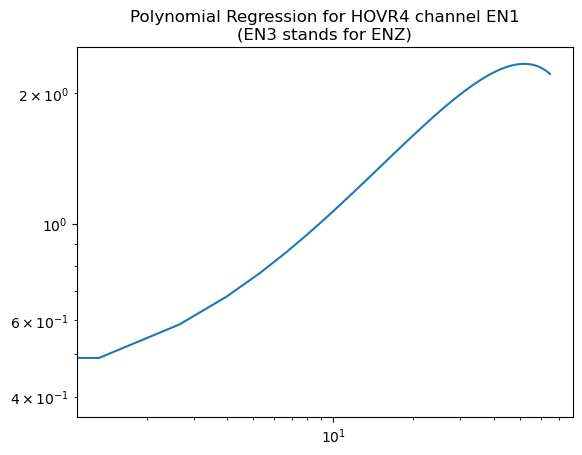

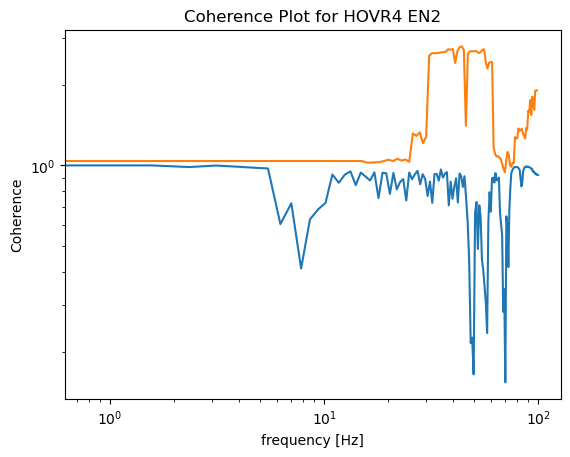

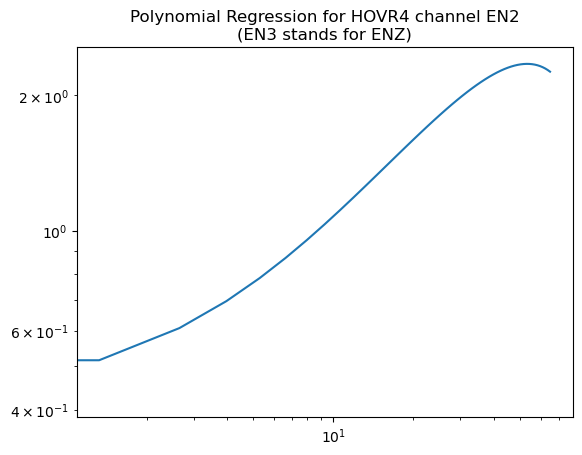

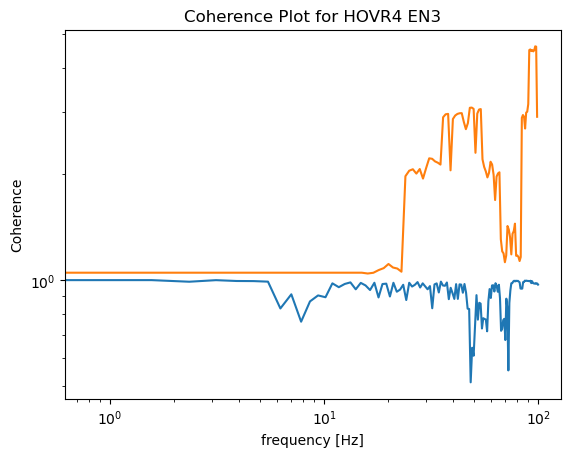

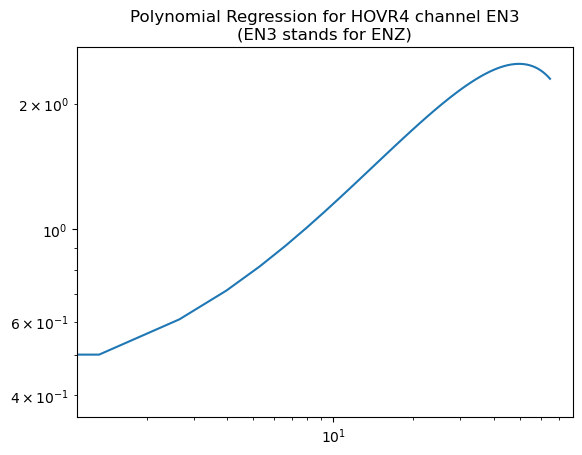

HOVR5


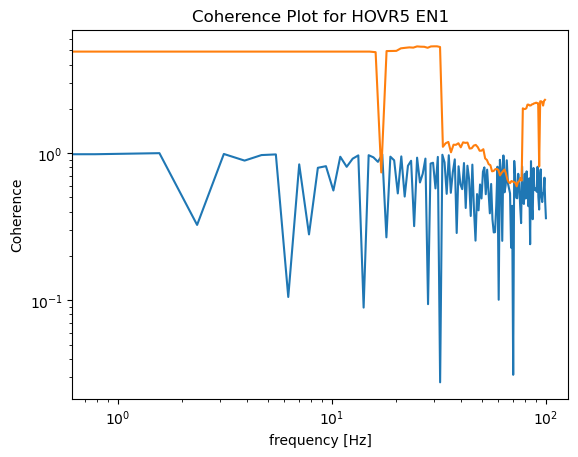

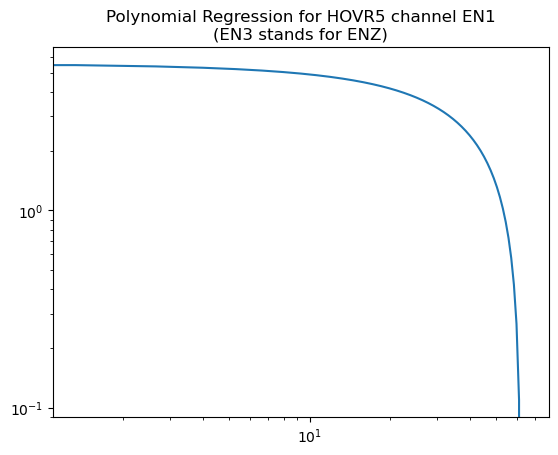

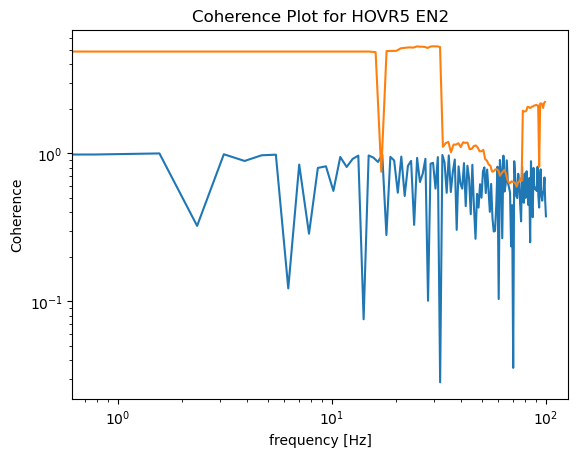

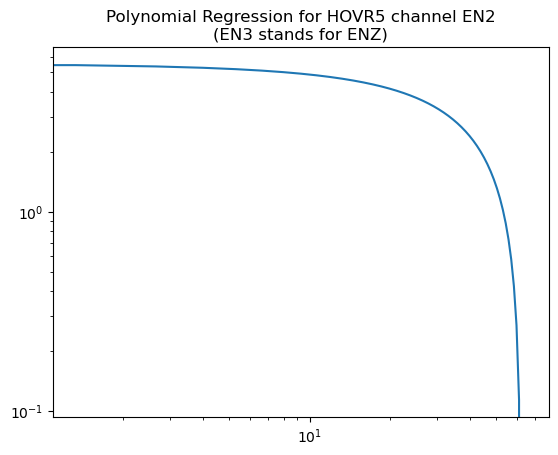

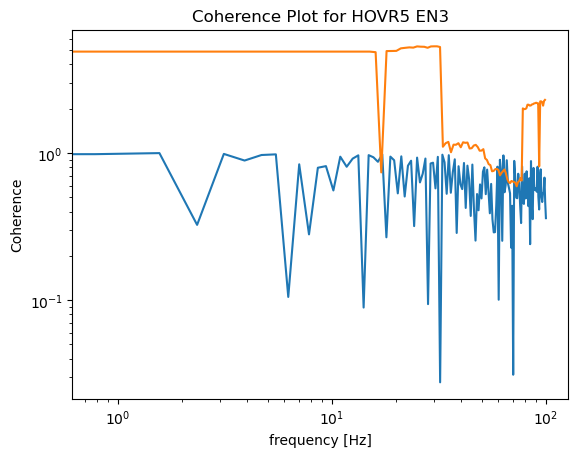

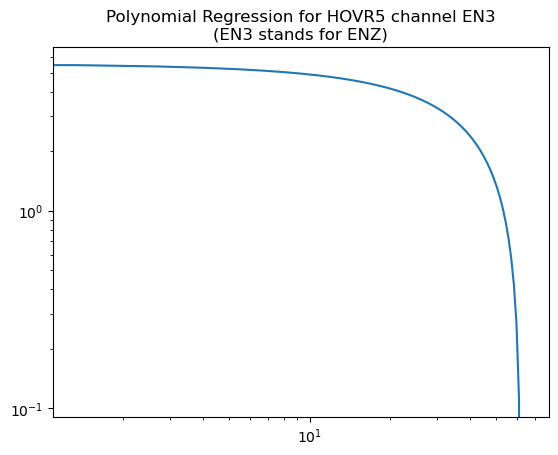

HOVR6


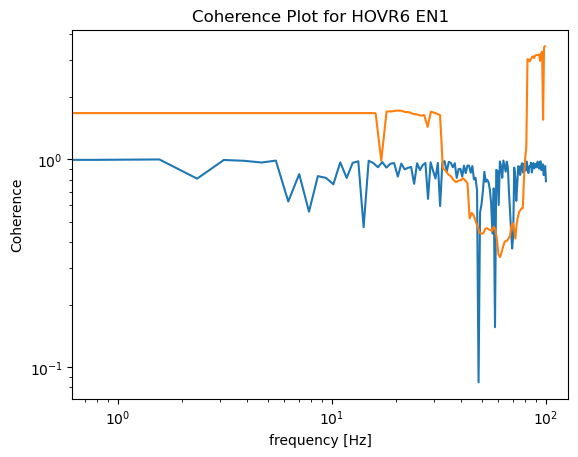

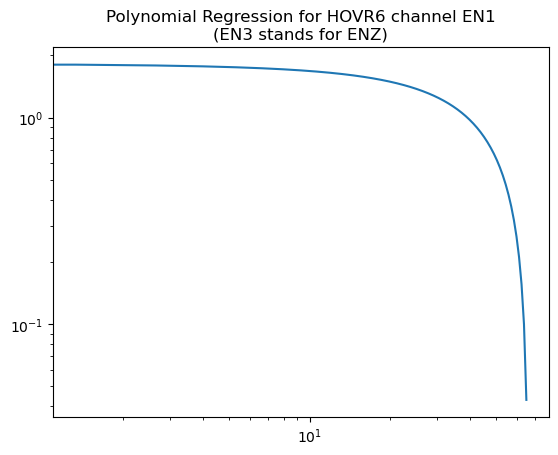

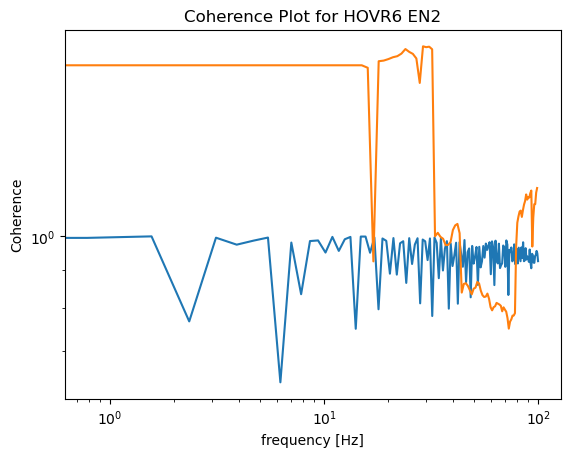

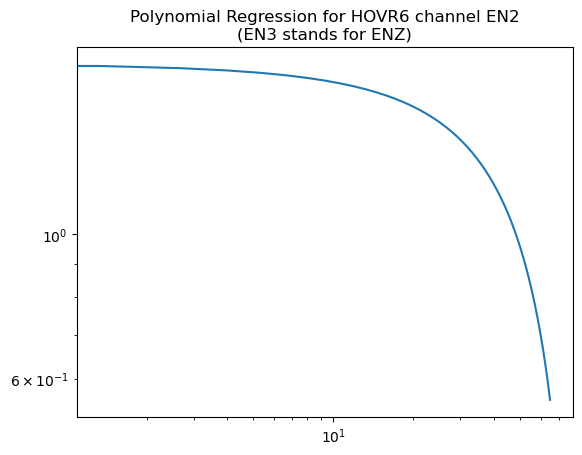

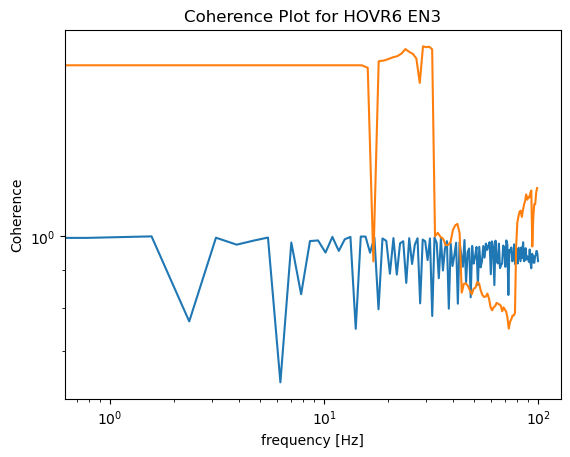

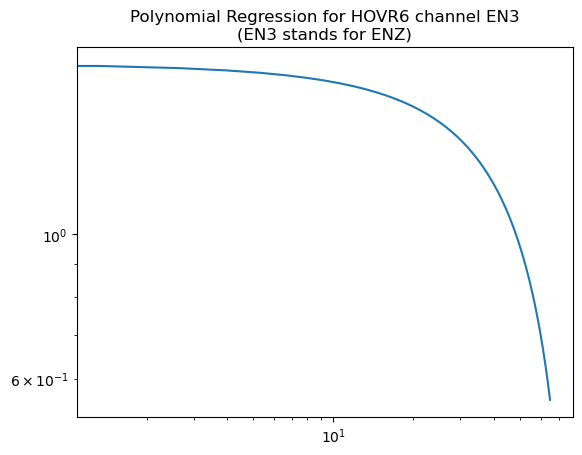

In [39]:
#Same ->EXP labels from the last code block apply here as well.
def spectral_ratio_finder_psd(station_dict_log,station_dict_sens):
    import numpy as np
    #Make two new dictionaries for the spectral ratios and model coefficients. 
    coeff_dict = {}
    ratio_dict = {}
    #Loop through the stations of atlogger
    for station in (station_dict_log):
        #Print the station Id and make two new lists for the ratios and coefficients
        print(station)
        channel_coef_ls = []
        ratio_list = []
        #Loop through the channels of a given atlogger stations
        for i, channel in enumerate(station_dict_log[station]):
            #Get the waveforms from the atlogger/sensor
            powerarrlog = channel
            powerarrsens = station_dict_sens[station][i]
            #Convert the atlogger/atsensor data into traces and concatenate them into a list. 
            atlog_tr = Trace(powerarrlog)
            atsens_tr = Trace(powerarrsens)
            tr_list = [atlog_tr,atsens_tr]
            #Adjust the trace sampling rates and create two new lists for the ffts and amplitude maxes. 
            atlog_tr.stats.sampling_rate = 200
            atsens_tr.stats.sampling_rate = 200
            psd_list = []
            amp_max_list = []
            #Take the fourier transforms of the two traces. 
            for tr in tr_list:
                tr.detrend('demean')
                tr.detrend('simple')
                tr.taper(type='cosine',max_percentage=0.1,side='both')
                max = tr.max()
                #Add the maximum amplitude of the waveform to the trace. 
                amp_max_list.append(max)
                tr_fft = np.fft.fft(tr.data)
                fft00= len(tr_fft)
                if fft00 % 2 == 0:
                    fftn2 = int(fft00/2)
                else:
                    fftn2 = int((fft00-1)/2)
                df = tr.stats.sampling_rate
                df2 = int(df/2)
                tr_fft = tr_fft[0:fftn2]
                freq_axis = np.linspace(0,df2,fftn2)
                scale = 2.0/((fft00-1)*(fft00-1))
                tr_psd = scale*abs2(tr_fft)
                freq_axis = float64(freq_axis)
                tr_psd = float64(tr_psd)
                #Add the fourier transform of the waveform to the list
                psd_list.append(tr_psd)
            #Take the ratios of the ffts and amplitude maxes of the two traces
            ratio = np.abs(psd_list[1])/np.abs(psd_list[0])
            amp_ratio = amp_max_list[1]/amp_max_list[0]
            #Use obspys smoothing function to simplify the output ratio
            smoothed_ratio = smooth(ratio,15)
            #Use plotly to graph the smoothed ratio
            fig = px.line(smoothed_ratio,log_x=True,log_y=True,title=f'Spectral ratios for {station} channel EN{i+1}')
            fig.update_xaxes(range = [0.1,2.2])
            fig.show()
            #Perform a coherence measurement on the waveforms 
            f,cxy = signal.coherence(powerarrsens,powerarrlog,fs=200,nperseg=256)
            #Plot the Coherence
            plt.loglog(f,cxy)
            plt.loglog(smoothed_ratio[:100])
            plt.title(f'Coherence Plot for {station} EN{i+1}')
            plt.xlabel('frequency [Hz]')
            plt.ylabel('Coherence')
            plt.show()
            #Let's create the model based on the first 65 data point of the ratio. This is the region we 
            #are particularly interested in invesigating with the model. 
            x = np.arange(0,len(ratio[0:65]))
            model = np.poly1d(np.polyfit(x,smoothed_ratio[0:65],2))
            #Add the coefficients of the model to the list. Add the amplitude ratio to the other list
            channel_coef_ls.append(model.coefficients)
            ratio_list.append(amp_ratio)
            #Plot the polynomial regression model. 
            myline = np.linspace(0,len(smoothed_ratio[0:65]))
            plt.loglog(myline, model(myline))
            plt.title(f"""Polynomial Regression for {station} channel EN{i+1}
(EN3 stands for ENZ)""")
            plt.show()
        #Add the station lists to the dictionary. 
        coeff_dict[f'{station}'] = channel_coef_ls
        ratio_dict[f'{station}'] = ratio_list
    return(coeff_dict,ratio_dict)
coeff_dict,ratio_dict = spectral_ratio_finder_psd(station_dict_atlog,station_dict_atsens)
#NOTE: EN1 on HOVR3 is actually EN2

We can see how the ratio of the psds varied between some stations/channels compared to the pure ffts. 

# Analysis/results

### So what exactly do these spectral ratio models/plots mean? In the case of the Hoover Dam, engineers/seismologists are especially interested in observing how the atlogger/atsensor cables are influencing frequencies between th 1-10 hz range. As seen by a majority of the plots, a straight line hovers around 1 between 1-10 hz. This means the ratio is roughly 1, and the cable has negligible influence on those lower-frequency signals. We can see between 20-100 hz however, the ratio begins to flucuate. At these frequencies, the cables are starting to significantly influence the transmitted signals.  

### How are we supposed to account for thsese disturbances imposed by the cable? Using the roots of the functions made from the coefficients of our polynomial regression models, we can ascertain the electrical properties of the cable such as resistance and impedence. By knowing these, we are able to adjust our sensor and data logger systems to adjust for this frequency offput. Although the sensors can read frequencies up to 100hz, we decided to cut the data fed to the model off at 60. Beyond 100 hz, the coherence becomes unstable and the data is more vulnerable to noise interference. Essentially, our models were benefited by only factoring in data between 1-60 hz. 

# Notes for further usage of code outside Hoover Dam

### My ultimate hope for this research is that scientists, engineers, and seismologists across the U.S. can utilize my code to investigate cable disturbances on seismological equipment. Do note However that much of these code blocks were altered/constructed based on testing/experimenting on the data, particularly the waveform alignment. You may have to do the same with data you decide to evaluate using this code. You will almost certainly adjust the directory looping scheme if you're data is arranged differently from the HOVR data. 

### This project was also built to handle inputs in the form of square (calibration) signals generated by seismic equipment. Your results will be higher quality if you are able to calibrate your systems beforehand. 

# Subspace Detection

### Subspace detection is the process is assembling a template of waveforms that hold traits of interest to the seismologist, simplifying the template so that only the waveforms' most prominant features are included, and comparing external input waveforms to be 'detected' by the model. 
### For more information on this routine, refer to https://digital.library.unt.edu/ark:/67531/metadc884801/m2/1/high_res_d/900081.pdf , which explains the theorey behind subspace detection. 

To contruct our subspace detector, We first have to convert all of our Waveform data back to traces. This process automatically does this.

In [24]:
for j, station in enumerate(station_dict_atlog):
    for i, channel in enumerate(station_dict_atlog[station]):
        if j == 0:
            tr = Trace(channel)
            tr.stats.samplilng_rate = 200
            tr.write(f'Template_waveforms/atlogger{station+str(i+1)}.MSEED',format='MSEED')
        else:
            tr = Trace(channel)
            tr.stats.sampling_rate = 200
            k = str(j)+str(i+1)
            tr.write(f'Template_waveforms/atlogger{station+k}.MSEED',format='MSEED')
for j, station in enumerate(station_dict_atsens):
    for i, channel in enumerate(station_dict_atsens[station]):
        if j == 0:
            tr = Trace(channel)
            tr.stats.sampling_rate = 200
            tr.write(f'Template_waveforms/atsensor{station+str(i+1)}.MSEED',format='MSEED')
        else:
            tr = Trace(channel)
            tr.stats.sampling_rate = 200
            k = str(j)+str(i+1)
            tr.write(f'Template_waveforms/atsensor{station+k}.MSEED',format='MSEED')

### Now that we have the data ready, let's build our subspace detector using eqcorrscan and obspy. 

In [25]:
from eqcorrscan.core import subspace
detector = subspace.Detector()

In [40]:
from obspy import read
import glob
import os
from eqcorrscan import tests
# Get the path for the test-data so we can test this
wavefiles = glob.glob('Template_waveforms/*')
wavefiles.sort()  # Sort the wavefiles to ensure reproducibility
streams = [read(w) for w in wavefiles]
streams[0][0].stats.sampling_rate = 200 # ->EXP
streams[4][0].stats.sampling_rate = 200 # ->EXP
streams[5][0].stats.sampling_rate = 200 # ->EXP
# Channels must all be the same length
detector.construct(streams=streams, lowcut=2, highcut=9, filt_order=4,
                    sampling_rate=20, multiplex=True, name='Test_1',
                    align=True, shift_len=0.5, reject=0.2) # ->EXP

Detector: Test_1

### Since we built the detector using the Atlogger data, let's test our system on a sample waveform from atsensosite. The code will ouput the energy capture, which is the portion of the original input waveforms kept in the detector. It will then print how many detections were made, and a few example detections from the set. 

In [41]:
#Read in a stream, convert it to a trace, adjust its data array length, and convert it back to a stream
streamey = read('Hoover_cals/HooverCals/Atsensorsite/HOVR4/EN2.D/346/LB.HOVR4.42.EN2.D.2022.346.22')
tr = streamey[0]
dab = tr.data
data = dab[0:1201]
streamey = Trace(data)
streamey = Stream(streamey)
#Initiate the detector on the test stream and print out important information alongside it.
detections = detector.detect(st = streamey, threshold=0.5,trig_int=3) # ->EXP
print(detector.energy_capture())
print(len(detections))
detections[0:5]

100
299


[Detection(template name = Test_1 
  detection id = Test_1_19700101_000002600000 
  detection time = 1970-01-01T00:00:02.600000Z 
  number of channels = 1 
  channels = [('', '')] 
  detection value = 1.0 
  threshold = 0.5 
  threshold type = abs 
  input threshold = 0.5 
  detection type = subspace),
 Detection(template name = Test_1 
  detection id = Test_1_19700101_000005800000 
  detection time = 1970-01-01T00:00:05.800000Z 
  number of channels = 1 
  channels = [('', '')] 
  detection value = 1.0000002 
  threshold = 0.5 
  threshold type = abs 
  input threshold = 0.5 
  detection type = subspace),
 Detection(template name = Test_1 
  detection id = Test_1_19700101_000009250000 
  detection time = 1970-01-01T00:00:09.250000Z 
  number of channels = 1 
  channels = [('', '')] 
  detection value = 1.0 
  threshold = 0.5 
  threshold type = abs 
  input threshold = 0.5 
  detection type = subspace),
 Detection(template name = Test_1 
  detection id = Test_1_19700101_000014000000 


### Our detector performance was excellent! This is not much of a shock considering all the data here were calibration signals with similar amplitudes/periods. Nevertheless, this was a basic exploration into subspace detectors and a real-life application of them.

# Conclusion and Final Remarks

### Seismological data is crucial for investigating physical properties of dams or other major structures in the United States. Ensuring the accuracy of such data is even more important in the contect of proper results/studies. Places like the Hoover Dam contain seismic networks that are logistically difficult or even impossible to intrusively investigate. That is why developing computer systems through programming can have superb applications on ascertaining electrical interferences in seismic instruments. 

### The documentation displayed here might not be a fullproof method of uncovering such electrical properties, yet it is a sufficient exploration and experimentation into the subject. We hope in the future, this project can be utilized and built upon to bolster the quality of seismic data collected throuhgout the United States. 

#### If you have any questions, concerns or critiques, please reach out to lmazza@mines.edu. 

Geophysics Rocks! :)